In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Exploración de datos
## a. Importar los datos obtenidos en la Feria de León 2025 a través de la página web Mapa de Bienestar

In [3]:
data = pd.read_csv('data/data-mapa-bienestar.csv')

## b. Eliminar valores de prueba

In [1279]:
nombres_de_prueba = ['Diego Lerma', 'Diego Cesar Lerma Torres', 'Brandon Lee Agüero Fernández', 'Brandon Lee Agüero Fernández ', 'Jju', 'Diego', 'Dgg', 'Skd', 'Libia Denisse']


In [1280]:
data = data[~data['name'].isin(nombres_de_prueba)]

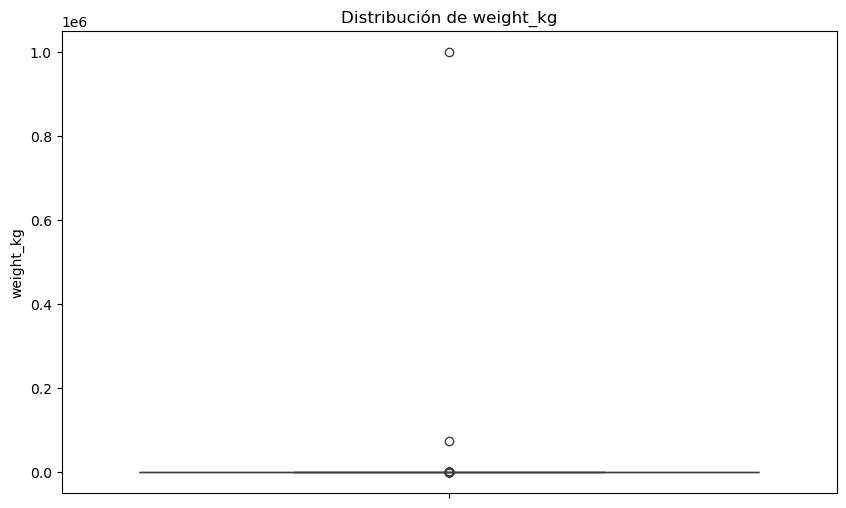

Estadísticas de weight_kg:
Q1: 56.00
Q3: 80.00
IQR: 24.00
Límite superior: 116.00

Número de registros con peso > 116.00 kg: 29


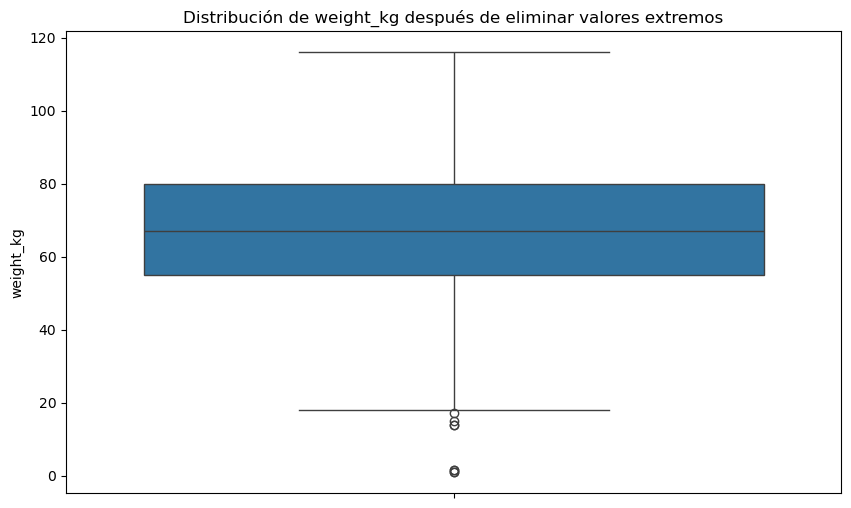


Resumen estadístico final de weight_kg:
count    1425.000000
mean       67.011965
std        18.791037
min         1.000000
25%        55.000000
50%        67.000000
75%        80.000000
max       116.000000
Name: weight_kg, dtype: float64


In [4]:
# Visualizar la distribución de weight_kg para identificar valores extremos
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, y='weight_kg')
plt.title('Distribución de weight_kg')
plt.show()

# Calcular los límites para valores atípicos usando el método del rango intercuartílico (IQR)
Q1 = data['weight_kg'].quantile(0.25)
Q3 = data['weight_kg'].quantile(0.75)
IQR = Q3 - Q1
limite_superior = Q3 + 1.5 * IQR

print(f"Estadísticas de weight_kg:")
print(f"Q1: {Q1:.2f}")
print(f"Q3: {Q3:.2f}")
print(f"IQR: {IQR:.2f}")
print(f"Límite superior: {limite_superior:.2f}")
print(f"\nNúmero de registros con peso > {limite_superior:.2f} kg: {len(data[data['weight_kg'] > limite_superior])}")

# Filtrar los datos eliminando valores extremos de peso
data = data[data['weight_kg'] <= limite_superior]

# Verificar la nueva distribución
plt.figure(figsize=(10, 6))
sns.boxplot(data=data, y='weight_kg')
plt.title('Distribución de weight_kg después de eliminar valores extremos')
plt.show()

print("\nResumen estadístico final de weight_kg:")
print(data['weight_kg'].describe())

### Procesar valores para calculo de cancer de mama

In [1282]:
import pandas as pd
import numpy as np
import logging
from typing import Optional, Dict, Any, Tuple
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import DataFrame, IntVector
from rpy2.robjects import StrVector

# Configurar logging básico para el notebook
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def calculate_breast_cancer_risk_for_row(row: pd.Series) -> Tuple[float, str]:
    """
    Calcula el riesgo de cáncer de mama para una fila del dataframe usando el modelo BCRA.
    
    Args:
        row: Una fila del dataframe con los datos necesarios
        
    Returns:
        Tuple con (valor_riesgo, interpretación)
    """
    try:
        # Extraer valores de la fila
        age_years = row.get('age_years')
        age_at_menarche = row.get('age_at_menarche_years')
        maternal_first_birth_age = row.get('maternal_first_birth_age')
        breast_cancer_relatives = row.get('breast_cancer_first_degree_relatives')
        previous_biopsies = row.get('previous_breast_biopsies', 'UNKNOWN')
        atypical_hyperplasia = row.get('atypical_hyperplasia', 'NO')
        ethnicity = row.get('ethnicity')
        sex = row.get('sex')
        
        # Solo calcular para mujeres
        if sex != 'FEMALE':
            return np.nan, "No aplicable para hombres"
        
        # Validar que los valores de entrada sean válidos
        if pd.isna(age_years) or pd.isna(age_at_menarche) or pd.isna(maternal_first_birth_age) or \
           pd.isna(breast_cancer_relatives) or pd.isna(ethnicity):
            return np.nan, "Datos insuficientes para el cálculo"

        # Validar edad
        try:
            age_years = int(age_years)
            if not (35 <= age_years <= 85):
                return np.nan, f"Edad {age_years} fuera del rango válido (35-85)"
        except (TypeError, ValueError):
            return np.nan, f"Edad inválida: {age_years}"

        # Importar librería BCRA de R
        try:
            bcra = importr("BCRA")
        except Exception as e:
            logger.error(f"Error importando librería BCRA de R: {str(e)}")
            return np.nan, "Error en la librería BCRA"

        # Mapear valores de enum a los valores esperados por R
        age_menarche_map = {
            "AGE_7_11_YEARS": 1,
            "AGE_12_13_YEARS": 2,
            "MORE_THAN_13_YEARS": 3,
            "UNKNOWN": 99,
        }

        birth_age_map = {
            "LESS_THAN_20_YEARS": 1,
            "AGE_20_24_YEARS": 2,
            "AGE_25_29_YEARS": 3,
            "AGE_30_OR_MORE_YEARS": 4,
            "NO_CHILDREN": 0,
            "UNKNOWN": 99,
        }

        # Mapeo de etnias según el array char_race en R
        ethnicity_map = {
            "WHITE": 1,  # White
            "BLACK": 2,  # African-American
            "HISPANIC": 3,  # Hispanic-American
            "ASIAN": 4,  # Other
            "NATIVE_AMERICAN": 4,  # Other
            "UNKNOWN": 4,  # Other
        }

        # Convertir y validar valores mapeados
        try:
            age_men = age_menarche_map.get(age_at_menarche, 99)
            age_1st = birth_age_map.get(maternal_first_birth_age, 99)

            # Convertir número de familiares según el formato del enum
            n_rels = 2 if breast_cancer_relatives == "MORE_THAN_ONE" else \
                     1 if breast_cancer_relatives == "ONE" else \
                     0 if breast_cancer_relatives == "NONE" else 99

            # Obtener raza del mapeo
            race = ethnicity_map.get(ethnicity, 4)  # 4 = Other si no se encuentra

            # Convertir número de biopsias según el formato del enum
            if previous_biopsies == "MORE_THAN_ONE":
                n_biopsies = 2
            elif previous_biopsies == "ONE":
                n_biopsies = 1
            elif previous_biopsies == "NONE":
                n_biopsies = 0
            else:
                n_biopsies = 99

            # Aplicar la lógica exacta de R para hiperplasia:
            # Si no hay biopsias, HypPlas debe ser 99
            # Si hay biopsias, entonces usar el valor de hiperplasia
            if n_biopsies == 0:
                hyp_plas = 99
            else:
                hyp_plas = 1 if atypical_hyperplasia == "YES" else (0 if atypical_hyperplasia == "NO" else 99)

            # Validar que todos los valores estén en rangos válidos
            if not (0 <= n_biopsies <= 2 and 0 <= n_rels <= 2 and 1 <= race <= 4):
                return np.nan, "Valores fuera de rango para el cálculo"

        except Exception as e:
            logger.error(f"Error mapeando valores: {str(e)}")
            return np.nan, "Error en el mapeo de valores"

        # Crear dataframe para R asegurando que todos los valores sean IntVector
        try:
            # Ajustes según recomendaciones
            if race == 3:  # Hispanic
                # Para mujeres hispánicas, se usa la codificación para White
                race = 1  # White

            # Validar y ajustar age_1st
            if age_1st == 0:  # Sin hijos
                age_1st = 99  # Usar valor desconocido para mujeres nullíparas

            vectors = {
                "ID": IntVector([1]),
                "T1": IntVector([age_years]),
                "T2": IntVector([age_years + 5]),
                "N_Biop": IntVector([n_biopsies]),
                "HypPlas": IntVector([hyp_plas]),
                "AgeMen": IntVector([age_men]),
                "Age1st": IntVector([age_1st]),
                "N_Rels": IntVector([n_rels]),
                "Race": IntVector([race]),
            }

            # Crear DataFrame con nombres de columnas
            df = DataFrame(vectors)
            df.colnames = StrVector(list(vectors.keys()))

        except Exception as e:
            logger.error(f"Error creando DataFrame: {str(e)}")
            return np.nan, "Error en la creación de datos para el cálculo"

        # Calcular riesgos
        try:
            # Obtener riesgo a 5 años
            risk_result = bcra.absolute_risk(df)

            if risk_result is None or len(risk_result) == 0:
                return np.nan, "Error en el cálculo de riesgo"

            # CORRECCIÓN: No multiplicar por 100
            five_year_risk = round(float(risk_result[0]), 1)

            # Verificar valor válido (el riesgo no debe superar 100%)
            if five_year_risk < 0 or five_year_risk > 100:
                return np.nan, "Resultado de riesgo inválido"

            # Determinar nivel de riesgo
            risk_level = "Alto" if five_year_risk > 1.7 else "Bajo"
            
            return five_year_risk, f"{risk_level} riesgo de cáncer de mama ({five_year_risk}%)"

        except Exception as e:
            logger.error(f"Error calculando riesgos con BCRA: {str(e)}")
            return np.nan, "Error en el cálculo de riesgo"

    except Exception as e:
        logger.error(f"Error general: {str(e)}")
        return np.nan, "Error en el cálculo"

def apply_breast_cancer_risk_calculation(data: pd.DataFrame) -> pd.DataFrame:
    """
    Aplica el cálculo de riesgo de cáncer de mama a todo el dataframe.
    
    Args:
        data: DataFrame con los datos necesarios
        
    Returns:
        DataFrame con los resultados calculados
    """
    # Crear una copia del dataframe para no modificar el original
    result_df = data.copy()
    
    # Inicializar columnas de resultados
    result_df['breast_cancer_risk_value'] = np.nan
    result_df['breast_cancer_risk_interpretation'] = ""
    
    # Aplicar la función a cada fila
    for idx, row in result_df.iterrows():
        risk_value, risk_interpretation = calculate_breast_cancer_risk_for_row(row)
        result_df.at[idx, 'breast_cancer_risk_value'] = risk_value
        result_df.at[idx, 'breast_cancer_risk_interpretation'] = risk_interpretation
    
    return result_df

# Aplicar el cálculo a todo el dataframe
data = apply_breast_cancer_risk_calculation(data)

# Verificar los resultados
print(f"Registros con riesgo calculado: {data['breast_cancer_risk_value'].notna().sum()}")
print(f"Registros sin riesgo calculado: {data['breast_cancer_risk_value'].isna().sum()}")

# Ver algunos ejemplos de resultados
data[['age_years', 'sex', 'breast_cancer_risk_value', 'breast_cancer_risk_interpretation']].sample(10)

Registros con riesgo calculado: 272
Registros sin riesgo calculado: 1147


age_years     sex  breast_cancer_risk_value  \
363          45  FEMALE                       NaN   
611          14  FEMALE                       NaN   
599          17  FEMALE                       NaN   
462           8  FEMALE                       NaN   
898          55  FEMALE                       0.9   
1017         43  FEMALE                       NaN   
207          38  FEMALE                       NaN   
964          58    MALE                       NaN   
1335         24  FEMALE                       NaN   
333          39  FEMALE                       0.4   

           breast_cancer_risk_interpretation  
363   Valores fuera de rango para el cálculo  
611   Edad 14 fuera del rango válido (35-85)  
599   Edad 17 fuera del rango válido (35-85)  
462    Edad 8 fuera del rango válido (35-85)  
898     Bajo riesgo de cáncer de mama (0.9%)  
1017  Valores fuera de rango para el cálculo  
207   Valores fuera de rango para el cálculo  
964                No aplicable para hombres  
1335  Edad 24 fuera del rango válido (35-85)  
333     Bajo riesgo de cáncer de mama (0.4%)

## c. Análisis exploratorio de datos

In [1283]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1419 entries, 5 to 1584
Data columns (total 83 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   id                                         1419 non-null   int64  
 1   age_years                                  1419 non-null   int64  
 2   country                                    1419 non-null   object 
 3   municipality                               1419 non-null   object 
 4   name                                       1363 non-null   object 
 5   sex                                        1419 non-null   object 
 6   state                                      1419 non-null   object 
 7   age_at_menarche_years                      856 non-null    object 
 8   breast_cancer_first_degree_relatives       856 non-null    object 
 9   breathlessness_last_4_weeks                1419 non-null   object 
 10  cigarettes_per_day           

In [1284]:
data.describe()

id    age_years  cigarettes_per_day  \
count  1419.000000  1419.000000         1419.000000   
mean    803.324172    31.665257            0.515152   
std     451.103978    16.015683            2.098832   
min       5.000000     3.000000            0.000000   
25%     416.500000    17.000000            0.000000   
50%     799.000000    31.000000            0.000000   
75%    1194.500000    42.000000            0.000000   
max    1585.000000    83.000000           30.000000   

       difficulty_carrying_weight  difficulty_climbing_stairs  \
count                 1419.000000                 1419.000000   
mean                     0.019732                    0.010571   
std                      0.170967                    0.121234   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                    0.000000   
75%                      0.000000                    0.000000   
max                      2.000000                    2.000000   

       difficulty_crossing_room  difficulty_rising_from_bed  falls_last_year  \
count               1419.000000                 1419.000000      1419.000000   
mean                   0.001409                    0.008457         0.019027   
std                    0.037529                    0.099003         0.136670   
min                    0.000000                    0.000000         0.000000   
25%                    0.000000                    0.000000         0.000000   
50%                    0.000000                    0.000000         0.000000   
75%                    0.000000                    0.000000         0.000000   
max                    1.000000                    2.000000         1.000000   

       height_meters  moderate_activity_days  ...  adjusted_body_weight_value  \
count    1408.000000             1419.000000  ...                 1408.000000   
mean        1.594723                1.606765  ...                   58.844853   
std         0.166233                1.920599  ...                   14.228334   
min         0.440000                0.000000  ...                    1.000000   
25%         1.540000                0.000000  ...                   50.770109   
50%         1.610000                1.000000  ...                   59.029551   
75%         1.692500                3.000000  ...                   68.236661   
max         2.000000                7.000000  ...                   96.428402   

         bee_basal    bee_total  ipaq_total_met_minutes  ipaq_total_calories  \
count  1408.000000  1408.000000             1419.000000          1419.000000   
mean   1512.202053  2233.513686             4498.902748          6140.281184   
std     268.027533   535.803193             6171.926003          8424.550888   
min     517.170000   801.620000                0.000000             0.000000   
25%    1335.935000  1832.895000              960.000000          1310.000000   
50%    1465.105000  2141.840000             2556.000000          3488.000000   
75%    1668.050000  2561.510000             5583.500000          7620.500000   
max    2476.370000  4412.880000            69095.000000         94314.000000   

       pack_years_value  sarcopenia_risk_value  copd_risk_value  \
count       1419.000000            1419.000000      1419.000000   
mean           0.407787               0.059197         0.118393   
std            2.613254               0.417383         0.441268   
min            0.000000               0.000000         0.000000   
25%            0.000000               0.000000         0.000000   
50%            0.000000               0.000000         0.000000   
75%            0.000000               0.000000         0.000000   
max           52.500000               6.000000         4.000000   

       ost_score_value  breast_cancer_risk_value  
count      1419.000000                272.000000  
mean          6.706131                  0.902574  
std  

### Eliminar nombres para proyección de datos personales

In [1285]:
## Eliminar nombres
data = data.drop(columns=['name'])
## Eliminar email
data = data.drop(columns=['email'])


In [1286]:
data.sample(10)

id  age_years country municipality     sex       state  \
1242  1203         58  México         León    MALE  Guanajuato   
657    642         40  México         León    MALE  Guanajuato   
1185  1141         24  México         León  FEMALE  Guanajuato   
388    370         25  México      Abasolo  FEMALE  Guanajuato   
411    393         42  México         León  FEMALE  Guanajuato   
124    115         48  México         León    MALE  Guanajuato   
762    743         33  México         León    MALE  Guanajuato   
1467  1416         39  México         León  FEMALE  Guanajuato   
521   1519         18  México         León  FEMALE  Guanajuato   
758    739         12  México         León  FEMALE  Guanajuato   

     age_at_menarche_years breast_cancer_first_degree_relatives  \
1242                   NaN                                  NaN   
657                    NaN                                  NaN   
1185       AGE_12_13_YEARS                                 NONE   
388        AGE_12_13_YEARS                                 NONE   
411         AGE_7_11_YEARS                                 NONE   
124                    NaN                                  NaN   
762                    NaN                                  NaN   
1467        AGE_7_11_YEARS                                 NONE   
521        AGE_12_13_YEARS                                 NONE   
758         AGE_7_11_YEARS                                 NONE   

     breathlessness_last_4_weeks  cigarettes_per_day  ... pack_years_value  \
1242                       NEVER                   0  ...              0.0   
657                    SOMETIMES                   2  ...              1.0   
1185                       NEVER                   0  ...              0.0   
388                        NEVER                   0  ...              0.0   
411                        NEVER                   0  ...              0.0   
124                        NEVER                   0  ...              0.0   
762                        NEVER                   5  ...              7.0   
1467                       NEVER                  10  ...              0.0   
521                        NEVER                   0  ...              0.0   
758                        NEVER                   0  ...              0.0   

                              pack_years_interpretation  \
1242  Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
657   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
1185  Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
388   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
411   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
124   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
762   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
1467  Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
521   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   
758   Riesgo Bajo de Enfermedad Pulmonar Obstructiva...   

      sarcopenia_risk_value  sarcopenia_risk_interpretation  copd_risk_value  \
1242                      0        Sin riesgo de sarcopenia                0   
657                       0        Sin riesgo de sarcopenia                1   
1185                      0        Sin riesgo de sarcopenia                0   
388                       0        Sin riesgo de sarcopenia                0   
411                       0        Sin riesgo de sarcopenia                0   
124                       0        Sin riesgo de sarcopenia                3   
762                       0        Sin riesgo de sarcopenia                0   
1467                      0        Sin riesgo de sarcopenia                0   
521                       0        Sin riesgo de sarcopenia                0   
758                       0        Sin riesgo de sarcopenia                0   

                               copd_risk_interpretation  ost_score_value  \
1242  Baja probabilidad de Enfermedad Pulmonar Obstr...              3.0   
6

# 2. Preprocesamiento de datos
## a. Separar los datos que están en objetos en columnas independientes

Estos son:
- bee_activity
- ipaq_activities
- ipaq_sedentary_time







In [1287]:
def parse_json_column(series, prefix, keys, is_list=False, max_list_elements=None):
    import json
    import pandas as pd

    def parse_value(x):
        # Si el valor es NaN o no es una cadena, se retorna una lista o diccionario vacío según el caso
        if pd.isna(x) or not isinstance(x, str):
            return [] if is_list else {}
        try:
            return json.loads(x)
        except (json.JSONDecodeError, TypeError):
            return [] if is_list else {}

    if is_list and max_list_elements is None:
        def safe_len(x):
            parsed = parse_value(x)
            return len(parsed) if isinstance(parsed, list) else 0
        # Se calcula el máximo y se fuerza la conversión a entero; si no se obtiene un valor se asigna 0.
        max_len = series.apply(safe_len).max()
        max_list_elements = int(max_len) if max_len is not None else 0

    new_data = []
    for value in series:
        parsed = parse_value(value)
        if not is_list:
            # Caso: objeto JSON (diccionario)
            row = {f"{prefix}_{key}": parsed.get(key) if isinstance(parsed, dict) else None for key in keys}
        else:
            # Caso: lista de diccionarios
            row = {}
            if isinstance(parsed, list):
                for i in range(max_list_elements):
                    if i < len(parsed) and isinstance(parsed[i], dict):
                        for key in keys:
                            row[f"{prefix}_{i+1}_{key}"] = parsed[i].get(key)
                    else:
                        for key in keys:
                            row[f"{prefix}_{i+1}_{key}"] = None
            else:
                for i in range(max_list_elements):
                    for key in keys:
                        row[f"{prefix}_{i+1}_{key}"] = None
        new_data.append(row)

    return pd.DataFrame(new_data, index=series.index)

In [1288]:
# 1. Parsear bee_activity (objeto JSON)
df_bee = parse_json_column(data['bee_activity'], "bee_activity", ["level", "factor", "description"], is_list=False)

# 2. Parsear ipaq_activities (lista de diccionarios)
df_ipaq = parse_json_column(data['ipaq_activities'], "ipaq_activities", ["name", "met_minutes", "calories"], is_list=True)

# 3. Parsear ipaq_sedentary_time (objeto JSON)
df_sedentary = parse_json_column(data['ipaq_sedentary_time'], "ipaq_sedentary_time", ["hours", "minutes"], is_list=False)

# Combinar las nuevas columnas con el DataFrame original (opcional)
data = pd.concat([data, df_bee, df_ipaq, df_sedentary], axis=1)


# 3. Análisis de Datos

## a. Análisis de edad

In [1289]:
data.age_years.describe()

count    1419.000000
mean       31.665257
std        16.015683
min         3.000000
25%        17.000000
50%        31.000000
75%        42.000000
max        83.000000
Name: age_years, dtype: float64

/tmp/ipykernel_4485/2981250747.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="viridis")


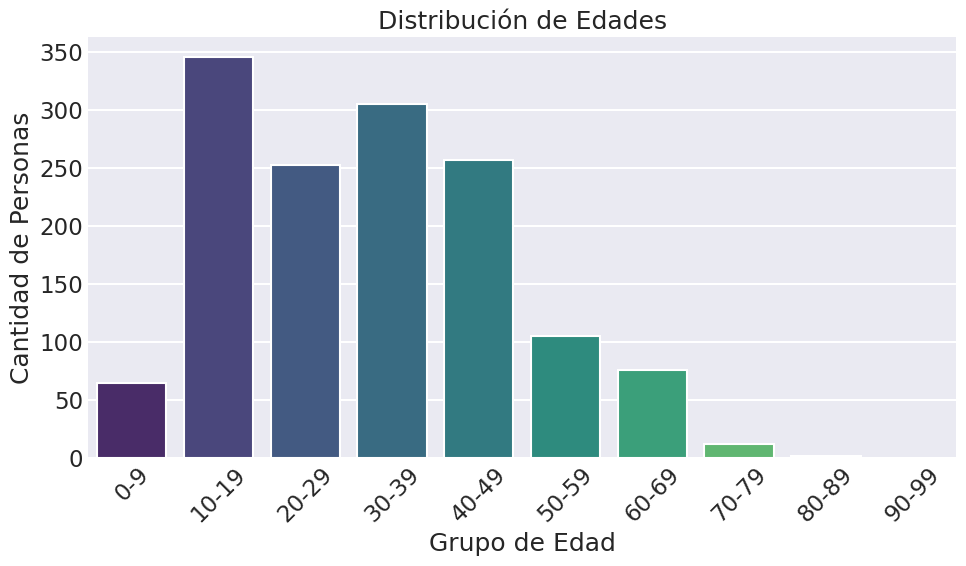

In [1290]:
# Definir los límites de los intervalos (bins).
# Se asume que las edades varían entre 0 y 100, lo cual es suficiente para el rango observado (min: 3, max: 152)
bins = list(range(0, 101, 10))
# Crear etiquetas para los grupos, por ejemplo "0-9", "10-19", etc.
labels = [f"{b}-{b+9}" for b in bins[:-1]]

# Crear la columna 'age_group' usando pd.cut con los intervalos definidos.
# Aquí se usa right=False para que los intervalos incluyan el límite inferior y excluyan el superior,
# de forma que 0-9 incluya las edades entre 0 y 9.
data['age_group'] = pd.cut(data['age_years'], bins=bins, labels=labels, right=False, include_lowest=True)

# Contar el número de personas en cada grupo de edad y ordenar los grupos por orden natural (de menor a mayor edad).
age_group_counts = data['age_group'].value_counts().sort_index()

# Graficar la distribución usando un gráfico de barras.
plt.figure(figsize=(10, 6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette="viridis")
plt.title("Distribución de Edades")
plt.xlabel("Grupo de Edad")
plt.ylabel("Cantidad de Personas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## b. Análisis de ubicación geográfica

In [1291]:
def plot_category_counts(data, column='smoking_status', title="Distribución de Estado de Tabaquismo", 
                         xlabel="Estado de Tabaquismo", ylabel="Cantidad de Personas", 
                         figsize=(15,8), rotation=45, ha='right', use_hue=False, dodge=False, **kwargs):
    
    # Crear una copia para no modificar los datos originales
    df_temp = data.copy()
    
    # Traducir las categorías al español si es smoking_status
    if column == 'smoking_status':
        traduccion = {
            'NON_SMOKER': 'No fumador',
            'CURRENT_SMOKER': 'Fumador actual',
            'FORMER_SMOKER': 'Ex fumador'
        }
        
        # Aplicar la traducción
        if column in df_temp.columns:
            df_temp[column] = df_temp[column].map(traduccion)
    
    # Configurar el estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Crear la figura
    plt.figure(figsize=figsize)
    
    # Definir una paleta de colores más llamativa
    paleta = ['#FF5733', '#33A8FF', '#33FF57']
    
    # Crear el gráfico de barras
    ax = sns.countplot(
        data=df_temp, 
        x=column,
        palette=paleta,
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8,
        dodge=dodge,  # Añadir el parámetro dodge
        **kwargs      # Añadir cualquier otro parámetro adicional
    )
    
    # Añadir etiquetas con el número exacto encima de cada barra
    for p in ax.patches:
        ax.annotate(
            f'{int(p.get_height())}', 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='bottom',
            fontsize=12,
            fontweight='bold',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Personalizar el gráfico
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.xticks(rotation=rotation, ha=ha, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Añadir un borde al gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(1.5)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    return ax

In [1292]:
def plot_category_percentages(data, column='smoking_status', title="Distribución de Estado de Tabaquismo (%)", 
                             xlabel="Estado de Tabaquismo", ylabel="Porcentaje (%)", 
                             figsize=(15,8), rotation=0, ha='center', use_hue=False, dodge=False, **kwargs):
    
    # Crear una copia para no modificar los datos originales
    df_temp = data.copy()
    
    # Traducir las categorías al español según la columna
    if column == 'smoking_status':
        traduccion = {
            'NON_SMOKER': 'No fumador',
            'CURRENT_SMOKER': 'Fumador actual',
            'FORMER_SMOKER': 'Ex fumador'
        }
        
        # Aplicar la traducción
        if column in df_temp.columns:
            df_temp[column] = df_temp[column].map(traduccion)
    
    # Traducir valores booleanos para columnas como has_hypertension
    elif column == 'has_hypertension':
        traduccion = {
            True: 'Sí',
            False: 'No'
        }

    elif column == 'has_diabetes':
        traduccion = {
            True: 'Sí',
            False: 'No'
        }
        
        # Aplicar la traducción
        if column in df_temp.columns:
            df_temp[column] = df_temp[column].map(traduccion)
    
    # Calcular los porcentajes
    total = len(df_temp)
    porcentajes = (df_temp[column].value_counts() / total * 100).reset_index()
    porcentajes.columns = [column, 'percentage']
    
    # Configurar el estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Crear la figura
    plt.figure(figsize=figsize)
    
    # Definir una paleta de colores más llamativa
    paleta = ['#FF5733', '#33A8FF', '#33FF57']
    
    # Crear el gráfico de barras con porcentajes
    ax = sns.barplot(
        data=porcentajes, 
        x=column,
        y='percentage',
        palette=paleta,
        edgecolor='black',
        linewidth=1.5,
        alpha=0.8,
        **kwargs  # Pasar cualquier otro parámetro adicional
    )
    
    # Añadir etiquetas con el porcentaje exacto encima de cada barra
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1f}%', 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='bottom',
            fontsize=12,
            fontweight='bold',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Personalizar el gráfico
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.xticks(rotation=rotation, ha=ha, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Establecer el límite del eje y para que vaya de 0 a 100%
    plt.ylim(0, min(100, porcentajes['percentage'].max() * 1.2))
    
    # Añadir un borde al gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(1.5)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    return ax

/tmp/ipykernel_4485/3021432347.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_4485/3021432347.py:52: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


<Axes: title={'center': 'Distribución de personas asistentes a la Feria del Leon por país'}, xlabel='País', ylabel='Porcentaje (%)'>

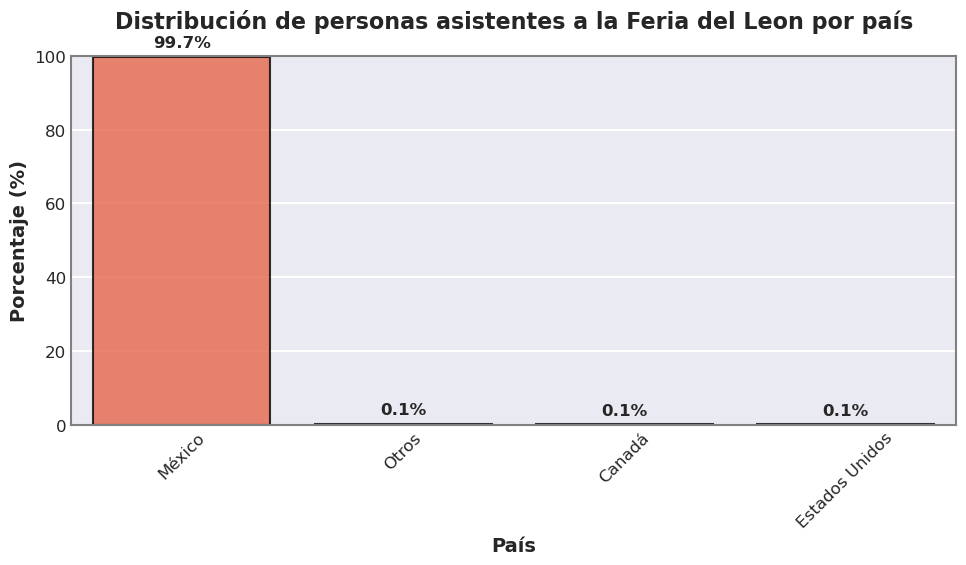

In [1293]:
# Distribución de personas por país
plot_category_percentages(
    data, 
    column='country', 
    title="Distribución de personas asistentes a la Feria del Leon por país", 
    xlabel="País", 
    ylabel="Porcentaje (%)", 
    figsize=(10,6), 
    rotation=45, 
    ha='center', 
    use_hue=True,
    dodge=False
)

/tmp/ipykernel_4485/3021432347.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_4485/3021432347.py:52: UserWarning: 
The palette list has fewer values (3) than needed (18) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(


<Axes: title={'center': 'Distribución de personas asistentes a la Feria del Leon por Estado'}, xlabel='Estado', ylabel='Porcentaje (%)'>

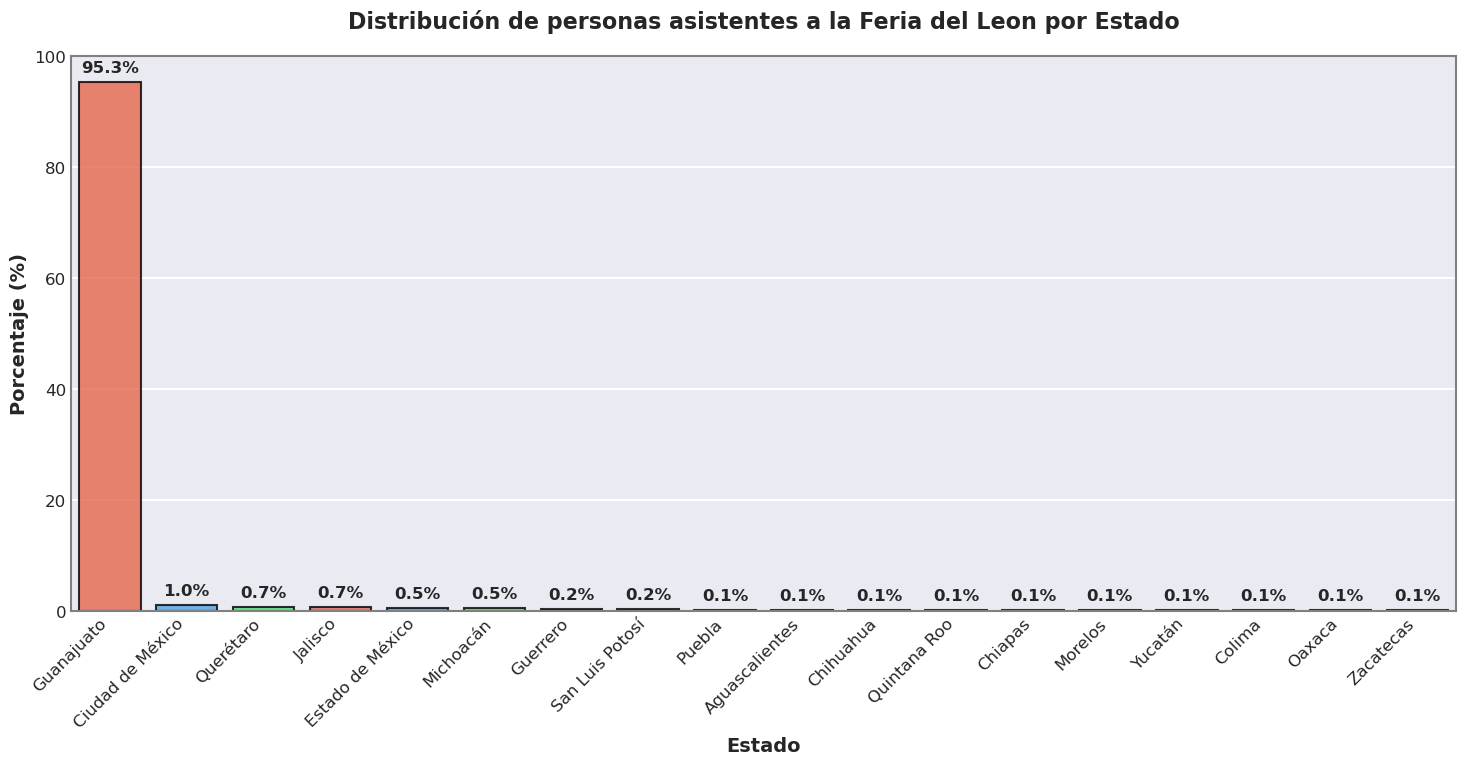

In [1294]:
# Distribución de personas por estado
plot_category_percentages(
    data, 
    column='state', 
    title="Distribución de personas asistentes a la Feria del Leon por Estado", 
    xlabel="Estado", 
    ylabel="Porcentaje (%)", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (32) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas asistentes a la Feria del Leon por Municipio'}, xlabel='Municipio', ylabel='Cantidad de Personas'>

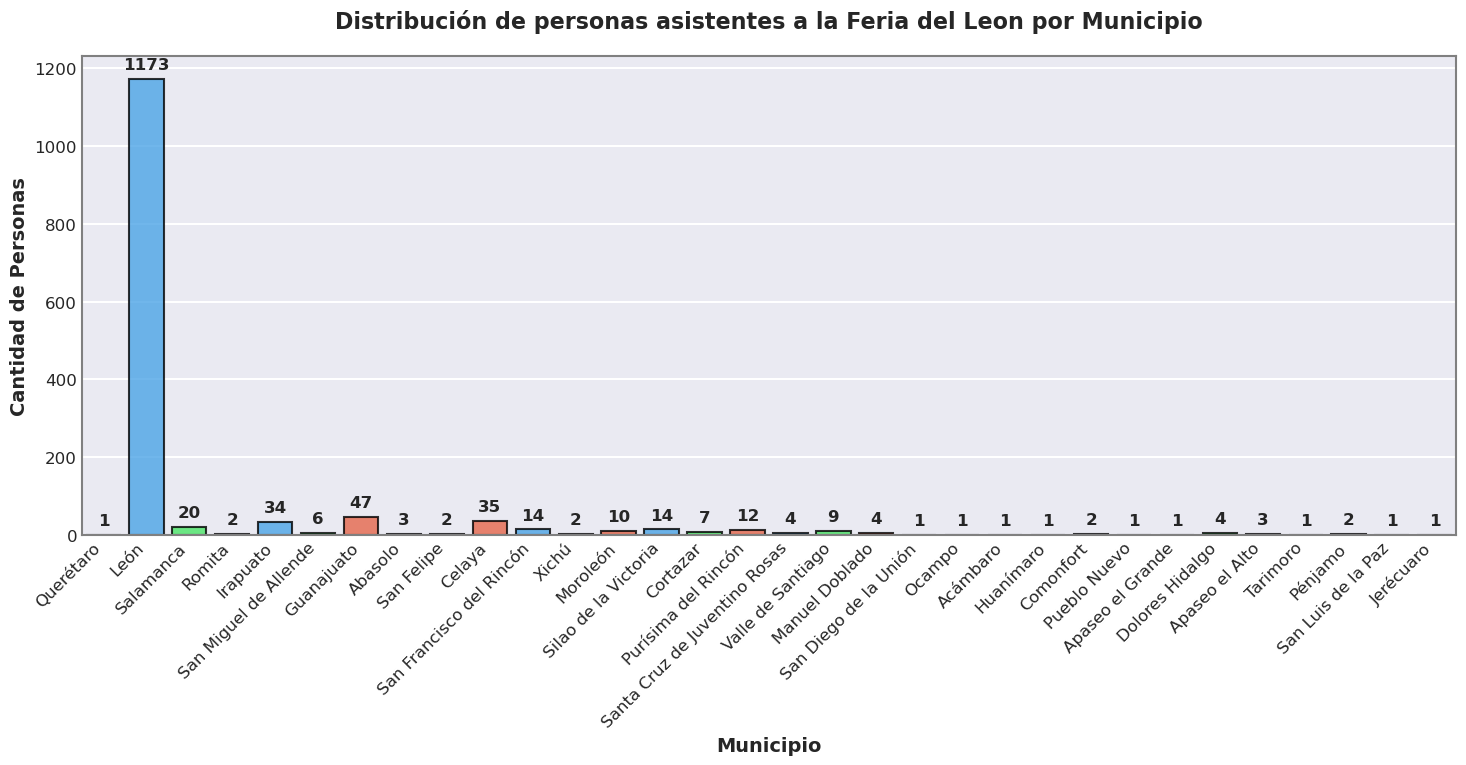

In [1295]:
# Distribución de personas por municipio
plot_category_counts(
    data, 
    column='municipality', 
    title="Distribución de personas asistentes a la Feria del Leon por Municipio", 
    xlabel="Municipio", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

## c. Análisis por sexo y etnicidad

In [1296]:
data.sex.value_counts()

sex
FEMALE    856
MALE      563
Name: count, dtype: int64

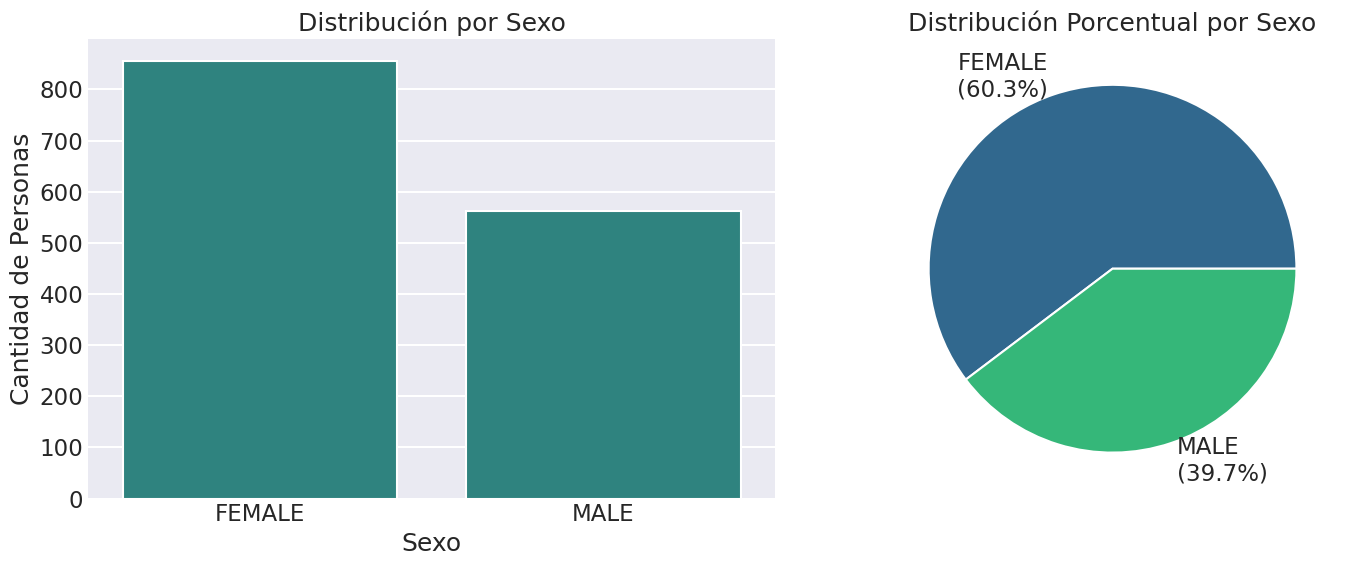


Distribución por sexo:
FEMALE: 856 personas (60.3%)
MALE: 563 personas (39.7%)


In [1297]:
# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de barras para distribución por sexo
sex_counts = data['sex'].value_counts()
single_color = sns.color_palette("viridis", 1)[0]
sns.barplot(
    x=sex_counts.index,
    y=sex_counts.values,
    ax=ax1,
    color=single_color  # Usamos 'color' en lugar de 'palette'
)
ax1.set_title("Distribución por Sexo")
ax1.set_xlabel("Sexo")
ax1.set_ylabel("Cantidad de Personas")

# 2. Gráfico de pastel para la distribución porcentual por sexo
sex_percentages = (sex_counts / len(data) * 100).round(1)
ax2.pie(
    sex_percentages,
    labels=[f'{idx}\n({val}%)' for idx, val in sex_percentages.items()],
    autopct='',
    colors=sns.color_palette("viridis", n_colors=len(sex_counts))
)
ax2.set_title("Distribución Porcentual por Sexo")

plt.tight_layout()
plt.show()

print("\nDistribución por sexo:")
for sex, count in sex_counts.items():
    # Se utiliza .at para acceder a un valor escalar sin problemas con los tipos
    percentage = sex_percentages.at[sex]
    print(f"{sex}: {count} personas ({percentage}%)")

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas por Etnicidad'}, xlabel='Etnicidad', ylabel='Cantidad de Personas'>

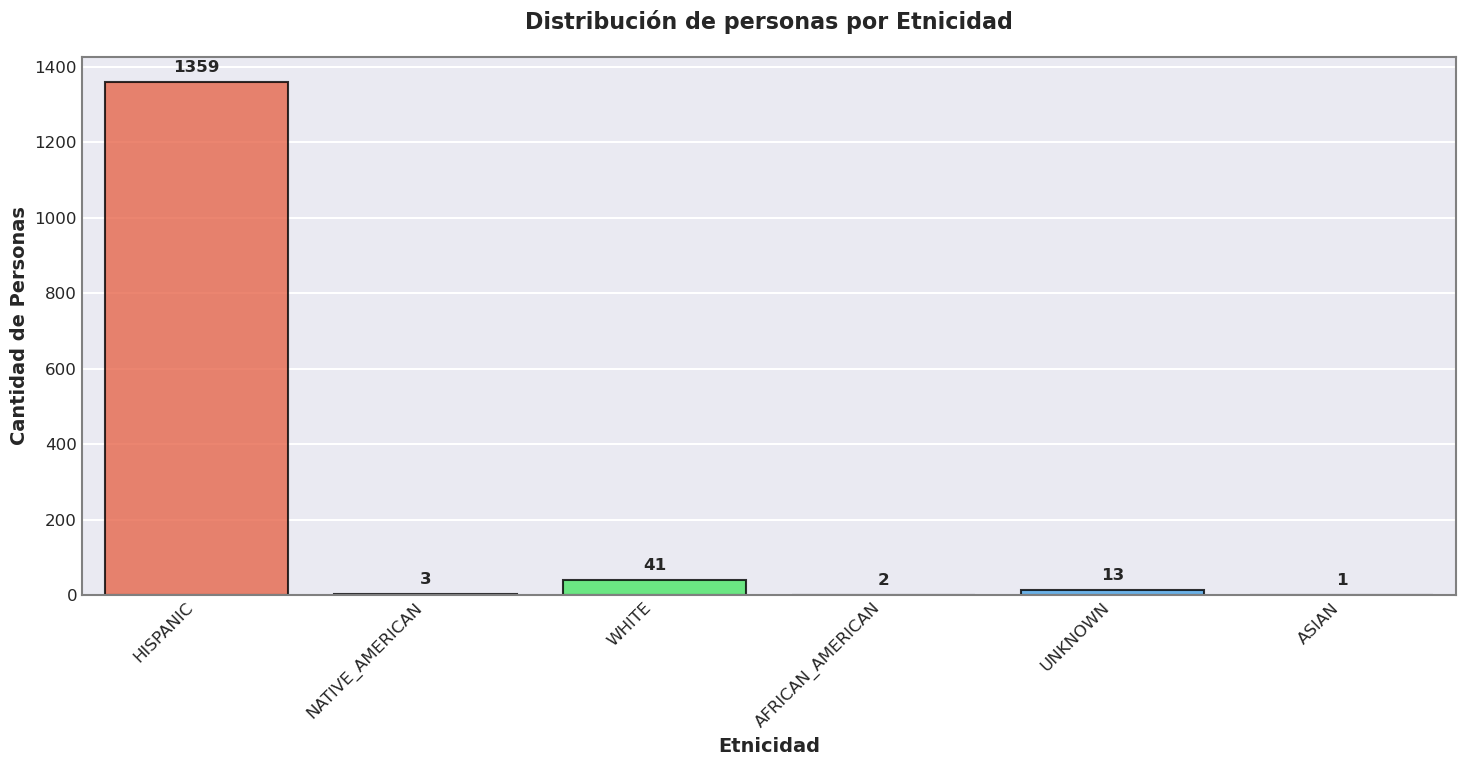

In [1298]:
# Distribución de personas por municipio
plot_category_counts(
    data, 
    column='ethnicity', 
    title="Distribución de personas por Etnicidad", 
    xlabel="Etnicidad", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

## d. Análisis por datos de género

In [1299]:
data.age_at_menarche_years.unique()

array([nan, 'AGE_12_13_YEARS', 'MORE_THAN_13_YEARS', 'AGE_7_11_YEARS',
       'UNKNOWN'], dtype=object)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas por Edad al Primer Periodo Menstrual'}, xlabel='Edad al Primer Periodo Menstrual', ylabel='Cantidad de Personas'>

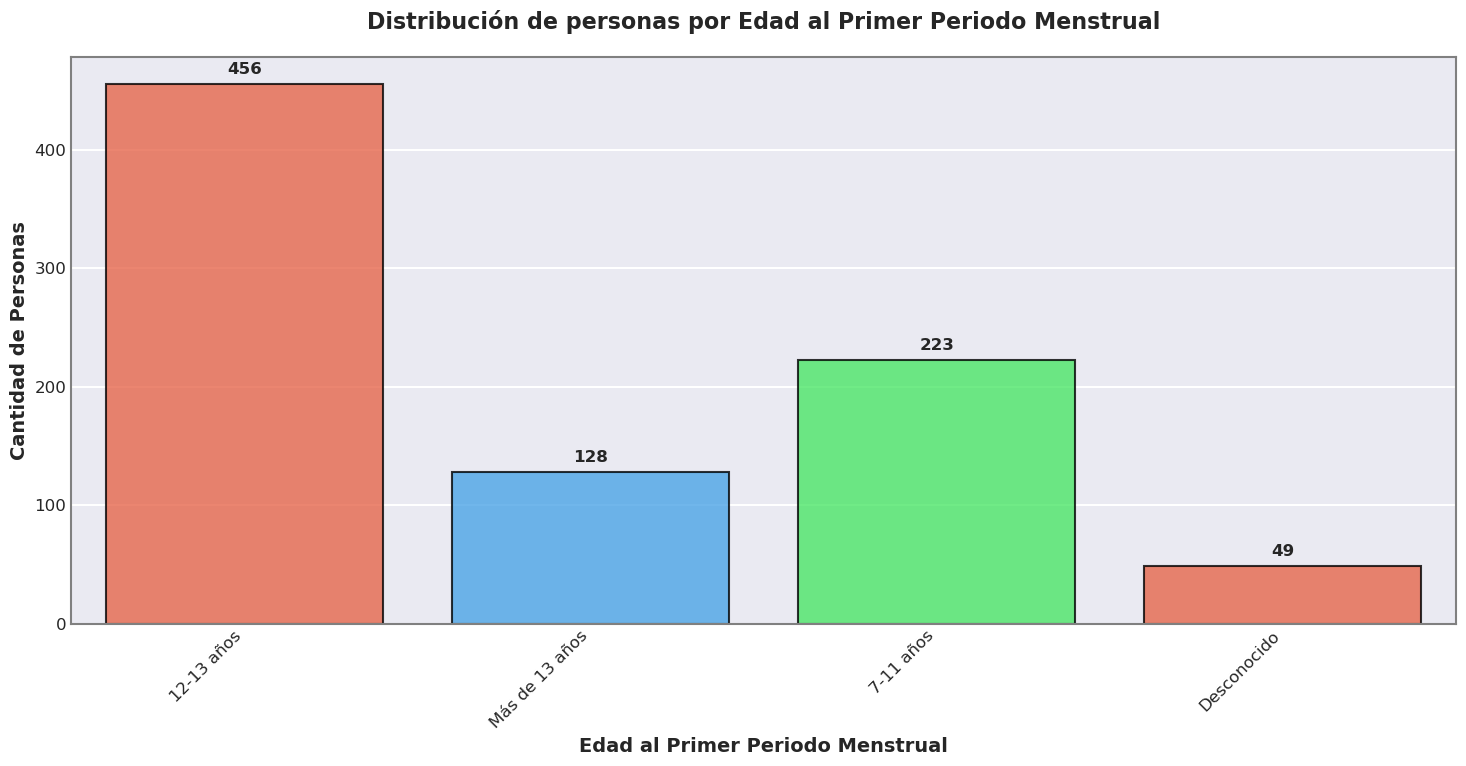

In [1300]:
# Crear un diccionario para mapear los valores en inglés a español
etiquetas_espanol = {
    'AGE_12_13_YEARS': '12-13 años',
    'MORE_THAN_13_YEARS': 'Más de 13 años',
    'AGE_7_11_YEARS': '7-11 años',
    'UNKNOWN': 'Desconocido'
    # nan se manejará automáticamente
}

# Crear una copia de los datos para no modificar el original
data_temp = data.copy()

# Aplicar la traducción
data_temp['age_at_menarche_years'] = data_temp['age_at_menarche_years'].map(lambda x: etiquetas_espanol.get(x, x))

# Usar los datos con etiquetas en español para el gráfico
plot_category_counts(
    data_temp, 
    column='age_at_menarche_years', 
    title="Distribución de personas por Edad al Primer Periodo Menstrual", 
    xlabel="Edad al Primer Periodo Menstrual", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

In [1301]:
data.breast_cancer_first_degree_relatives.unique()


array([nan, 'ONE', 'NONE', 'MORE_THAN_1', 'UNKNOWN'], dtype=object)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas por Familiares con Cáncer de Mama'}, xlabel='Familiares con Cáncer de Mama', ylabel='Cantidad de Personas'>

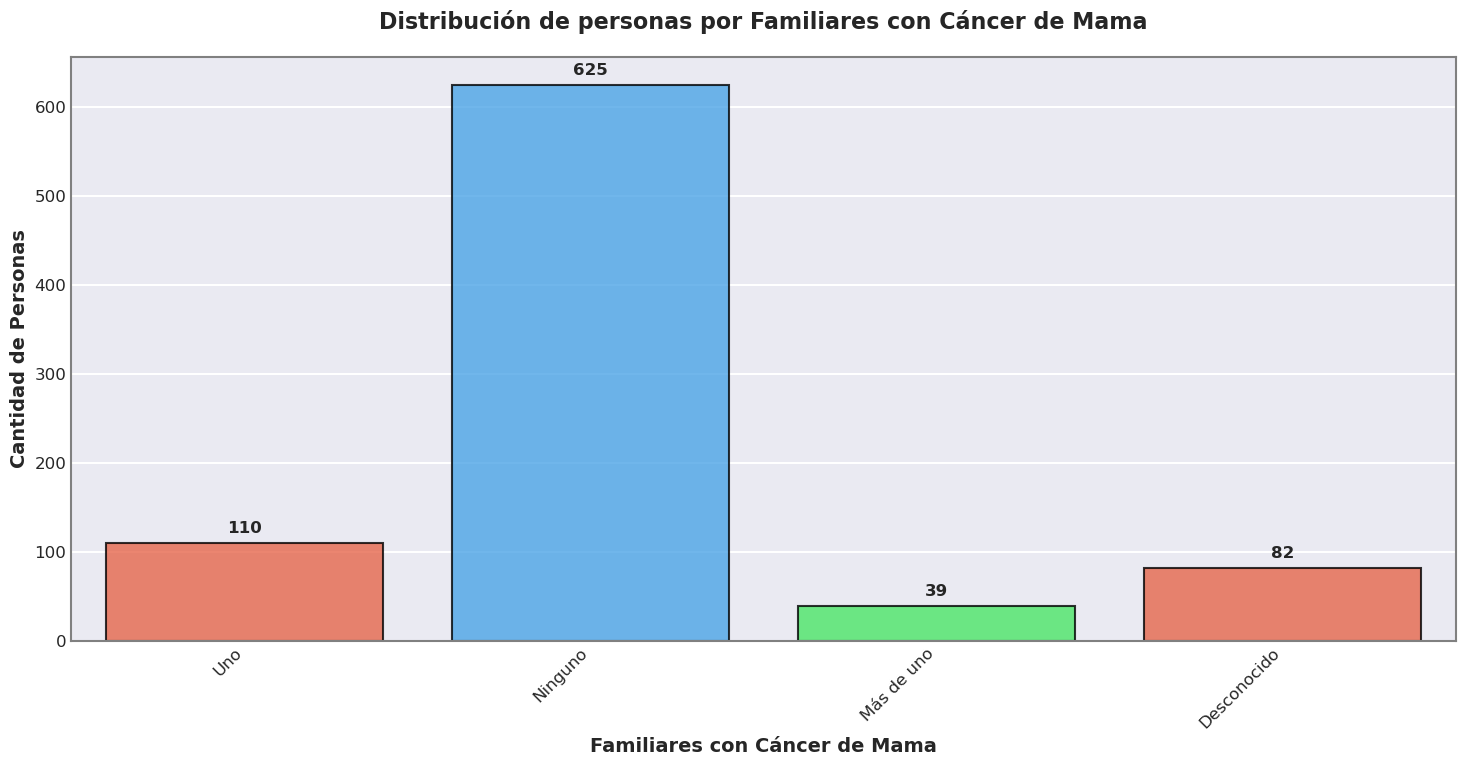

In [1302]:
# Crear un diccionario para mapear los valores en inglés a español
etiquetas_espanol = {
    'ONE': 'Uno',
    'NONE': 'Ninguno',
    'MORE_THAN_1': 'Más de uno',
    'UNKNOWN': 'Desconocido'
    # nan se manejará automáticamente
}

# Crear una copia de los datos para no modificar el original
data_temp = data.copy()

# Aplicar la traducción
data_temp['breast_cancer_first_degree_relatives'] = data_temp['breast_cancer_first_degree_relatives'].map(lambda x: etiquetas_espanol.get(x, x))

# Usar los datos con etiquetas en español para el gráfico
plot_category_counts(
    data_temp, 
    column='breast_cancer_first_degree_relatives', 
    title="Distribución de personas por Familiares con Cáncer de Mama", 
    xlabel="Familiares con Cáncer de Mama", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

In [1303]:
data.maternal_first_birth_age.unique()


array([nan, 'AGE_30_OR_MORE_YEARS', 'AGE_25_29_YEARS', 'NO_CHILDREN',
       'AGE_20_24_YEARS', 'LESS_THAN_20_YEARS', 'UNKNOWN'], dtype=object)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas por Edad al Primer Parto'}, xlabel='Edad al Primer Parto', ylabel='Cantidad de Personas'>

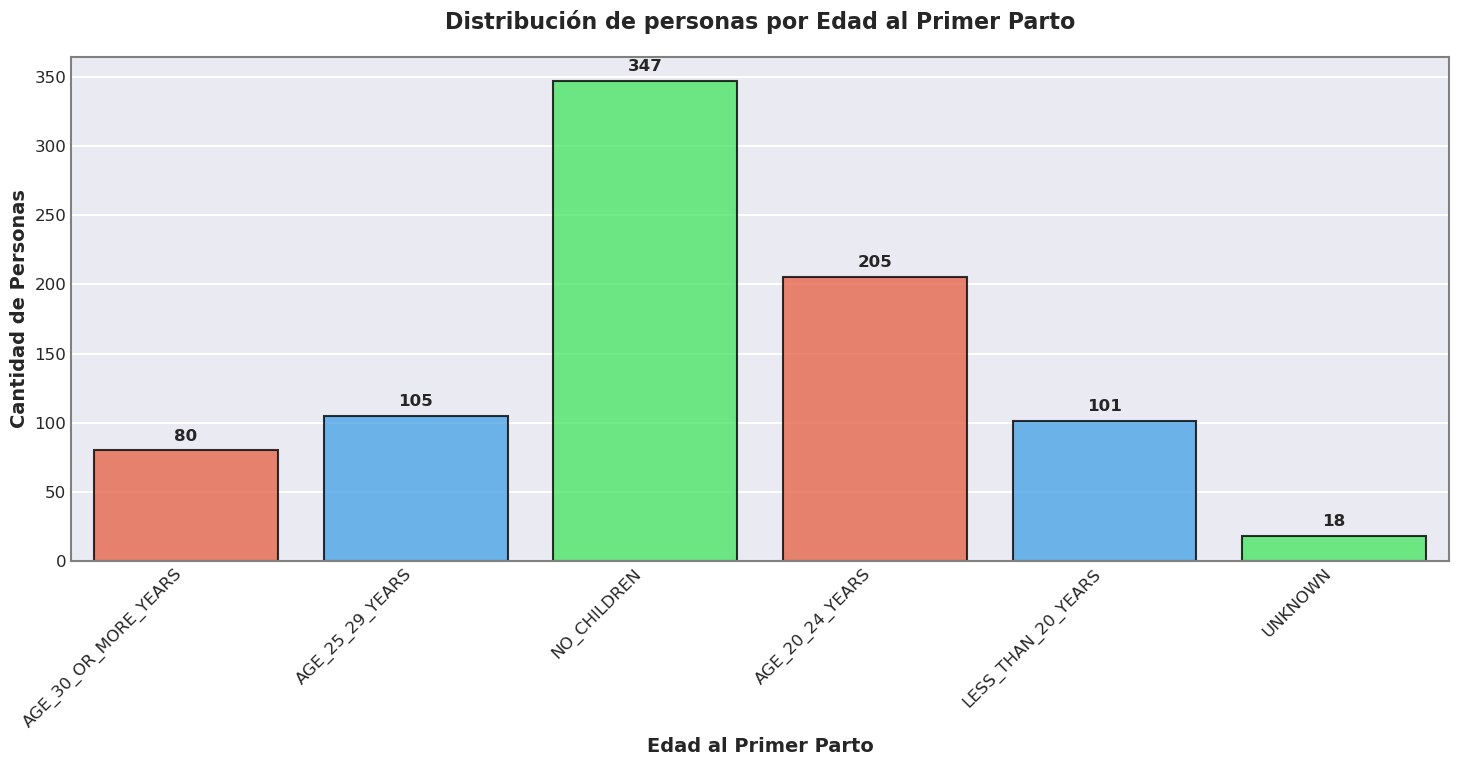

In [1304]:
plot_category_counts(
    data, 
    column='maternal_first_birth_age', 
    title="Distribución de personas por Edad al Primer Parto", 
    xlabel="Edad al Primer Parto", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas por Edad al Primer Parto (mayores de 16 años)'}, xlabel='Edad al Primer Parto', ylabel='Cantidad de Personas'>

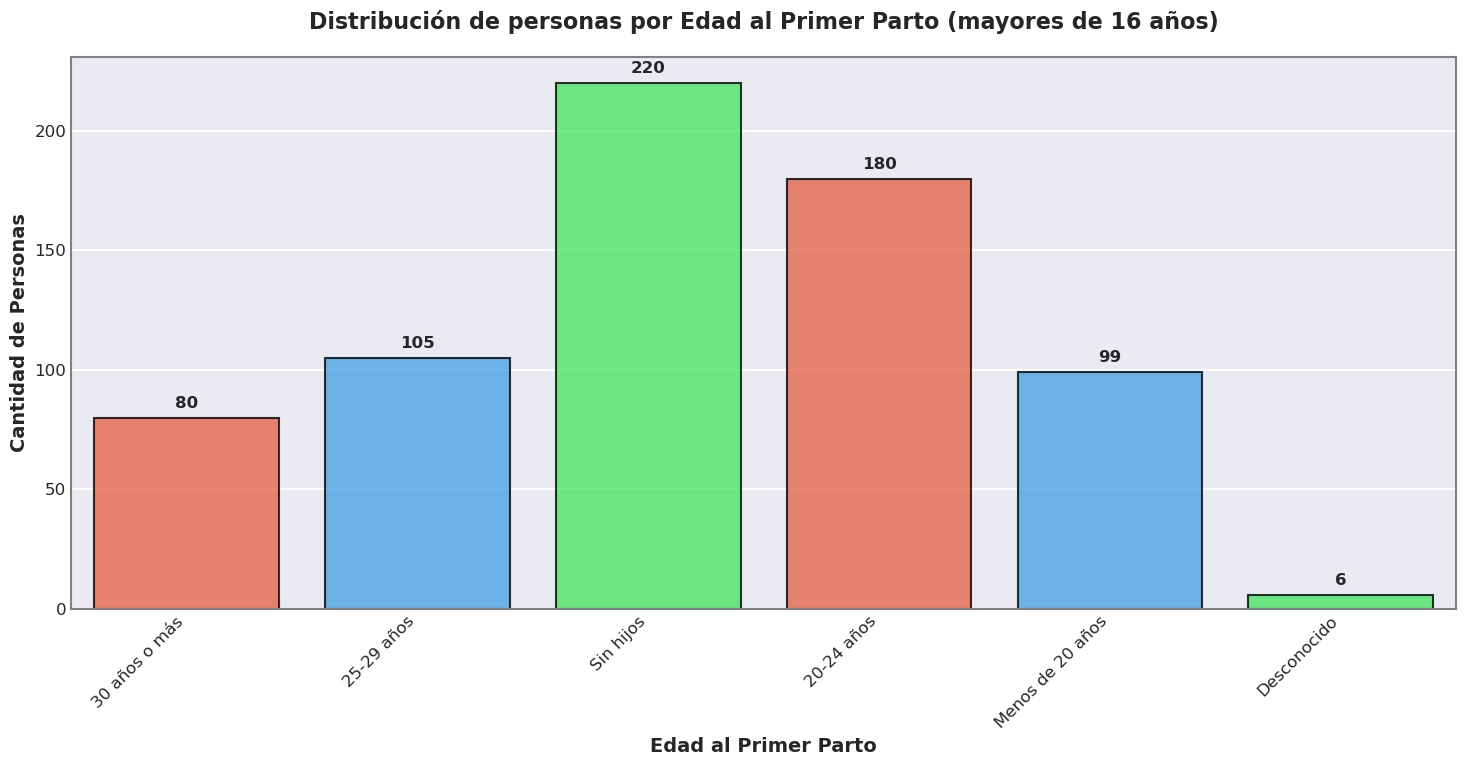

In [1305]:
# Crear un diccionario para mapear los valores en inglés a español
etiquetas_espanol = {
    'AGE_30_OR_MORE_YEARS': '30 años o más',
    'AGE_25_29_YEARS': '25-29 años',
    'NO_CHILDREN': 'Sin hijos',
    'AGE_20_24_YEARS': '20-24 años',
    'LESS_THAN_20_YEARS': 'Menos de 20 años',
    'UNKNOWN': 'Desconocido'
    # nan se manejará automáticamente
}

# Crear una copia de los datos para no modificar el original
data_temp = data.copy()

# Filtrar solo personas mayores de 16 años
data_temp = data_temp[data_temp['age_years'] > 16]

# Aplicar la traducción
data_temp['maternal_first_birth_age'] = data_temp['maternal_first_birth_age'].map(lambda x: etiquetas_espanol.get(x, x))

# Usar los datos con etiquetas en español para el gráfico
plot_category_counts(
    data_temp, 
    column='maternal_first_birth_age', 
    title="Distribución de personas por Edad al Primer Parto (mayores de 16 años)", 
    xlabel="Edad al Primer Parto", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/71272496.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)


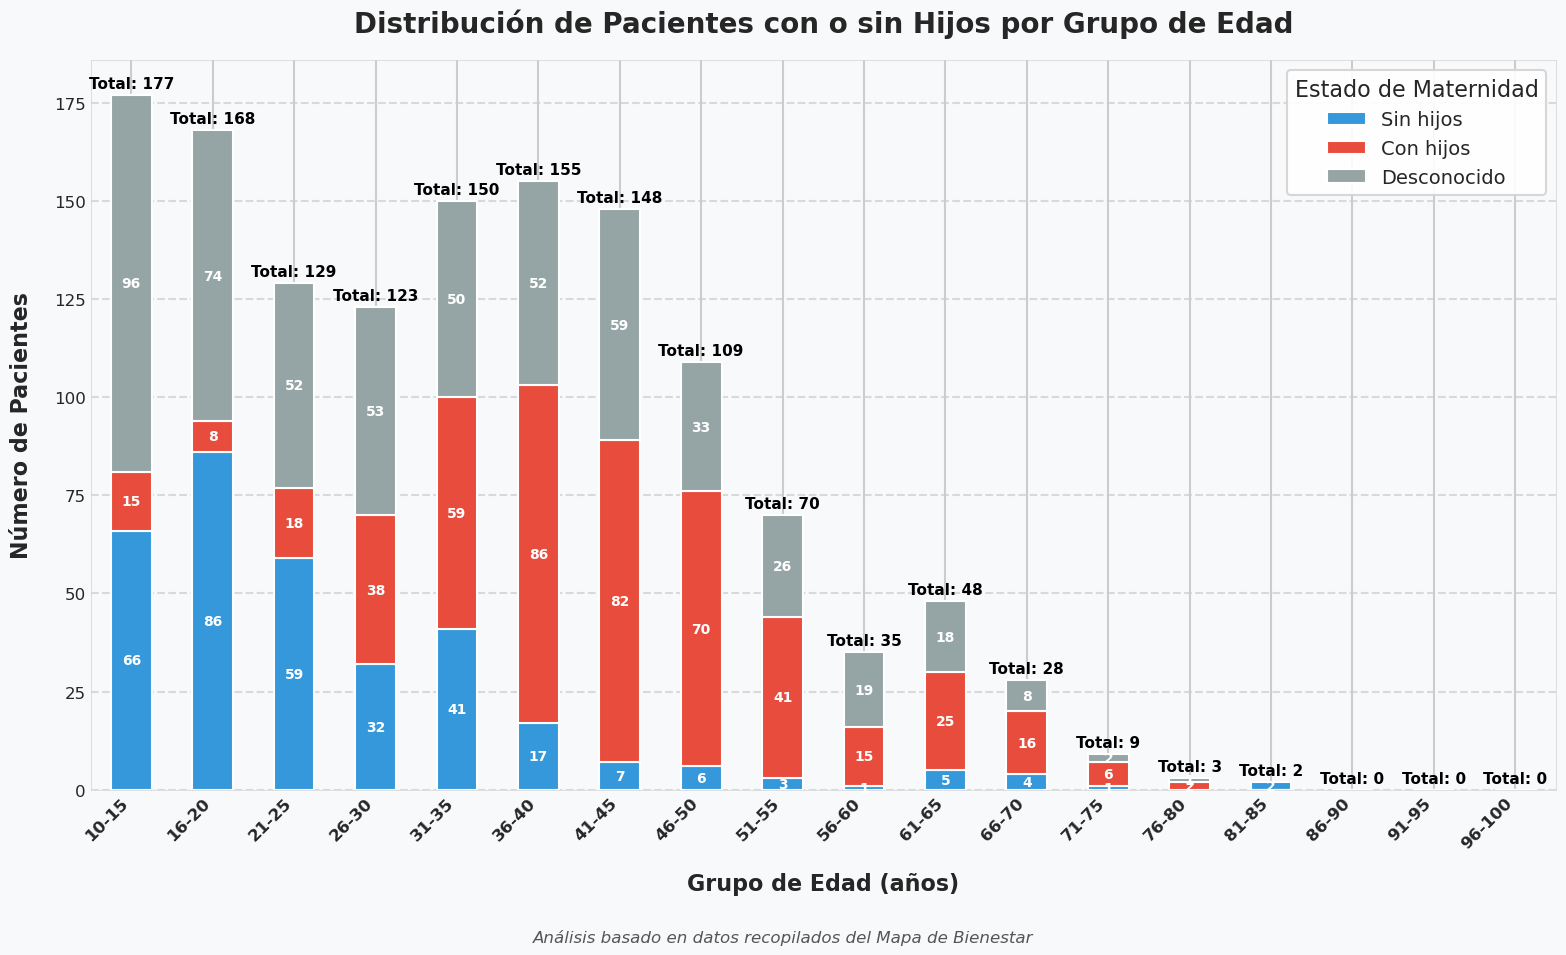

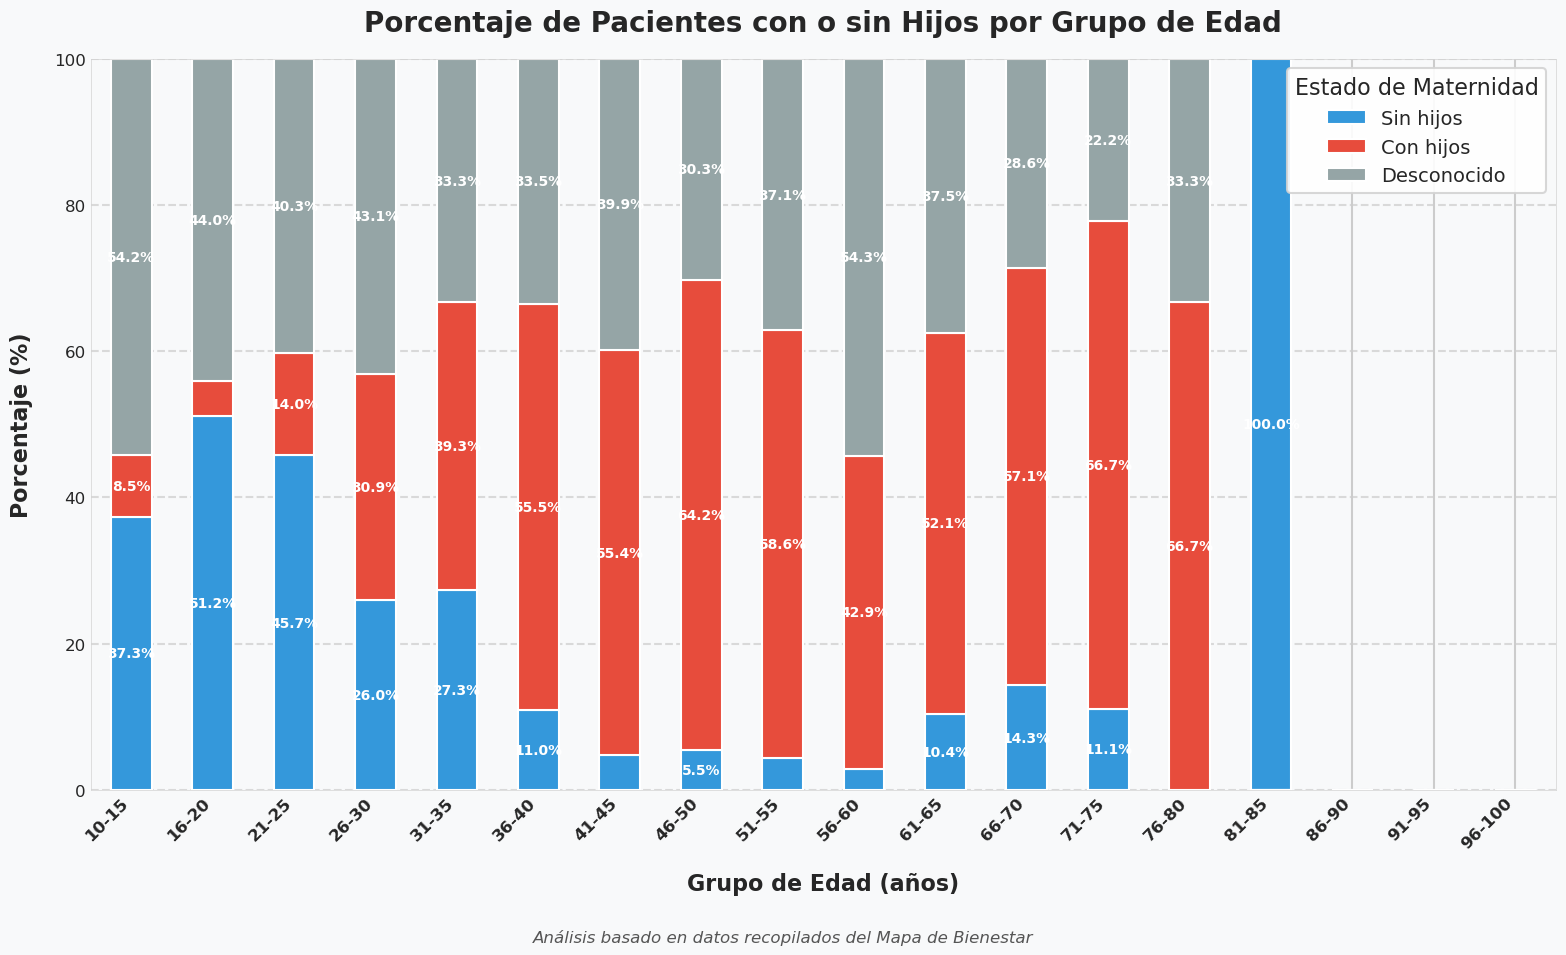

In [1306]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos
data_temp = data.copy()

# Crear grupos de edad (bins)
bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['10-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', 
          '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100']

# Asignar cada persona a un grupo de edad
data_temp['grupo_edad'] = pd.cut(data_temp['age_years'], bins=bins, labels=labels, right=False)

# Crear una columna simplificada para "con hijos" o "sin hijos"
data_temp['tiene_hijos'] = data_temp['maternal_first_birth_age'].apply(
    lambda x: 'Sin hijos' if x == 'NO_CHILDREN' else 
              ('Con hijos' if x in ['AGE_30_OR_MORE_YEARS', 'AGE_25_29_YEARS', 
                                   'AGE_20_24_YEARS', 'LESS_THAN_20_YEARS'] 
               else 'Desconocido')
)

# Eliminar filas con valores nulos en grupo_edad o tiene_hijos
data_filtered = data_temp.dropna(subset=['grupo_edad', 'tiene_hijos'])

# Contar la cantidad de personas en cada grupo
grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)

# Si 'Desconocido' está en las columnas, podemos decidir si mostrarlo o no
if 'Desconocido' in grouped_data.columns:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos', 'Desconocido']]
else:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos']]

# Definir una paleta de colores personalizada más atractiva
colors = ["#3498db", "#e74c3c", "#95a5a6"]  # Azul, Rojo, Gris
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=3)

# Crear el gráfico de barras apiladas con mejor estética
fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
grouped_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(grouped_data.columns)])

# Mejorar el título y etiquetas
ax.set_title('Distribución de Pacientes con o sin Hijos por Grupo de Edad', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Grupo de Edad (años)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('Número de Pacientes', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks y la leyenda
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Personalizar la leyenda
legend = ax.legend(title='Estado de Maternidad', fontsize=14, title_fontsize=16, 
                  loc='upper right', frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('lightgray')

# Añadir etiquetas con los valores en cada barra
for i, (idx, row) in enumerate(grouped_data.iterrows()):
    total = row.sum()
    for j, col in enumerate(grouped_data.columns):
        value = row[col]
        if value > 0:  # Solo mostrar etiquetas para valores mayores a cero
            # Calcular la posición vertical para la etiqueta
            if j == 0:
                y_pos = value / 2
            else:
                y_pos = sum(row[:j]) + value / 2
            ax.text(i, y_pos, str(int(value)), ha='center', va='center', 
                   fontsize=10, fontweight='bold', color='white')

# Añadir el total encima de cada barra
for i, (idx, row) in enumerate(grouped_data.iterrows()):
    total = row.sum()
    ax.text(i, total + 1, f'Total: {int(total)}', ha='center', va='bottom', 
           fontsize=11, fontweight='bold', color='black')

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

# Gráfico de porcentajes con mejor estética
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
percentage_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(percentage_data.columns)])

# Mejorar el título y etiquetas
ax.set_title('Porcentaje de Pacientes con o sin Hijos por Grupo de Edad', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Grupo de Edad (años)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('Porcentaje (%)', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks y la leyenda
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 100)  # Establecer el límite del eje y de 0 a 100%

# Personalizar la leyenda
legend = ax.legend(title='Estado de Maternidad', fontsize=14, title_fontsize=16, 
                  loc='upper right', frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('lightgray')

# Añadir etiquetas con los porcentajes en cada barra
for i, (idx, row) in enumerate(percentage_data.iterrows()):
    cumulative = 0
    for j, col in enumerate(percentage_data.columns):
        value = row[col]
        if value > 5:  # Solo mostrar etiquetas para valores mayores a 5%
            ax.text(i, cumulative + value/2, f'{value:.1f}%', ha='center', va='center', 
                   fontsize=10, fontweight='bold', color='white')
        cumulative += value

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_4485/1611402837.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)


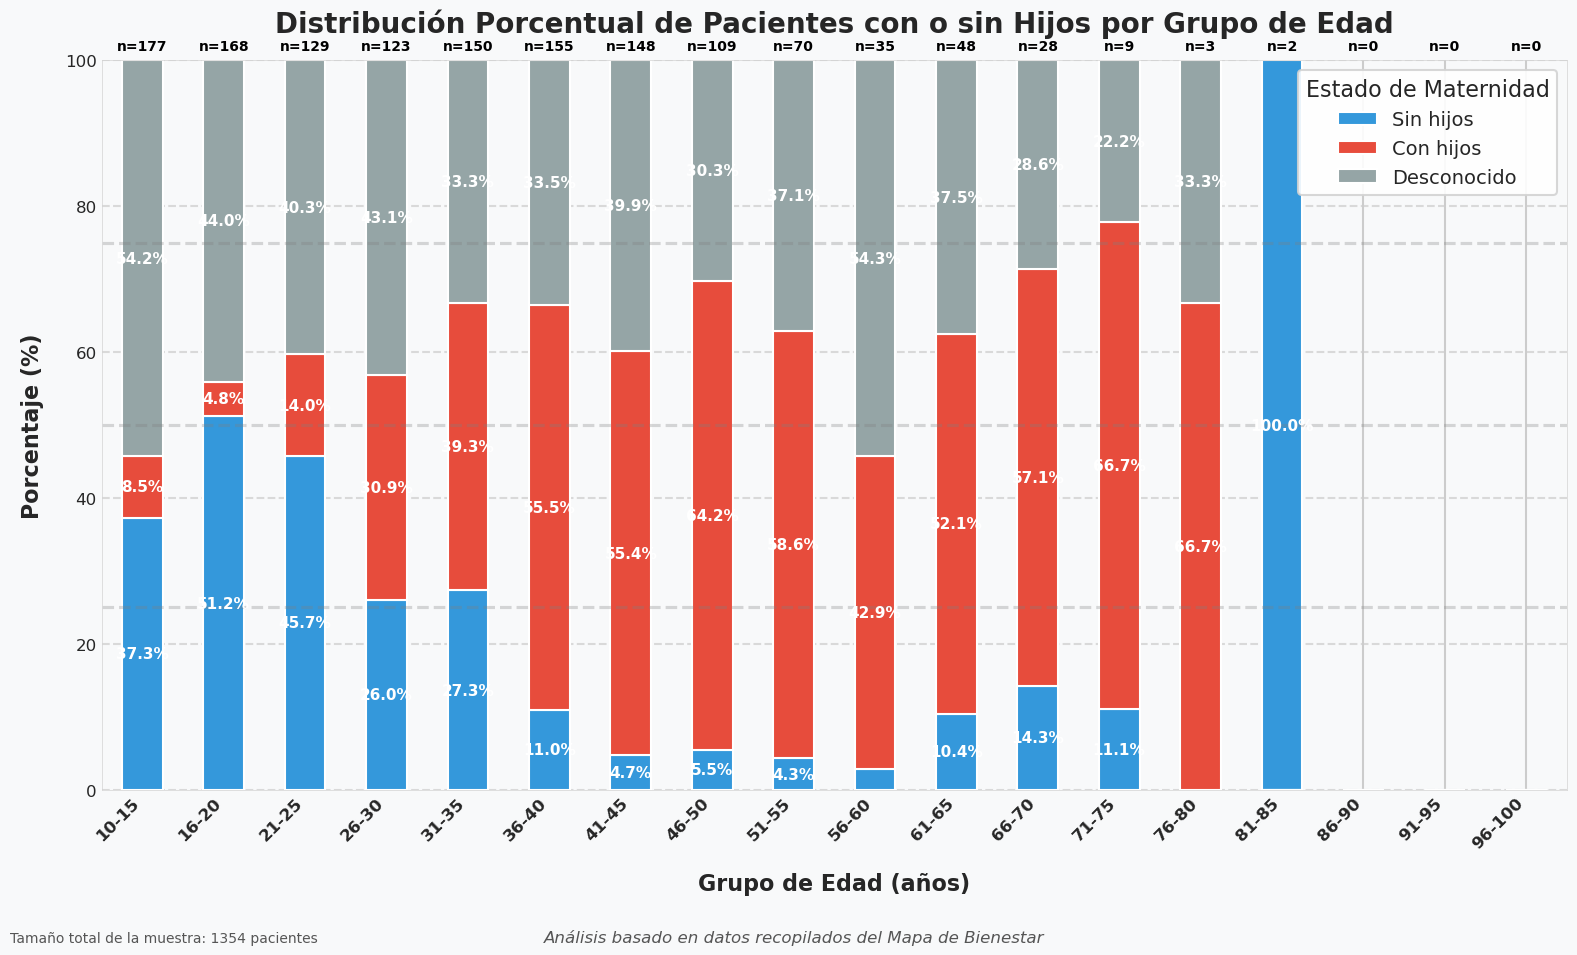

Distribución porcentual por grupo de edad:
tiene_hijos  Sin hijos  Con hijos  Desconocido
grupo_edad                                    
10-15             37.3        8.5         54.2
16-20             51.2        4.8         44.0
21-25             45.7       14.0         40.3
26-30             26.0       30.9         43.1
31-35             27.3       39.3         33.3
36-40             11.0       55.5         33.5
41-45              4.7       55.4         39.9
46-50              5.5       64.2         30.3
51-55              4.3       58.6         37.1
56-60              2.9       42.9         54.3
61-65             10.4       52.1         37.5
66-70             14.3       57.1         28.6
71-75             11.1       66.7         22.2
76-80              0.0       66.7         33.3
81-85            100.0        0.0          0.0
86-90              NaN        NaN          NaN
91-95              NaN        NaN          NaN
96-100             NaN        NaN          NaN

Número de pacien

In [1307]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos
data_temp = data.copy()

# Crear grupos de edad (bins)
bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['10-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', 
          '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100']

# Asignar cada persona a un grupo de edad
data_temp['grupo_edad'] = pd.cut(data_temp['age_years'], bins=bins, labels=labels, right=False)

# Crear una columna simplificada para "con hijos" o "sin hijos"
data_temp['tiene_hijos'] = data_temp['maternal_first_birth_age'].apply(
    lambda x: 'Sin hijos' if x == 'NO_CHILDREN' else 
              ('Con hijos' if x in ['AGE_30_OR_MORE_YEARS', 'AGE_25_29_YEARS', 
                                   'AGE_20_24_YEARS', 'LESS_THAN_20_YEARS'] 
               else 'Desconocido')
)

# Eliminar filas con valores nulos en grupo_edad o tiene_hijos
data_filtered = data_temp.dropna(subset=['grupo_edad', 'tiene_hijos'])

# Contar la cantidad de personas en cada grupo
grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)

# Si 'Desconocido' está en las columnas, podemos decidir si mostrarlo o no
if 'Desconocido' in grouped_data.columns:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos', 'Desconocido']]
else:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos']]

# Calcular los porcentajes
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Definir una paleta de colores personalizada más atractiva
colors = ["#3498db", "#e74c3c", "#95a5a6"]  # Azul, Rojo, Gris
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=3)

# Crear el gráfico de barras apiladas con mejor estética
fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
percentage_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(percentage_data.columns)])

# Mejorar el título y etiquetas
ax.set_title('Distribución Porcentual de Pacientes con o sin Hijos por Grupo de Edad', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Grupo de Edad (años)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('Porcentaje (%)', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks y la leyenda
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 100)  # Establecer el límite del eje y de 0 a 100%

# Personalizar la leyenda
legend = ax.legend(title='Estado de Maternidad', fontsize=14, title_fontsize=16, 
                  loc='upper right', frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('lightgray')

# Añadir etiquetas con los porcentajes en cada barra
for i, (idx, row) in enumerate(percentage_data.iterrows()):
    cumulative = 0
    for j, col in enumerate(percentage_data.columns):
        value = row[col]
        if value > 3:  # Solo mostrar etiquetas para valores mayores a 3%
            ax.text(i, cumulative + value/2, f'{value:.1f}%', ha='center', va='center', 
                   fontsize=11, fontweight='bold', color='white')
        cumulative += value

# Añadir el número total de pacientes en cada grupo como anotación
for i, (idx, row) in enumerate(grouped_data.iterrows()):
    total = row.sum()
    ax.text(i, 101, f'n={int(total)}', ha='center', va='bottom', 
           fontsize=10, fontweight='bold', color='black')

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir líneas horizontales para facilitar la lectura
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=75, color='gray', linestyle='--', alpha=0.3)

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Añadir anotación con el tamaño total de la muestra
total_sample = grouped_data.sum().sum()
plt.figtext(0.01, 0.01, f'Tamaño total de la muestra: {int(total_sample)} pacientes', 
           ha='left', fontsize=10, color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

# Opcional: Crear una tabla con los datos numéricos
print("Distribución porcentual por grupo de edad:")
print(percentage_data.round(1))

print("\nNúmero de pacientes por grupo de edad:")
print(grouped_data)

/tmp/ipykernel_4485/1037476458.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)


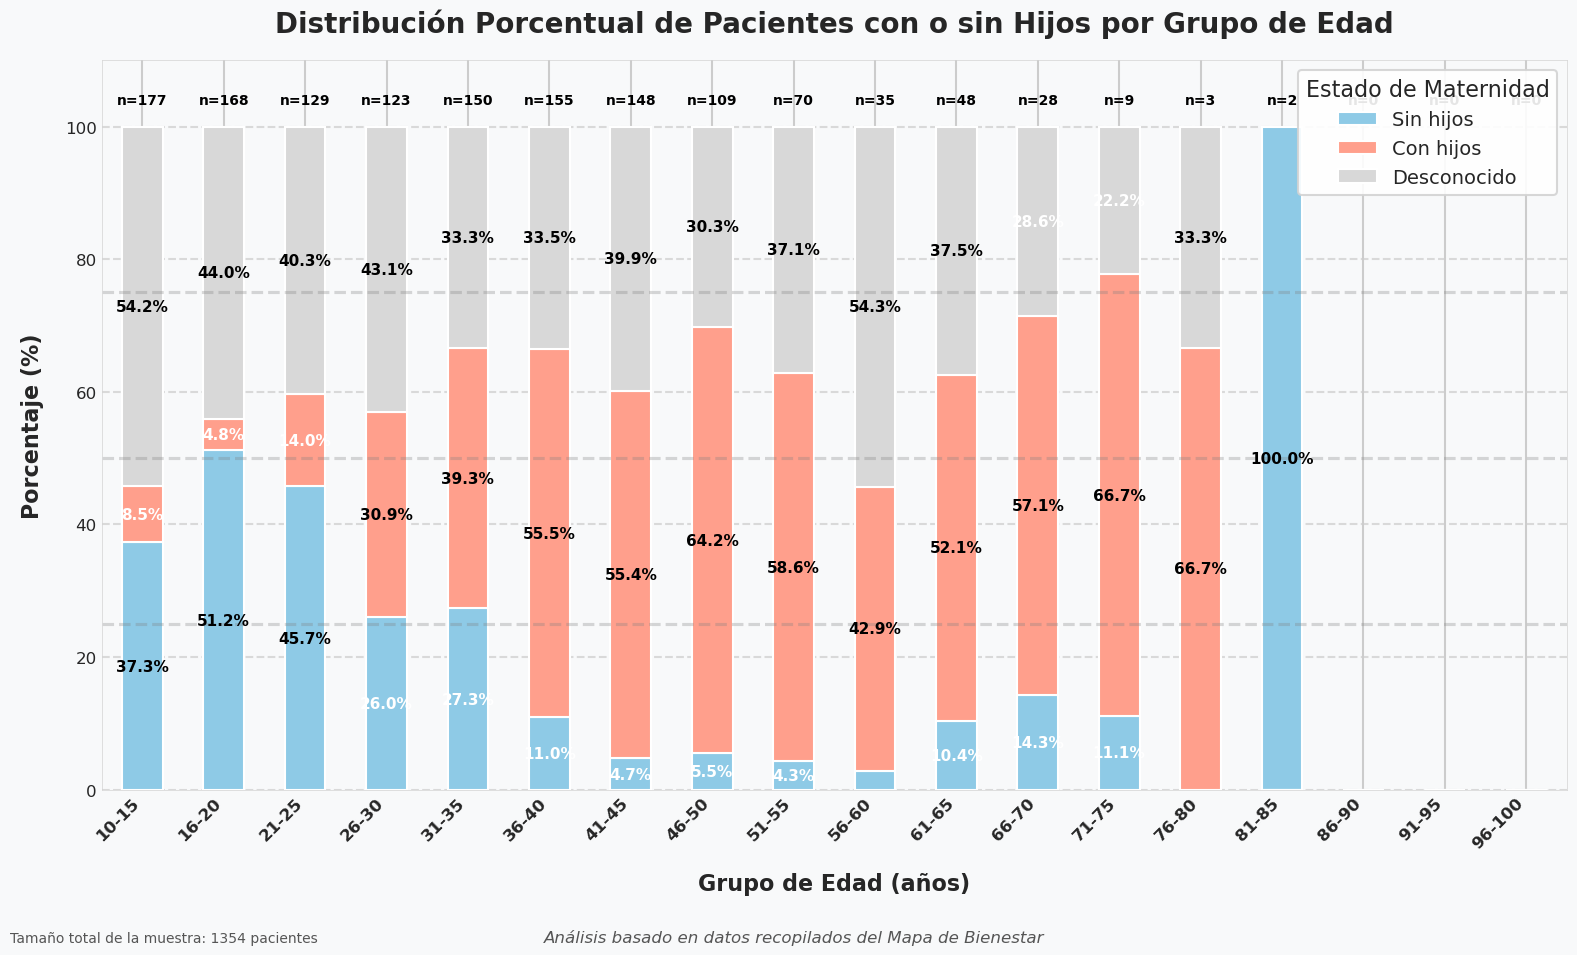

In [1308]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos
data_temp = data.copy()

# Crear grupos de edad (bins)
bins = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['10-15', '16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', 
          '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100']

# Asignar cada persona a un grupo de edad
data_temp['grupo_edad'] = pd.cut(data_temp['age_years'], bins=bins, labels=labels, right=False)

# Crear una columna simplificada para "con hijos" o "sin hijos"
data_temp['tiene_hijos'] = data_temp['maternal_first_birth_age'].apply(
    lambda x: 'Sin hijos' if x == 'NO_CHILDREN' else 
              ('Con hijos' if x in ['AGE_30_OR_MORE_YEARS', 'AGE_25_29_YEARS', 
                                   'AGE_20_24_YEARS', 'LESS_THAN_20_YEARS'] 
               else 'Desconocido')
)

# Eliminar filas con valores nulos en grupo_edad o tiene_hijos
data_filtered = data_temp.dropna(subset=['grupo_edad', 'tiene_hijos'])

# Contar la cantidad de personas en cada grupo
grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)

# Si 'Desconocido' está en las columnas, podemos decidir si mostrarlo o no
if 'Desconocido' in grouped_data.columns:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos', 'Desconocido']]
else:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos']]

# Calcular los porcentajes
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Definir una paleta de colores más adecuada para la temática de maternidad
colors = ["#8ECAE6", "#FF9F8C", "#D8D8D8"]  # Azul pastel, Rosa/Coral, Gris claro
# Alternativa: ["#A8D5BA", "#F08080", "#D8D8D8"]  # Verde menta, Rosa coral, Gris claro

# Crear el gráfico de barras apiladas con mejor estética
fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
percentage_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(percentage_data.columns)])

# Mejorar el título y etiquetas
ax.set_title('Distribución Porcentual de Pacientes con o sin Hijos por Grupo de Edad', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Grupo de Edad (años)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('Porcentaje (%)', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks y la leyenda
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 110)  # Aumentar el límite para que los porcentajes no se corten

# Personalizar la leyenda
legend = ax.legend(title='Estado de Maternidad', fontsize=14, title_fontsize=16, 
                  loc='upper right', frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('lightgray')

# Función para determinar el color del texto basado en el fondo
def get_text_color(value):
    return 'black' if value > 30 else 'white'

# Añadir etiquetas con los porcentajes en cada barra
for i, (idx, row) in enumerate(percentage_data.iterrows()):
    cumulative = 0
    for j, col in enumerate(percentage_data.columns):
        value = row[col]
        if value > 3:  # Solo mostrar etiquetas para valores mayores a 3%
            # Determinar el color del texto basado en el valor
            text_color = get_text_color(value)
            ax.text(i, cumulative + value/2, f'{value:.1f}%', ha='center', va='center', 
                   fontsize=11, fontweight='bold', color=text_color)
        cumulative += value

# Añadir el número total de pacientes en cada grupo como anotación
for i, (idx, row) in enumerate(grouped_data.iterrows()):
    total = row.sum()
    ax.text(i, 103, f'n={int(total)}', ha='center', va='bottom', 
           fontsize=10, fontweight='bold', color='black')

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir líneas horizontales para facilitar la lectura
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=75, color='gray', linestyle='--', alpha=0.3)

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Añadir anotación con el tamaño total de la muestra
total_sample = grouped_data.sum().sum()
plt.figtext(0.01, 0.01, f'Tamaño total de la muestra: {int(total_sample)} pacientes', 
           ha='left', fontsize=10, color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_4485/2249962051.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)


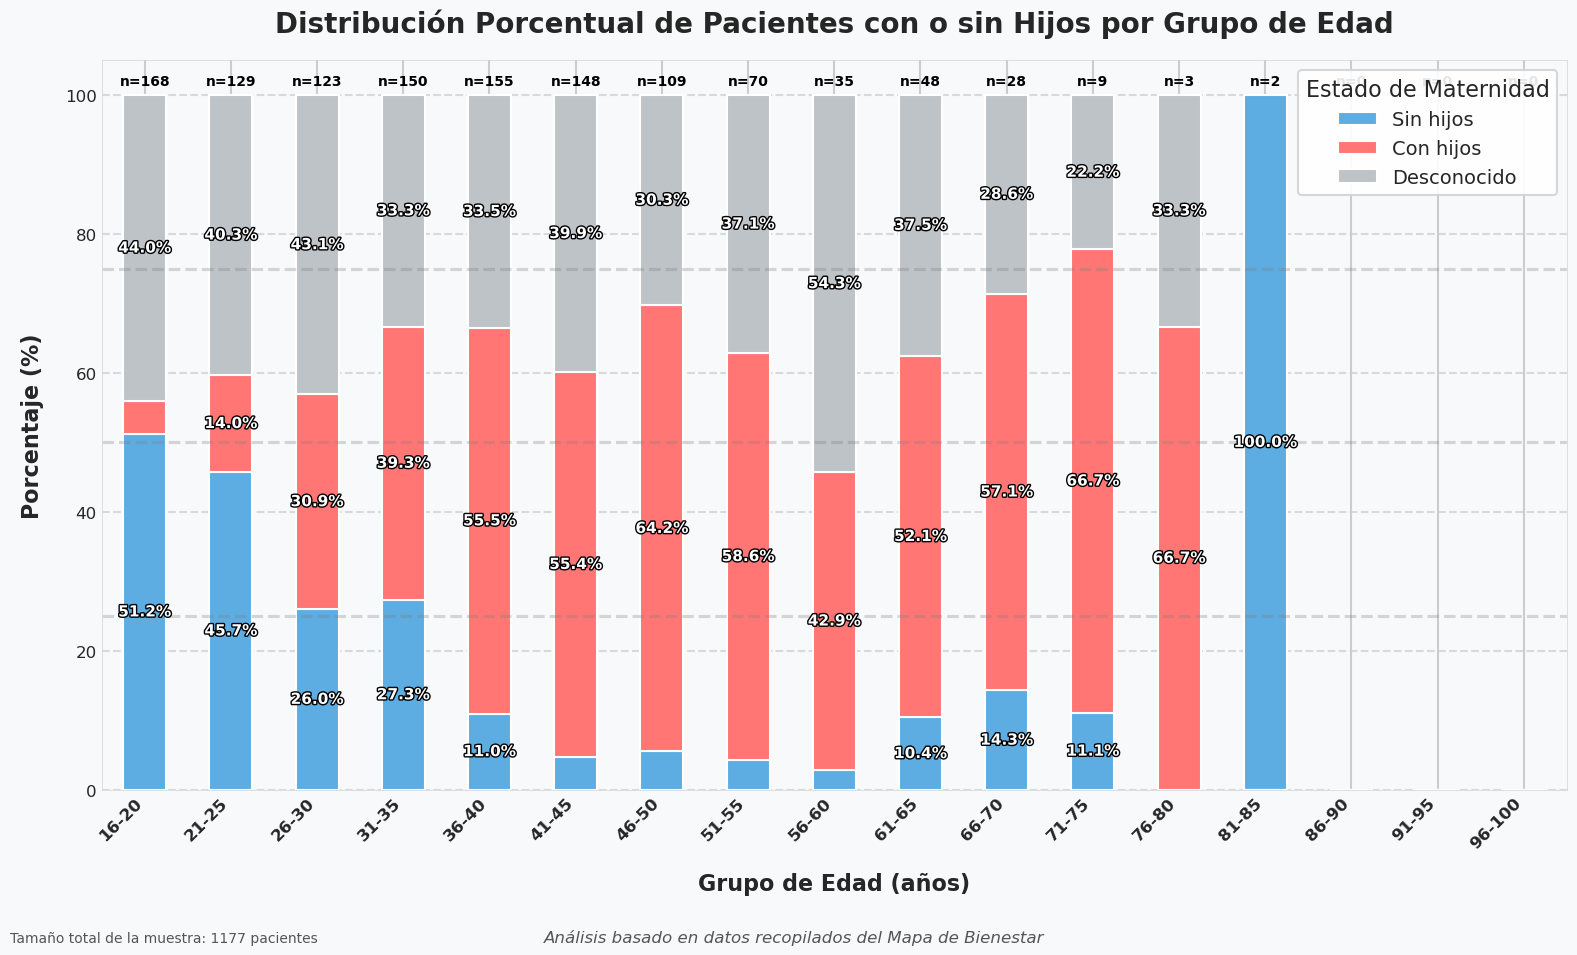

In [1309]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as path_effects

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos
data_temp = data.copy()

# Crear grupos de edad (bins)
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['16-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', 
          '51-55', '56-60', '61-65', '66-70', '71-75', '76-80', '81-85', '86-90', '91-95', '96-100']

# Asignar cada persona a un grupo de edad
data_temp['grupo_edad'] = pd.cut(data_temp['age_years'], bins=bins, labels=labels, right=False)

# Crear una columna simplificada para "con hijos" o "sin hijos"
data_temp['tiene_hijos'] = data_temp['maternal_first_birth_age'].apply(
    lambda x: 'Sin hijos' if x == 'NO_CHILDREN' else 
              ('Con hijos' if x in ['AGE_30_OR_MORE_YEARS', 'AGE_25_29_YEARS', 
                                   'AGE_20_24_YEARS', 'LESS_THAN_20_YEARS'] 
               else 'Desconocido')
)

# Eliminar filas con valores nulos en grupo_edad o tiene_hijos
data_filtered = data_temp.dropna(subset=['grupo_edad', 'tiene_hijos'])

# Contar la cantidad de personas en cada grupo
grouped_data = data_filtered.groupby(['grupo_edad', 'tiene_hijos']).size().unstack(fill_value=0)

# Si 'Desconocido' está en las columnas, podemos decidir si mostrarlo o no
if 'Desconocido' in grouped_data.columns:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos', 'Desconocido']]
else:
    grouped_data = grouped_data[['Sin hijos', 'Con hijos']]

# Calcular los porcentajes
percentage_data = grouped_data.div(grouped_data.sum(axis=1), axis=0) * 100

# Definir una paleta de colores más adecuada para la temática de maternidad
# Usar colores más oscuros para mejorar el contraste con el texto
colors = ["#5DADE2", "#FF7675", "#BDC3C7"]  # Azul más oscuro, Rosa más oscuro, Gris medio

# Crear el gráfico de barras apiladas con mejor estética
fig, ax = plt.subplots(figsize=(16, 10), dpi=100)
percentage_data.plot(kind='bar', stacked=True, ax=ax, color=colors[:len(percentage_data.columns)])

# Mejorar el título y etiquetas
ax.set_title('Distribución Porcentual de Pacientes con o sin Hijos por Grupo de Edad', 
             fontsize=20, fontweight='bold', pad=20)
ax.set_xlabel('Grupo de Edad (años)', fontsize=16, fontweight='bold', labelpad=15)
ax.set_ylabel('Porcentaje (%)', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks y la leyenda
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontweight='bold')
ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_ylim(0, 105)  # Ajustar el límite para que los porcentajes no se salgan

# Personalizar la leyenda
legend = ax.legend(title='Estado de Maternidad', fontsize=14, title_fontsize=16, 
                  loc='upper right', frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('lightgray')

# Función para determinar si un segmento es lo suficientemente grande para mostrar texto
def is_segment_large_enough(value):
    return value >= 8  # Solo mostrar texto en segmentos de al menos 8%

# Añadir etiquetas con los porcentajes en cada barra con mejor contraste
for i, (idx, row) in enumerate(percentage_data.iterrows()):
    cumulative = 0
    for j, col in enumerate(percentage_data.columns):
        value = row[col]
        if is_segment_large_enough(value):  # Solo mostrar etiquetas en segmentos suficientemente grandes
            # Añadir texto con contorno para mejorar visibilidad
            text = ax.text(i, cumulative + value/2, f'{value:.1f}%', 
                          ha='center', va='center', fontsize=11, fontweight='bold', color='white')
            
            # Añadir contorno negro al texto para mejorar contraste
            text.set_path_effects([
                path_effects.Stroke(linewidth=2, foreground='black'),
                path_effects.Normal()
            ])
        cumulative += value

# Añadir el número total de pacientes en cada grupo como anotación
for i, (idx, row) in enumerate(grouped_data.iterrows()):
    total = row.sum()
    ax.text(i, 101, f'n={int(total)}', ha='center', va='bottom', 
           fontsize=10, fontweight='bold', color='black')

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir líneas horizontales para facilitar la lectura
ax.axhline(y=25, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.3)
ax.axhline(y=75, color='gray', linestyle='--', alpha=0.3)

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Añadir anotación con el tamaño total de la muestra
total_sample = grouped_data.sum().sum()
plt.figtext(0.01, 0.01, f'Tamaño total de la muestra: {int(total_sample)} pacientes', 
           ha='left', fontsize=10, color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas número de biopsias previas'}, xlabel='Número de biopsias previas', ylabel='Cantidad de Personas'>

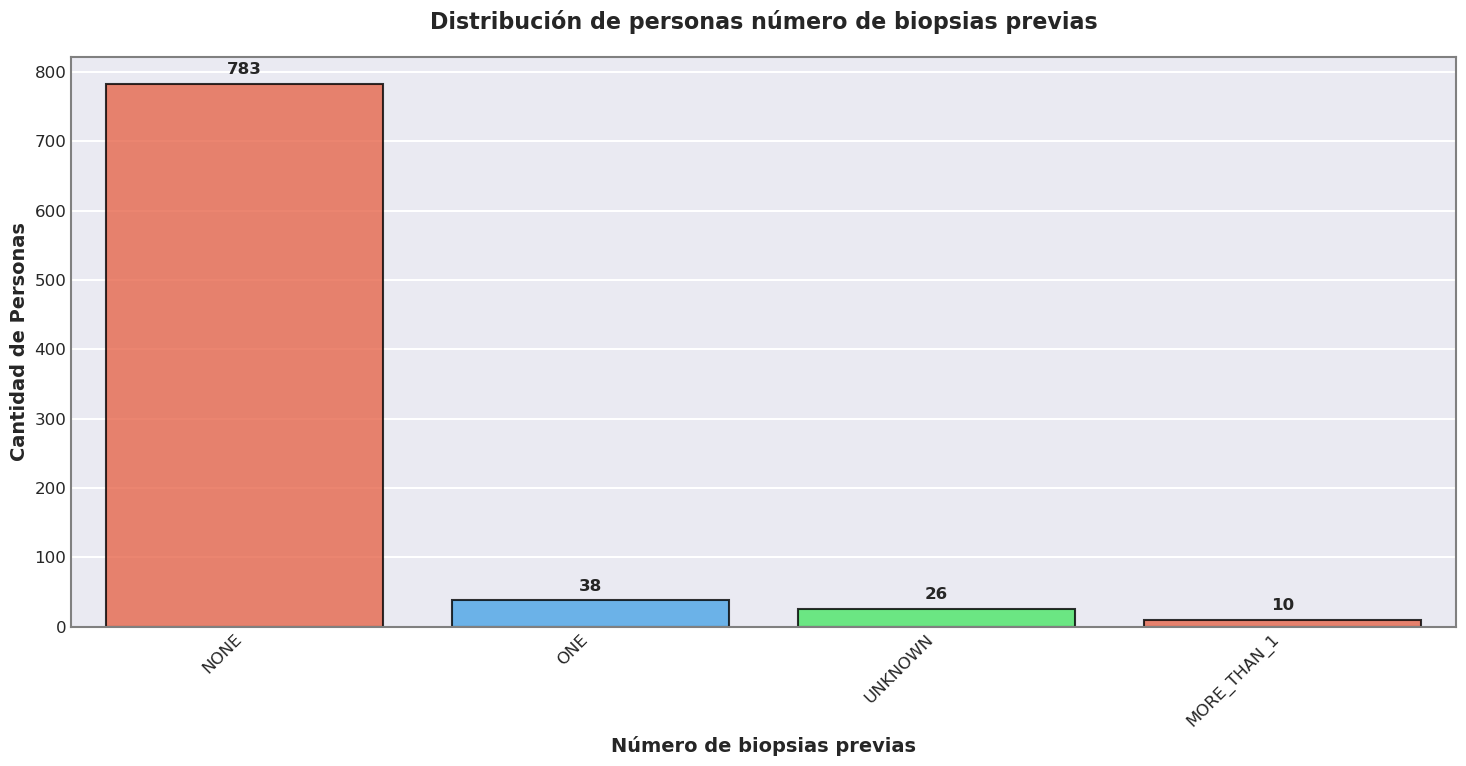

In [1310]:
plot_category_counts(
    data, 
    column='previous_breast_biopsies', 
    title="Distribución de personas número de biopsias previas", 
    xlabel="Número de biopsias previas", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (6) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de personas edad al primer parto'}, xlabel='Edad al primer parto', ylabel='Cantidad de Personas'>

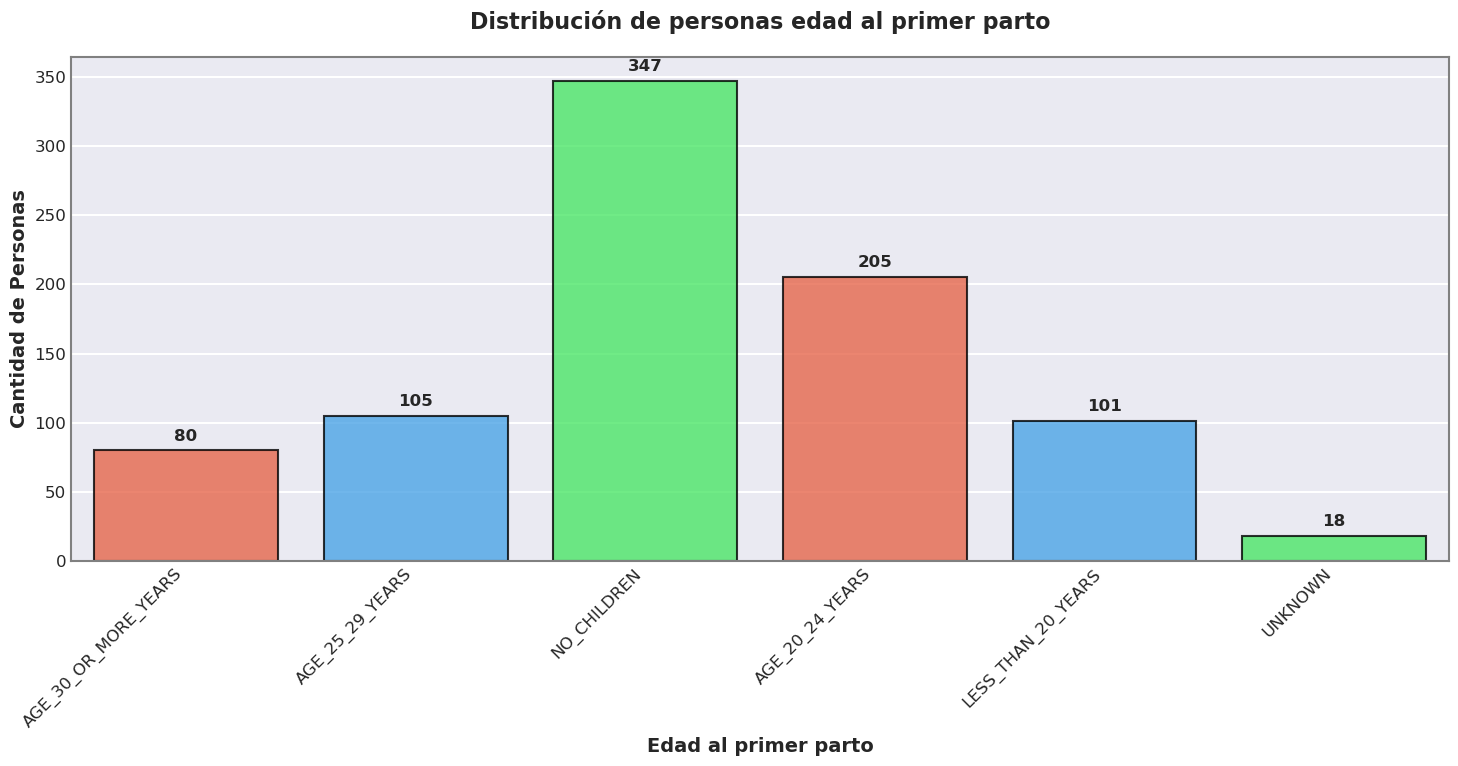

In [1311]:
plot_category_counts(
    data, 
    column='maternal_first_birth_age', 
    title="Distribución de personas edad al primer parto", 
    xlabel="Edad al primer parto", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/1925927963.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors)


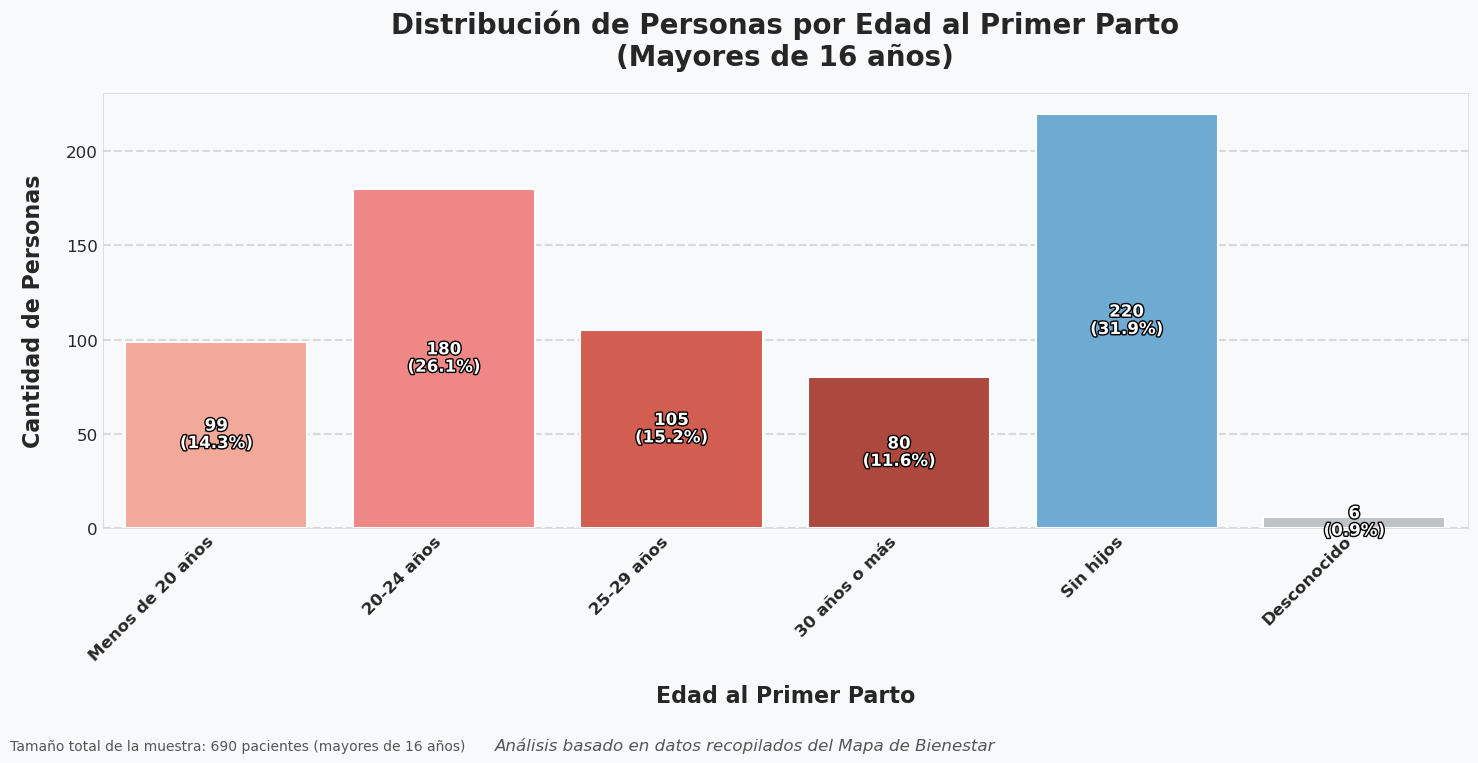

In [1312]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patheffects as path_effects

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos y filtrar mayores de 16 años
data_filtered = data[data['age_years'] > 16].copy()

# Crear un diccionario para mapear los valores en inglés a español
etiquetas_espanol = {
    'AGE_30_OR_MORE_YEARS': '30 años o más',
    'AGE_25_29_YEARS': '25-29 años',
    'NO_CHILDREN': 'Sin hijos',
    'AGE_20_24_YEARS': '20-24 años',
    'LESS_THAN_20_YEARS': 'Menos de 20 años',
    'UNKNOWN': 'Desconocido'
    # nan se manejará automáticamente
}

# Aplicar la traducción
data_filtered['maternal_first_birth_age'] = data_filtered['maternal_first_birth_age'].map(lambda x: etiquetas_espanol.get(x, x))

# Contar la frecuencia de cada categoría
category_counts = data_filtered['maternal_first_birth_age'].value_counts().sort_index()

# Reordenar las categorías en un orden lógico
order = ['Menos de 20 años', '20-24 años', '25-29 años', '30 años o más', 'Sin hijos', 'Desconocido']
category_counts = category_counts.reindex(order)

# Crear una paleta de colores atractiva
colors = ["#FF9F8C", "#FF7675", "#E74C3C", "#C0392B", "#5DADE2", "#BDC3C7"]

# Crear la figura
plt.figure(figsize=(15, 8), dpi=100)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors)

# Añadir etiquetas con los valores y porcentajes
total = category_counts.sum()
for i, (cat, count) in enumerate(category_counts.items()):
    percentage = 100 * count / total
    
    # Añadir texto con contorno para mejorar visibilidad
    text = ax.text(i, count/2, f'{count}\n({percentage:.1f}%)', 
                  ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    # Añadir contorno negro al texto para mejorar contraste
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

# Mejorar el título y etiquetas
plt.title('Distribución de Personas por Edad al Primer Parto\n(Mayores de 16 años)', 
         fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Edad al Primer Parto', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Cantidad de Personas', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks
plt.xticks(rotation=45, ha='right', fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

# Añadir grid para facilitar la lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
plt.gcf().patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir anotación con el tamaño total de la muestra
plt.figtext(0.01, 0.01, f'Tamaño total de la muestra: {int(total)} pacientes (mayores de 16 años)', 
           ha='left', fontsize=10, color='#555555')

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

/tmp/ipykernel_4485/636499683.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors)


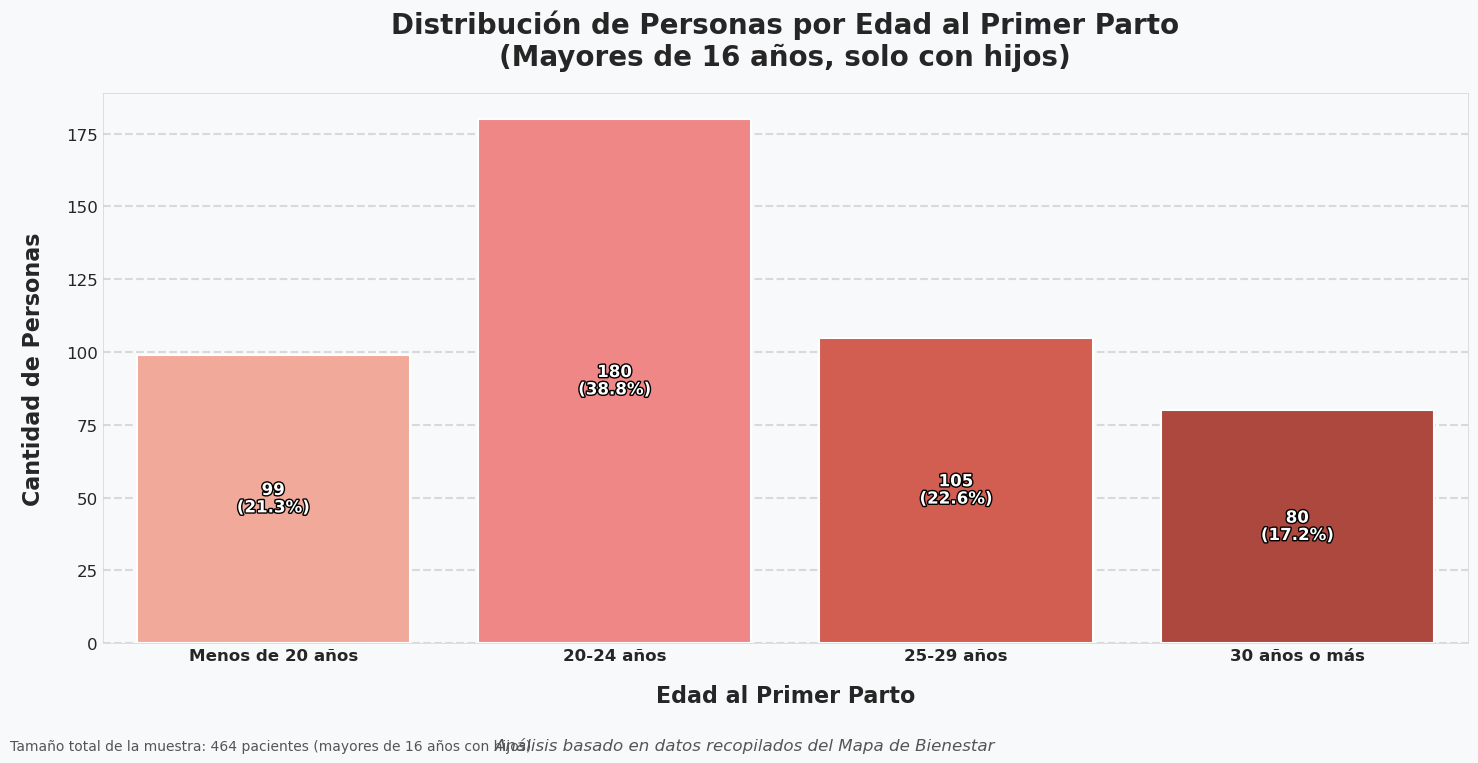

In [1313]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patheffects as path_effects

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos y filtrar mayores de 16 años
data_filtered = data[data['age_years'] > 16].copy()

# Crear un diccionario para mapear los valores en inglés a español
etiquetas_espanol = {
    'AGE_30_OR_MORE_YEARS': '30 años o más',
    'AGE_25_29_YEARS': '25-29 años',
    'NO_CHILDREN': 'Sin hijos',
    'AGE_20_24_YEARS': '20-24 años',
    'LESS_THAN_20_YEARS': 'Menos de 20 años',
    'UNKNOWN': 'Desconocido'
    # nan se manejará automáticamente
}

# Aplicar la traducción
data_filtered['maternal_first_birth_age'] = data_filtered['maternal_first_birth_age'].map(lambda x: etiquetas_espanol.get(x, x))

# Filtrar solo pacientes con hijos (excluir "Sin hijos" y "Desconocido")
data_filtered = data_filtered[~data_filtered['maternal_first_birth_age'].isin(['Sin hijos', 'Desconocido', np.nan])]

# Contar la frecuencia de cada categoría
category_counts = data_filtered['maternal_first_birth_age'].value_counts().sort_index()

# Reordenar las categorías en un orden lógico
order = ['Menos de 20 años', '20-24 años', '25-29 años', '30 años o más']
category_counts = category_counts.reindex(order)

# Crear una paleta de colores atractiva - tonos de rojo/coral
colors = ["#FF9F8C", "#FF7675", "#E74C3C", "#C0392B"]

# Crear la figura
plt.figure(figsize=(15, 8), dpi=100)
ax = sns.barplot(x=category_counts.index, y=category_counts.values, palette=colors)

# Añadir etiquetas con los valores y porcentajes
total = category_counts.sum()
for i, (cat, count) in enumerate(category_counts.items()):
    percentage = 100 * count / total
    
    # Añadir texto con contorno para mejorar visibilidad
    text = ax.text(i, count/2, f'{count}\n({percentage:.1f}%)', 
                  ha='center', va='center', fontsize=12, fontweight='bold', color='white')
    
    # Añadir contorno negro al texto para mejorar contraste
    text.set_path_effects([
        path_effects.Stroke(linewidth=2, foreground='black'),
        path_effects.Normal()
    ])

# Mejorar el título y etiquetas
plt.title('Distribución de Personas por Edad al Primer Parto\n(Mayores de 16 años, solo con hijos)', 
         fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Edad al Primer Parto', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Cantidad de Personas', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks
plt.xticks(rotation=0, fontsize=12, fontweight='bold')  # Sin rotación ya que hay pocas categorías
plt.yticks(fontsize=12)

# Añadir grid para facilitar la lectura
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Añadir un borde al gráfico
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('lightgray')
    spine.set_linewidth(0.5)

# Añadir un fondo sutil
plt.gcf().patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Añadir anotación con el tamaño total de la muestra
plt.figtext(0.01, 0.01, f'Tamaño total de la muestra: {int(total)} pacientes (mayores de 16 años con hijos)', 
           ha='left', fontsize=10, color='#555555')

# Añadir un título secundario con información adicional
plt.figtext(0.5, 0.01, 'Análisis basado en datos recopilados del Mapa de Bienestar', 
           ha='center', fontsize=12, fontstyle='italic', color='#555555')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Mostrar el gráfico
plt.show()

### Riesgo de CA de Mama

/tmp/ipykernel_4485/311207114.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


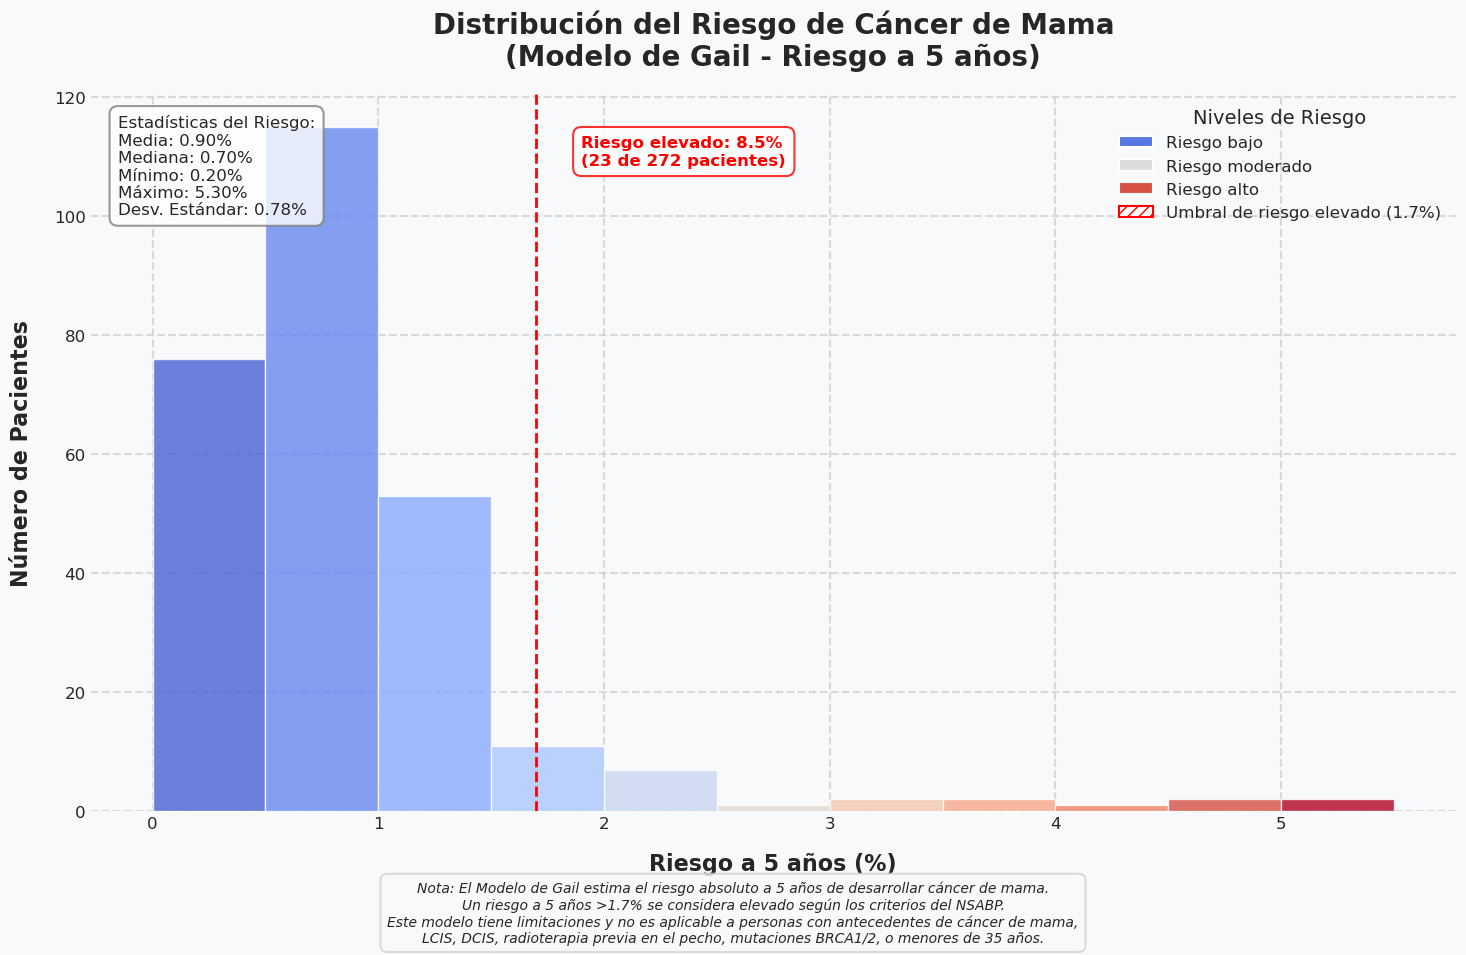

Número total de pacientes con datos de riesgo válidos: 272
Pacientes con riesgo elevado (>1.7%): 23 (8.5%)
Rango de riesgo: 0.20% - 5.30%


In [1314]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.patches import Patch

# Configurar el estilo de seaborn para gráficos más atractivos
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']

# Crear una copia de los datos
data_filtered = data.copy()

# Convertir breast_cancer_risk_value a numérico, ignorando errores
data_filtered['breast_cancer_risk_value'] = pd.to_numeric(data_filtered['breast_cancer_risk_value'], errors='coerce')

# Eliminar valores nulos o negativos
data_filtered = data_filtered[data_filtered['breast_cancer_risk_value'].notna() & 
                             (data_filtered['breast_cancer_risk_value'] >= 0)]

# Crear la figura
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

# Definir bins para el histograma (ajustar según la distribución de tus datos)
bins = np.arange(0, max(data_filtered['breast_cancer_risk_value']) + 0.5, 0.5)

# Crear el histograma con una paleta de colores que refleje el riesgo
# Usar un colormap que vaya de azul (bajo riesgo) a rojo (alto riesgo)
n, bins, patches = ax.hist(data_filtered['breast_cancer_risk_value'], bins=bins, 
                          alpha=0.8, edgecolor='white', linewidth=1)

# Colorear las barras según el nivel de riesgo
bin_centers = 0.5 * (bins[:-1] + bins[1:])
cmap = plt.cm.get_cmap('coolwarm')
col = bin_centers / max(bin_centers)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cmap(c))

# Añadir una línea vertical en 1.7% (umbral de riesgo elevado según NSABP)
plt.axvline(x=1.7, color='red', linestyle='--', linewidth=2, 
           label='Umbral de riesgo elevado (1.7%)')

# Calcular el porcentaje de pacientes con riesgo elevado
high_risk_percent = 100 * (data_filtered['breast_cancer_risk_value'] > 1.7).mean()
high_risk_count = (data_filtered['breast_cancer_risk_value'] > 1.7).sum()
total_count = len(data_filtered)

# Añadir texto para mostrar el porcentaje de pacientes con riesgo elevado
plt.text(1.7 + 0.2, ax.get_ylim()[1] * 0.9, 
        f'Riesgo elevado: {high_risk_percent:.1f}%\n({high_risk_count} de {total_count} pacientes)', 
        fontsize=12, color='red', fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='red', boxstyle='round,pad=0.5'))

# Mejorar el título y etiquetas
plt.title('Distribución del Riesgo de Cáncer de Mama\n(Modelo de Gail - Riesgo a 5 años)', 
         fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Riesgo a 5 años (%)', fontsize=16, fontweight='bold', labelpad=15)
plt.ylabel('Número de Pacientes', fontsize=16, fontweight='bold', labelpad=15)

# Mejorar los ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Añadir grid para facilitar la lectura
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Crear una leyenda personalizada
legend_elements = [
    Patch(facecolor=cmap(0.1), edgecolor='white', label='Riesgo bajo'),
    Patch(facecolor=cmap(0.5), edgecolor='white', label='Riesgo moderado'),
    Patch(facecolor=cmap(0.9), edgecolor='white', label='Riesgo alto'),
    Patch(facecolor='white', edgecolor='red', hatch='///', label='Umbral de riesgo elevado (1.7%)')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=12, 
          title='Niveles de Riesgo', title_fontsize=14)

# Añadir estadísticas descriptivas
stats_text = (
    f"Estadísticas del Riesgo:\n"
    f"Media: {data_filtered['breast_cancer_risk_value'].mean():.2f}%\n"
    f"Mediana: {data_filtered['breast_cancer_risk_value'].median():.2f}%\n"
    f"Mínimo: {data_filtered['breast_cancer_risk_value'].min():.2f}%\n"
    f"Máximo: {data_filtered['breast_cancer_risk_value'].max():.2f}%\n"
    f"Desv. Estándar: {data_filtered['breast_cancer_risk_value'].std():.2f}%"
)
plt.text(0.02, 0.97, stats_text, transform=ax.transAxes, fontsize=12,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'),
        verticalalignment='top')

# Añadir nota informativa sobre el Modelo de Gail
note_text = (
    "Nota: El Modelo de Gail estima el riesgo absoluto a 5 años de desarrollar cáncer de mama.\n"
    "Un riesgo a 5 años >1.7% se considera elevado según los criterios del NSABP.\n"
    "Este modelo tiene limitaciones y no es aplicable a personas con antecedentes de cáncer de mama,\n"
    "LCIS, DCIS, radioterapia previa en el pecho, mutaciones BRCA1/2, o menores de 35 años."
)
plt.figtext(0.5, 0.01, note_text, ha='center', fontsize=10, fontstyle='italic',
           bbox=dict(facecolor='#f8f9fa', alpha=0.8, edgecolor='lightgray', boxstyle='round,pad=0.5'))

# Añadir un fondo sutil
fig.patch.set_facecolor('#f8f9fa')
ax.set_facecolor('#f8f9fa')

# Ajustar el diseño
plt.tight_layout(rect=[0, 0.05, 1, 0.97])

# Mostrar el gráfico
plt.show()

# Mostrar estadísticas adicionales
print(f"Número total de pacientes con datos de riesgo válidos: {total_count}")
print(f"Pacientes con riesgo elevado (>1.7%): {high_risk_count} ({high_risk_percent:.1f}%)")
print(f"Rango de riesgo: {data_filtered['breast_cancer_risk_value'].min():.2f}% - {data_filtered['breast_cancer_risk_value'].max():.2f}%")

## e. Análisis por datos de tabaquismo

In [1315]:
data.smoking_status.unique()

array(['NON_SMOKER', 'CURRENT_SMOKER', 'FORMER_SMOKER'], dtype=object)

/tmp/ipykernel_4485/3021432347.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


<Axes: title={'center': 'Distribución de Estado de Tabaquismo'}, xlabel='Estado de Tabaquismo', ylabel='Porcentaje (%)'>

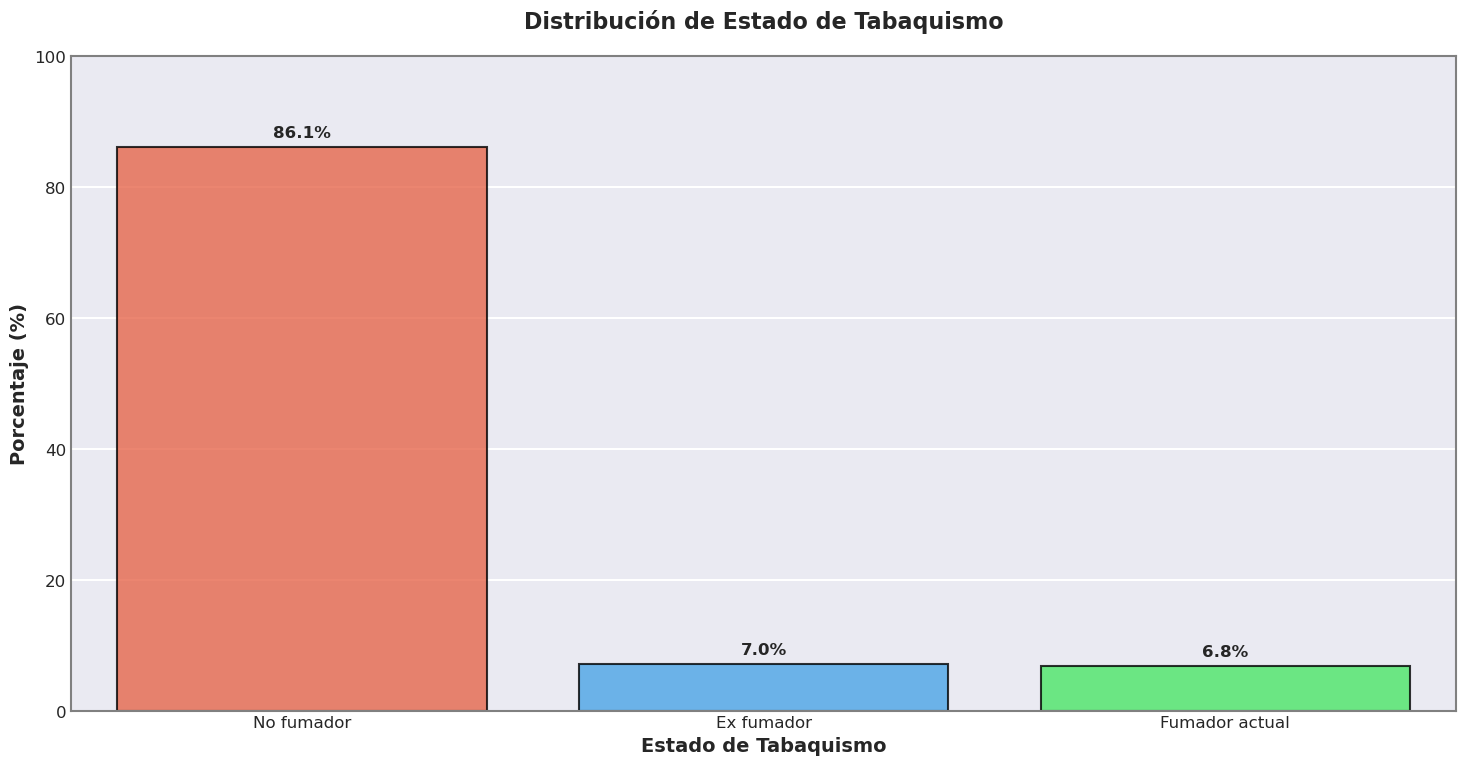

In [1316]:
plot_category_percentages(
    data, 
    column='smoking_status', 
    title="Distribución de Estado de Tabaquismo", 
    xlabel="Estado de Tabaquismo", 
    ylabel="Porcentaje (%)", 
    figsize=(15,8), 
    rotation=0,  # Cambié a 0 porque las etiquetas en español son cortas
    ha='center', 
    use_hue=False
)

2025-02-28 16:48:04,560 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_4485/3021432347.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_4485/3021432347.py:52: UserWarning: 
The palette list has fewer values (3) than needed (12) and will cycle, which may produce an uninterpretable plot.
  ax = sns.barplot(
2025-02-28 16:48:04,565 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: title={'center': 'Distribución de Número de Cigarrillos al Día en Fumadores'}, xlabel='Número de Cigarrillos al Día', ylabel='Porcentaje (%)'>

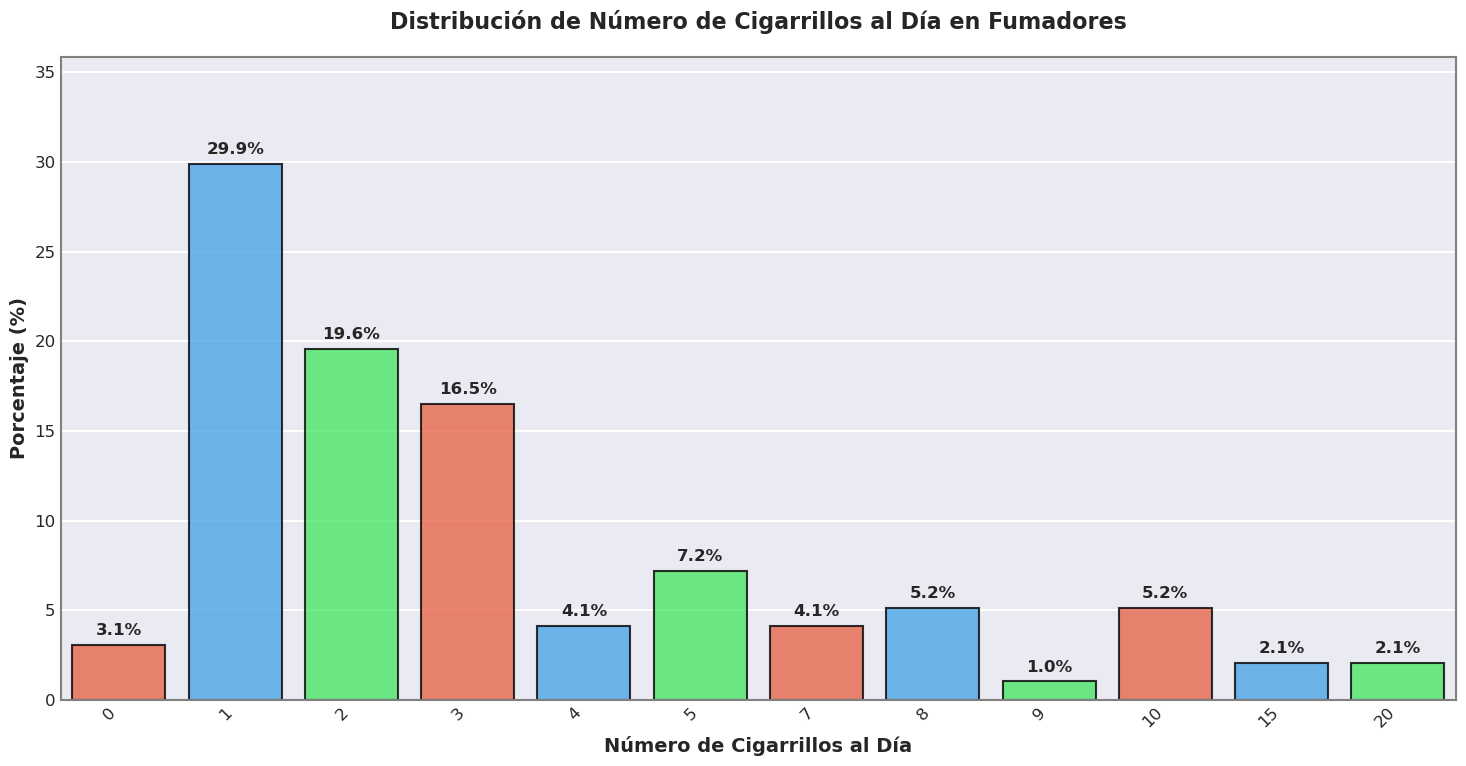

In [1317]:
# Distribución de personas por número de cigarrillos al día contemplando solo el universo de fumadores (smoking_status == 'CURRENT_SMOKER')
data_active_smokers = data[data['smoking_status'].isin(['CURRENT_SMOKER'])]

plot_category_percentages(
    data_active_smokers, 
    column='cigarettes_per_day', 
    title="Distribución de Número de Cigarrillos al Día en Fumadores", 
    xlabel="Número de Cigarrillos al Día", 
    ylabel="Porcentaje (%)", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

2025-02-28 16:48:04,709 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (13) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(
2025-02-28 16:48:04,712 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: title={'center': 'Distribución de Número de Cigarrillos al Día en Ex fumadores'}, xlabel='Número de Cigarrillos al Día', ylabel='Cantidad de Personas'>

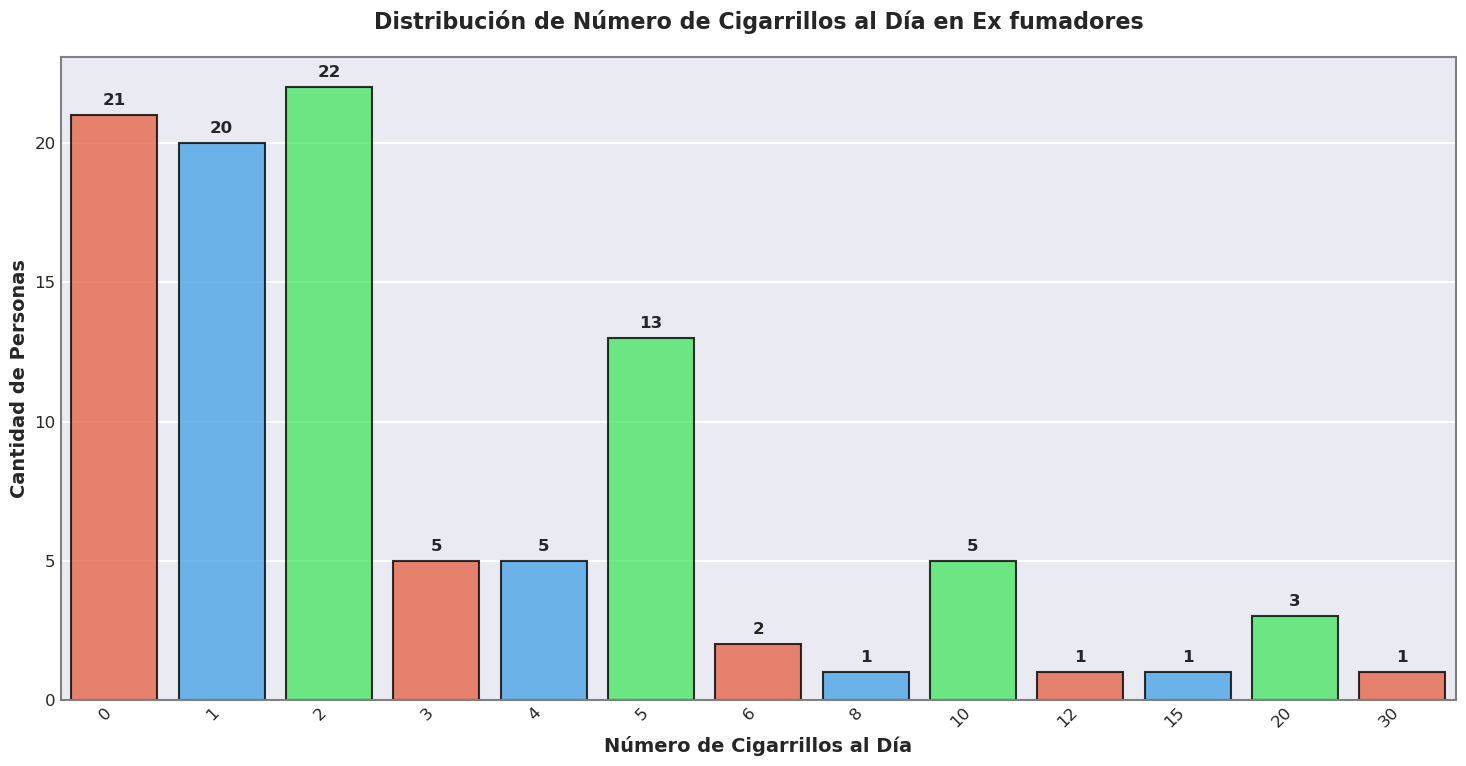

In [1318]:
# Distribución de personas por número de cigarrillos al día contemplando solo el universo de ex fumadores (smoking_status == 'FORMER_SMOKER')
data_former_smokers = data[data['smoking_status'].isin(['FORMER_SMOKER'])]

plot_category_counts(
    data_former_smokers, 
    column='cigarettes_per_day', 
    title="Distribución de Número de Cigarrillos al Día en Ex fumadores", 
    xlabel="Número de Cigarrillos al Día", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

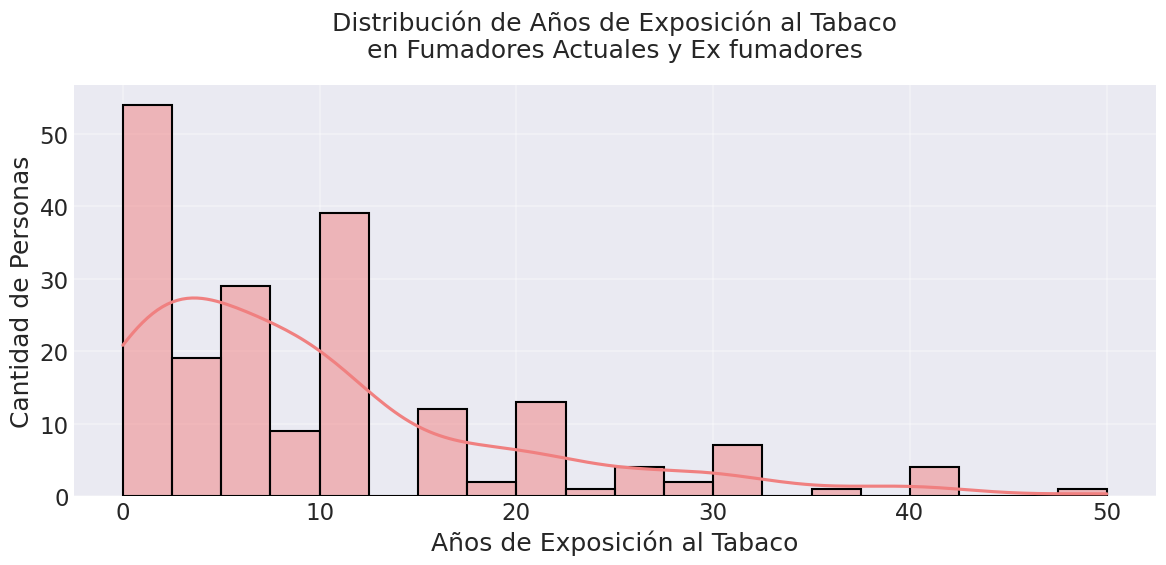


Estadísticas de Años de Exposición al Tabaco:
count    197.0
mean       9.5
std        9.6
min        0.0
25%        2.0
50%        7.0
75%       11.0
max       50.0
Name: years_smoked, dtype: float64


In [1319]:
# Filtrar fumadores actuales y ex fumadores, excluyendo valores nulos
data_smokers = data[data['smoking_status'].isin(['CURRENT_SMOKER', 'FORMER_SMOKER'])]
data_smokers = data_smokers[data_smokers['years_smoked'].notna()]

# Convertir a numérico y filtrar valores realistas (0-80 años de exposición)
data_smokers['years_smoked'] = pd.to_numeric(data_smokers['years_smoked'], errors='coerce')
data_smokers = data_smokers[
    (data_smokers['years_smoked'] >= 0) & 
    (data_smokers['years_smoked'] <= 80)
]

# Crear el histograma con mejor estilo
plt.figure(figsize=(12, 6))
sns.histplot(
    data=data_smokers,
    x='years_smoked',
    bins=20,
    kde=True,
    color='lightcoral',
    edgecolor='black'
)

# Personalizar el gráfico
plt.title('Distribución de Años de Exposición al Tabaco\nen Fumadores Actuales y Ex fumadores', pad=20)
plt.xlabel('Años de Exposición al Tabaco')
plt.ylabel('Cantidad de Personas')

# Agregar grid para mejor lectura
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar estadísticas descriptivas
print("\nEstadísticas de Años de Exposición al Tabaco:")
print(data_smokers['years_smoked'].describe().round(1))

In [1320]:
data.copd_risk_value.unique()

array([0, 2, 3, 1, 4])

/home/diego/miniforge3/envs/data_science/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129729 (\N{LUNGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


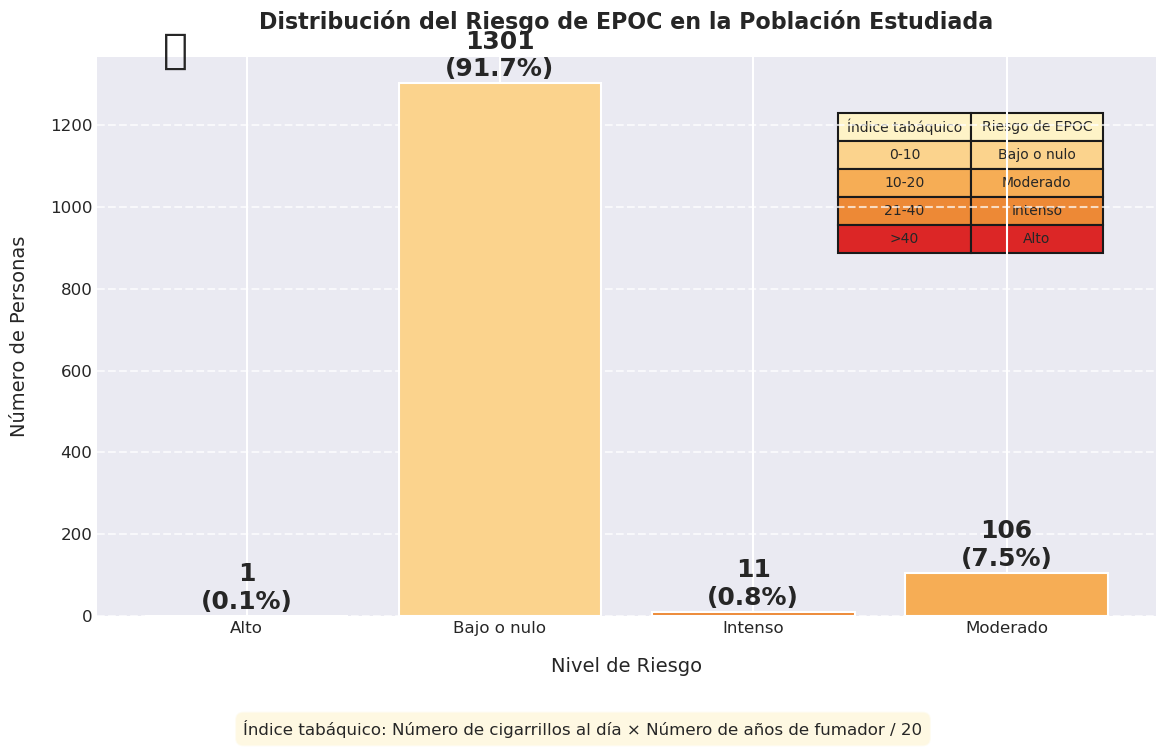

Total de personas evaluadas: 1419
Riesgo Alto: 1 personas (0.1%)
Riesgo Bajo o nulo: 1301 personas (91.7%)
Riesgo Intenso: 11 personas (0.8%)
Riesgo Moderado: 106 personas (7.5%)


In [1321]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Definir un mapeo para la interpretación del riesgo de EPOC según la imagen
copd_risk_interpretation = {
    0: "Bajo o nulo",
    1: "Moderado",
    2: "Moderado",
    3: "Intenso",
    4: "Alto"
}

# Crear una columna con la interpretación del riesgo
data['copd_risk_category'] = data['copd_risk_value'].map(copd_risk_interpretation)

# Contar la frecuencia de cada categoría de riesgo
risk_counts = data['copd_risk_category'].value_counts().sort_index()

# Definir colores para cada categoría de riesgo (basados en la imagen)
colors = {
    'Bajo o nulo': '#FBD38D',     # Naranja claro
    'Moderado': '#F6AD55', # Naranja medio
    'Intenso': '#ED8936',      # Naranja oscuro
    'Alto': '#DC2626'      # Rojo
}

# Crear el gráfico
plt.figure(figsize=(12, 8))

# Crear barras para cada categoría con los colores correspondientes
bars = plt.bar(
    risk_counts.index, 
    risk_counts.values,
    color=[colors[cat] for cat in risk_counts.index]
)

# Añadir etiquetas con el número y porcentaje en cada barra
total = len(data)
for bar in bars:
    height = bar.get_height()
    percentage = (height / total) * 100
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 5,
        f'{int(height)}\n({percentage:.1f}%)',
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# Personalizar el gráfico
plt.title('Distribución del Riesgo de EPOC en la Población Estudiada', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Nivel de Riesgo', fontsize=14, labelpad=15)
plt.ylabel('Número de Personas', fontsize=14, labelpad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Añadir una leyenda explicativa
plt.figtext(
    0.5, 0.01, 
    "Índice tabáquico: Número de cigarrillos al día × Número de años de fumador / 20",
    ha='center', 
    fontsize=12, 
    bbox={'facecolor':'#FEF3C7', 'alpha':0.5, 'pad':10, 'boxstyle':'round,pad=0.5'}
)

# Añadir una tabla explicativa del índice tabáquico y riesgo de EPOC
table_data = [
    ['Índice tabáquico', 'Riesgo de EPOC'],
    ['0-10', 'Bajo o nulo'],
    ['10-20', 'Moderado'],
    ['21-40', 'Intenso'],
    ['>40', 'Alto']
]

# Crear una tabla en la esquina superior derecha
table = plt.table(
    cellText=table_data,
    cellLoc='center',
    loc='upper right',
    bbox=[0.7, 0.65, 0.25, 0.25],
    cellColours=[['#FEF3C7', '#FEF3C7']] + 
                [[colors['Bajo o nulo'], colors['Bajo o nulo']]] +
                [[colors['Moderado'], colors['Moderado']]] +
                [[colors['Intenso'], colors['Intenso']]] +
                [[colors['Alto'], colors['Alto']]]
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Añadir una imagen de pulmones (representación simbólica)
plt.figtext(
    0.15, 0.85, 
    "🫁", 
    fontsize=30
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Mostrar estadísticas adicionales
print(f"Total de personas evaluadas: {total}")
for category, count in risk_counts.items():
    percentage = (count / total) * 100
    print(f"Riesgo {category}: {count} personas ({percentage:.1f}%)")

## f. Análisis de antropometría y actividad física

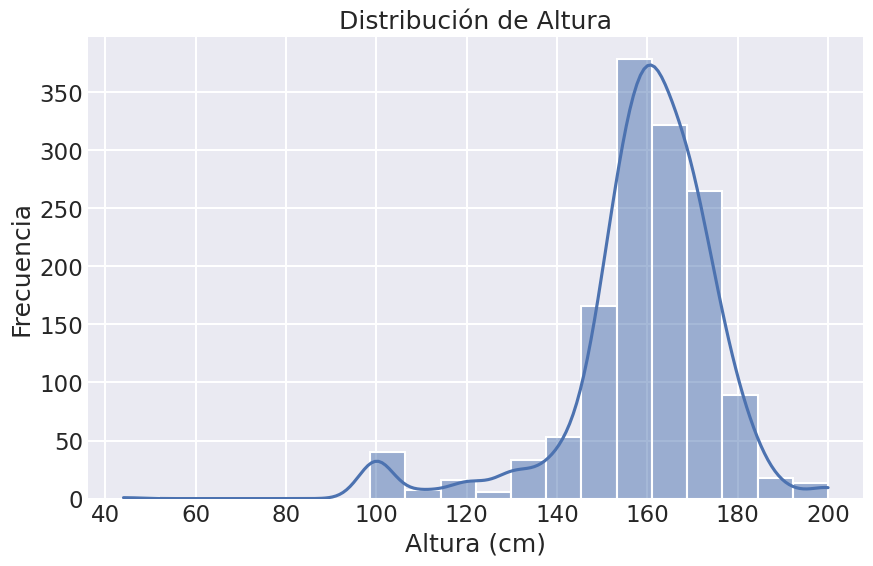

In [1322]:
# Histograma de altura (cm)

# Convertir altura a cm
data['height_cm'] = data['height_meters'] * 100

# Crear histograma
plt.figure(figsize=(10, 6))
sns.histplot(data['height_cm'], bins=20, kde=True)
plt.title('Distribución de Altura')
plt.xlabel('Altura (cm)')
plt.ylabel('Frecuencia')
plt.show()

In [1323]:
# Distribución de altura
data.height_cm.describe()

count    1408.000000
mean      159.472301
std        16.623275
min        44.000000
25%       154.000000
50%       161.000000
75%       169.250000
max       200.000000
Name: height_cm, dtype: float64

In [1324]:
# Promedio de altura
height_mean_cm = data.height_cm.mean()

print(f"Promedio de altura: {data.height_cm.mean()}")

Promedio de altura: 159.47230113636363


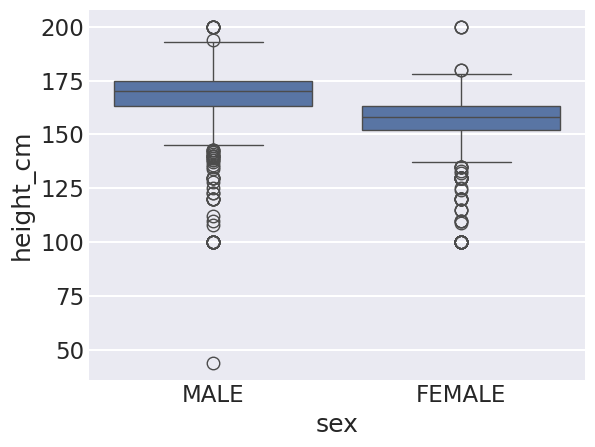

In [1325]:
# Distribución de altura por sexo
sns.boxplot(x='sex', y='height_cm', data=data)
plt.show()


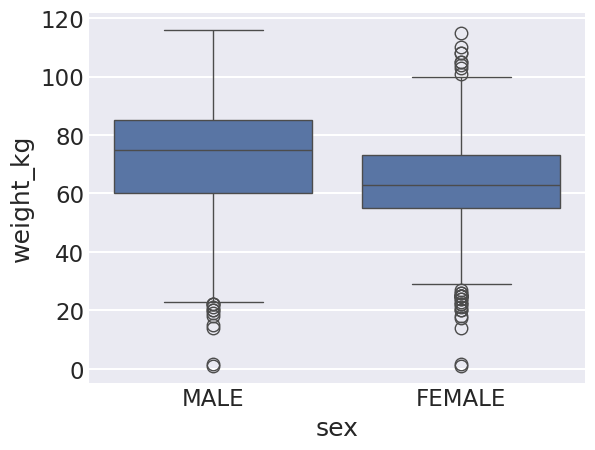

In [1326]:
# Distribución de peso por sexo

# Filtrar valores de peso mayor a 150 kg
data_weight = data[data['weight_kg'] < 150]

sns.boxplot(x='sex', y='weight_kg', data=data_weight)
plt.show()


In [1327]:
data_weight.weight_kg.describe()

count    1419.000000
mean       67.029634
std        18.794200
min         1.000000
25%        55.700000
50%        67.000000
75%        80.000000
max       116.000000
Name: weight_kg, dtype: float64

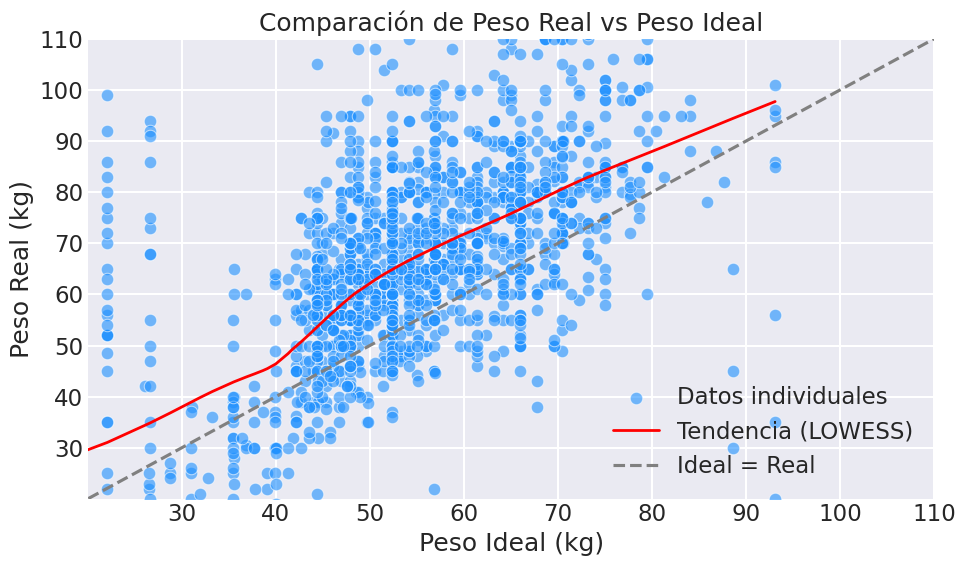

In [1328]:
# Seleccionar registros con datos válidos para weight_kg e ideal_body_weight_value
plot_data = data[['weight_kg', 'ideal_body_weight_value']].dropna()

# Calcular límites usando percentiles (0.01 y 0.99) para descartar valores extremos
lower_limit = min(
    plot_data['weight_kg'].quantile(0.01), 
    plot_data['ideal_body_weight_value'].quantile(0.01)
)
upper_limit = max(
    plot_data['weight_kg'].quantile(0.99), 
    plot_data['ideal_body_weight_value'].quantile(0.99)
)

plt.figure(figsize=(10, 6))

# Gráfica de dispersión para los datos individuales
ax = sns.scatterplot(
    data=plot_data, 
    x='ideal_body_weight_value', 
    y='weight_kg', 
    color='dodgerblue', 
    alpha=0.6, 
    label='Datos individuales'
)

# Línea de tendencia usando LOWESS (sin mostrar puntos)
ax2 = sns.regplot(
    data=plot_data, 
    x='ideal_body_weight_value', 
    y='weight_kg', 
    scatter=False, 
    lowess=True, 
    color='red', 
    line_kws={'linewidth': 2}
)
# Asignar etiqueta a la línea de tendencia (LOWESS)
ax2.lines[0].set_label('Tendencia (LOWESS)')

# Línea de referencia: peso ideal igual a peso real
plt.plot(
    [lower_limit, upper_limit], 
    [lower_limit, upper_limit], 
    linestyle='--', 
    color='gray', 
    label='Ideal = Real'
)

plt.title("Comparación de Peso Real vs Peso Ideal")
plt.xlabel("Peso Ideal (kg)")
plt.ylabel("Peso Real (kg)")
plt.xlim(lower_limit, upper_limit)
plt.ylim(lower_limit, upper_limit)
plt.legend()
plt.tight_layout()
plt.show()

In [1329]:
# Cantidad de personas cuyo peso es mayor al peso ideal
data_overweight = data[data['weight_kg'] > data['ideal_body_weight_value']]
data_overweight.shape[0]


1115

In [1330]:
# Porcentaje de personas cuyo peso es mayor al peso ideal
data_overweight_percentage = data_overweight.shape[0] / data.shape[0]
data_overweight_percentage


0.7857646229739254

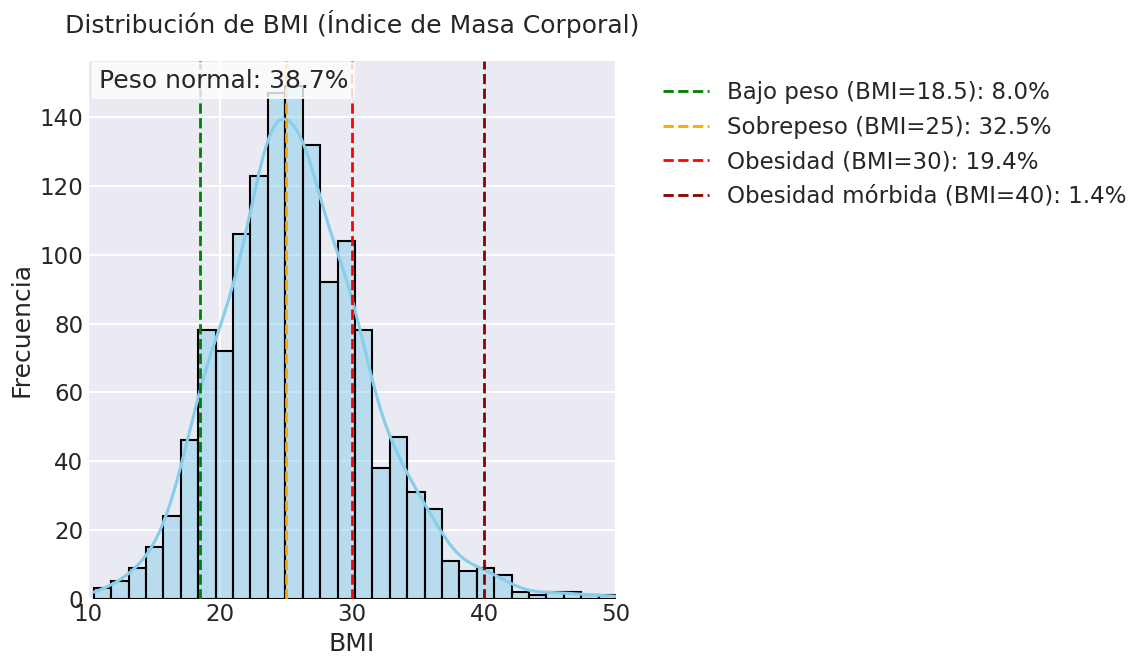


Estadísticas de BMI por categoría:
Bajo peso (<18.5): 110 personas (8.0%)
Peso normal (18.5-24.9): 530 personas (38.7%)
Sobrepeso (25-29.9): 445 personas (32.5%)
Obesidad (30-39.9): 265 personas (19.4%)
Obesidad mórbida (≥40): 19 personas (1.4%)


In [1331]:
# Filtrar datos para BMI entre 10 y 50
data_filtered = data_weight[
    (data_weight['bmi_value'] >= 10) & 
    (data_weight['bmi_value'] <= 50)
].copy()

# Calcular porcentajes por categoría
total_people = len(data_filtered)
bajo_peso = (data_filtered['bmi_value'] < 18.5).sum()
normal = ((data_filtered['bmi_value'] >= 18.5) & (data_filtered['bmi_value'] < 25)).sum()
sobrepeso = ((data_filtered['bmi_value'] >= 25) & (data_filtered['bmi_value'] < 30)).sum()
obesidad = ((data_filtered['bmi_value'] >= 30) & (data_filtered['bmi_value'] < 40)).sum()
obesidad_morbida = (data_filtered['bmi_value'] >= 40).sum()

# Graficar la distribución
plt.figure(figsize=(12, 7))
sns.histplot(data=data_filtered['bmi_value'], bins=30, kde=True, color='skyblue', edgecolor='black')
plt.title('Distribución de BMI (Índice de Masa Corporal)', pad=20)
plt.xlabel('BMI')
plt.ylabel('Frecuencia')

# Líneas de referencia con porcentajes
plt.axvline(x=18.5, color='green', linestyle='--', linewidth=2, 
            label=f'Bajo peso (BMI=18.5): {bajo_peso/total_people*100:.1f}%')
plt.axvline(x=25, color='orange', linestyle='--', linewidth=2, 
            label=f'Sobrepeso (BMI=25): {sobrepeso/total_people*100:.1f}%')
plt.axvline(x=30, color='red', linestyle='--', linewidth=2, 
            label=f'Obesidad (BMI=30): {obesidad/total_people*100:.1f}%')
plt.axvline(x=40, color='darkred', linestyle='--', linewidth=2, 
            label=f'Obesidad mórbida (BMI=40): {obesidad_morbida/total_people*100:.1f}%')

# Ajustar límites del eje x
plt.xlim(10, 50)

# Añadir texto con el porcentaje de peso normal
plt.text(0.02, 0.95, f'Peso normal: {normal/total_people*100:.1f}%', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Imprimir estadísticas
print("\nEstadísticas de BMI por categoría:")
print(f"Bajo peso (<18.5): {bajo_peso} personas ({bajo_peso/total_people*100:.1f}%)")
print(f"Peso normal (18.5-24.9): {normal} personas ({normal/total_people*100:.1f}%)")
print(f"Sobrepeso (25-29.9): {sobrepeso} personas ({sobrepeso/total_people*100:.1f}%)")
print(f"Obesidad (30-39.9): {obesidad} personas ({obesidad/total_people*100:.1f}%)")
print(f"Obesidad mórbida (≥40): {obesidad_morbida} personas ({obesidad_morbida/total_people*100:.1f}%)")

In [1332]:
data_weight.bmi_value.describe()

count    1408.00000
mean       26.63169
std         9.38523
min         0.33000
25%        22.03750
50%        25.62000
75%        29.39000
max       144.63000
Name: bmi_value, dtype: float64

/tmp/ipykernel_4485/2750313499.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


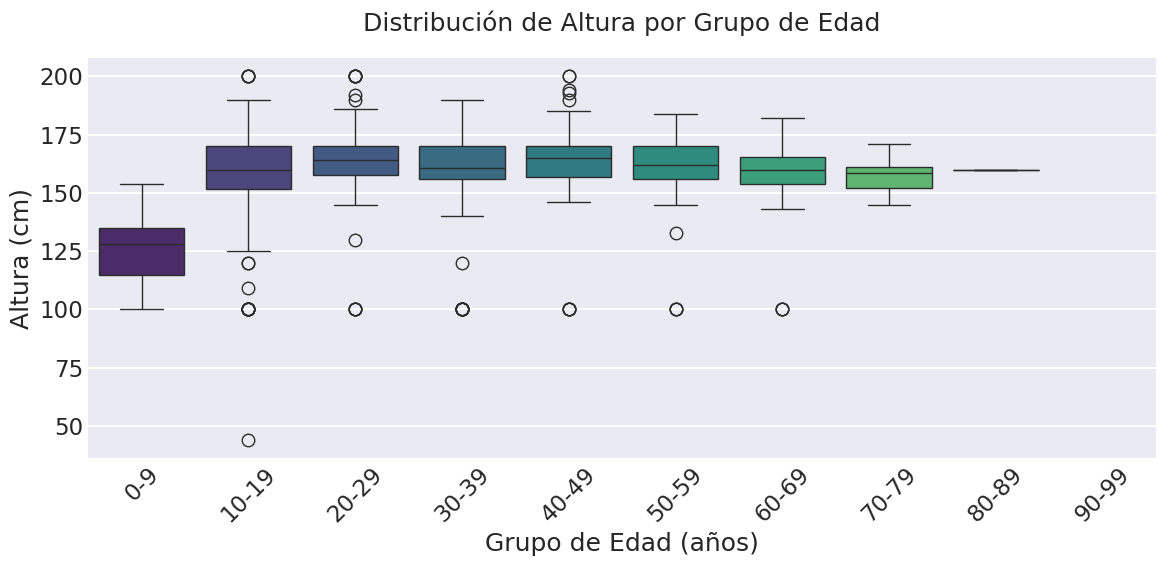


Estadísticas de altura por grupo de edad:
           count   mean   std    min    25%    50%    75%    max
age_group                                                       
0-9         65.0  125.0  14.9  100.0  115.0  128.0  135.0  154.0
10-19      343.0  158.1  17.4   44.0  151.5  160.0  170.0  200.0
20-29      252.0  164.4  13.5  100.0  157.8  164.0  170.2  200.0
30-39      300.0  160.7  14.0  100.0  156.0  160.5  170.0  190.0
40-49      257.0  163.6  12.5  100.0  157.0  165.0  170.0  200.0
50-59      102.0  161.4  14.5  100.0  156.0  162.0  170.0  184.0
60-69       75.0  157.9  14.6  100.0  154.0  160.0  165.5  182.0
70-79       12.0  157.3   7.7  145.0  152.2  158.5  161.0  171.0
80-89        2.0  160.0   0.0  160.0  160.0  160.0  160.0  160.0
90-99        0.0    NaN   NaN    NaN    NaN    NaN    NaN    NaN


/tmp/ipykernel_4485/2750313499.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(data.groupby('age_group')['height_cm'].describe().round(1))


In [1333]:
# Crear figura con un tamaño más adecuado
plt.figure(figsize=(12, 6))

# Usar los grupos de edad que ya habíamos creado anteriormente
sns.boxplot(
    x='age_group', 
    y='height_cm', 
    data=data,
    palette='viridis'
)

# Personalizar el gráfico
plt.title('Distribución de Altura por Grupo de Edad', pad=20)
plt.xlabel('Grupo de Edad (años)')
plt.ylabel('Altura (cm)')

# Rotar las etiquetas del eje x para mejor legibilidad
plt.xticks(rotation=45)

# Ajustar los márgenes
plt.tight_layout()

plt.show()

# Mostrar estadísticas resumidas
print("\nEstadísticas de altura por grupo de edad:")
print(data.groupby('age_group')['height_cm'].describe().round(1))

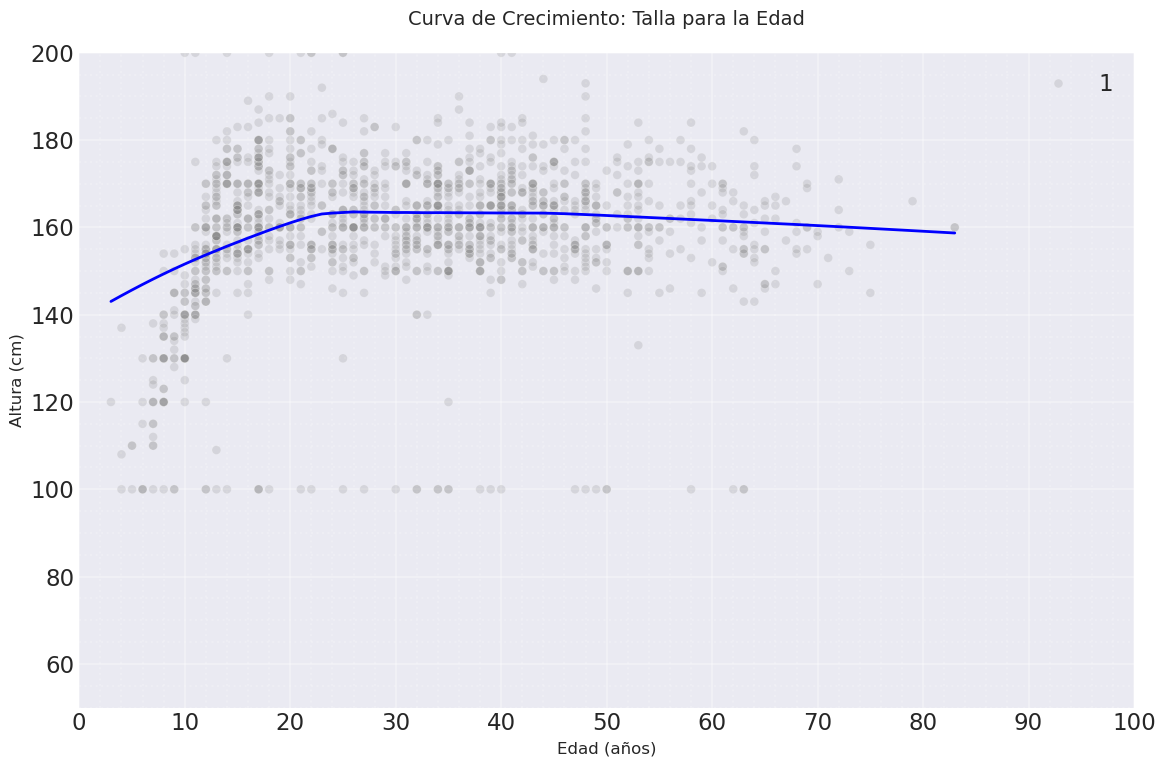

In [1334]:
# Crear figura con un tamaño adecuado
plt.figure(figsize=(12, 8))

# Configurar estilo de la cuadrícula
plt.grid(True, which='major', linestyle='-', alpha=0.3)
plt.grid(True, which='minor', linestyle=':', alpha=0.2)

# Crear scatter plot con transparencia
sns.scatterplot(
    data=data,
    x='age_years',
    y='height_cm',
    alpha=0.2,
    color='gray',
    size=1
)

# Agregar línea de tendencia suavizada con bandas de confianza
sns.regplot(
    data=data,
    x='age_years',
    y='height_cm',
    scatter=False,
    lowess=True,
    color='blue',
    line_kws={'linewidth': 2},
)

# Personalizar el gráfico
plt.title('Curva de Crecimiento: Talla para la Edad', pad=20, fontsize=14)
plt.xlabel('Edad (años)', fontsize=12)
plt.ylabel('Altura (cm)', fontsize=12)

# Establecer límites y ticks
plt.xlim(0, 100)
plt.ylim(50, 200)

# Configurar ticks principales y secundarios
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(10))  # Ticks principales cada 10 años
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))   # Ticks secundarios cada 2 años
ax.yaxis.set_major_locator(plt.MultipleLocator(20))  # Ticks principales cada 20 cm
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))   # Ticks secundarios cada 5 cm

# Ajustar los márgenes
plt.tight_layout()

plt.show()

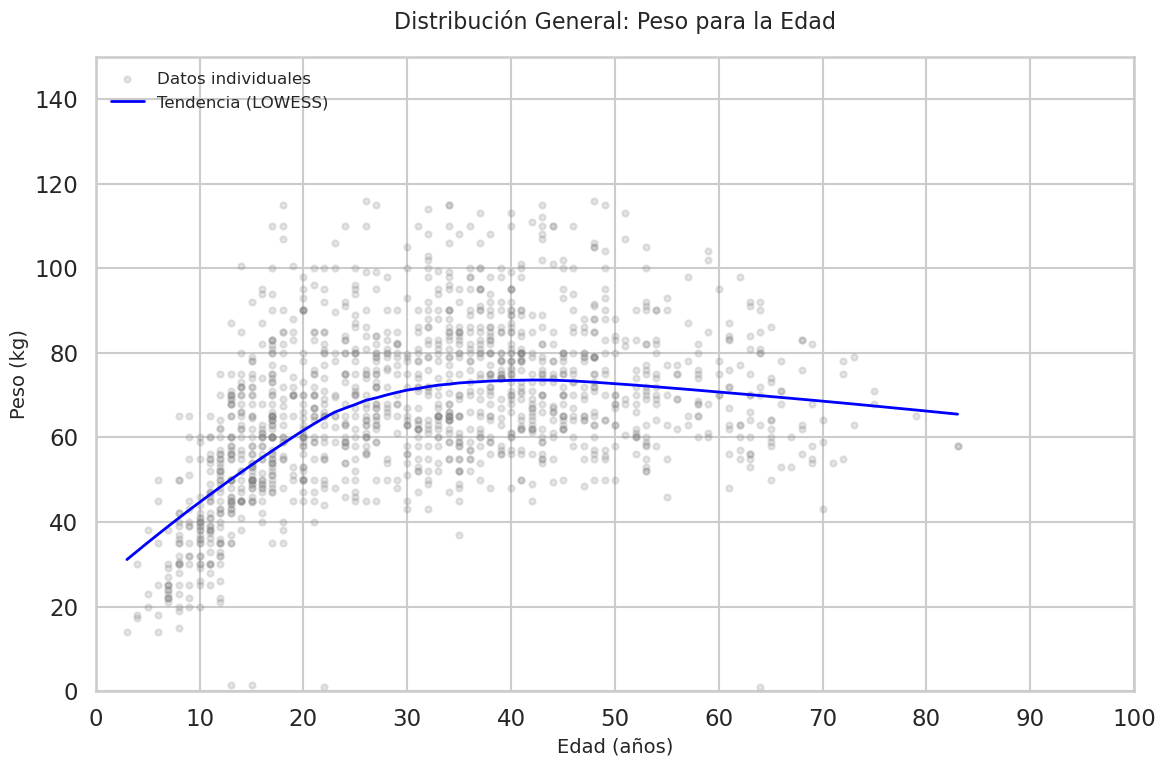

In [1335]:
# Configurar el estilo para obtener una apariencia limpia similar a la de las curvas de crecimiento de la OMS
sns.set_theme(style="whitegrid", context="talk")

# Filtrar los datos en el rango de edad de interés (0 a 100 años)
filtered_data = data[(data['age_years'] >= 0) & (data['age_years'] <= 100)].copy()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos individuales con transparencia
ax.scatter(
    filtered_data['age_years'],
    filtered_data['weight_kg'],
    color='gray',
    alpha=0.2,
    s=20,
    label='Datos individuales'
)

# Agregar la línea de tendencia suavizada mediante LOWESS
sns.regplot(
    data=filtered_data,
    x='age_years',
    y='weight_kg',
    scatter=False,
    lowess=True,
    color='blue',
    line_kws={'linewidth': 2},
    ax=ax,
    label='Tendencia (LOWESS)'
)

# Personalizar el gráfico: títulos, etiquetas y límites
ax.set_title('Distribución General: Peso para la Edad', fontsize=16, pad=20)
ax.set_xlabel('Edad (años)', fontsize=14)
ax.set_ylabel('Peso (kg)', fontsize=14)
ax.set_xlim(0, 100)
ax.set_ylim(0, 150)

# Configurar los locators para los ticks
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))

ax.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

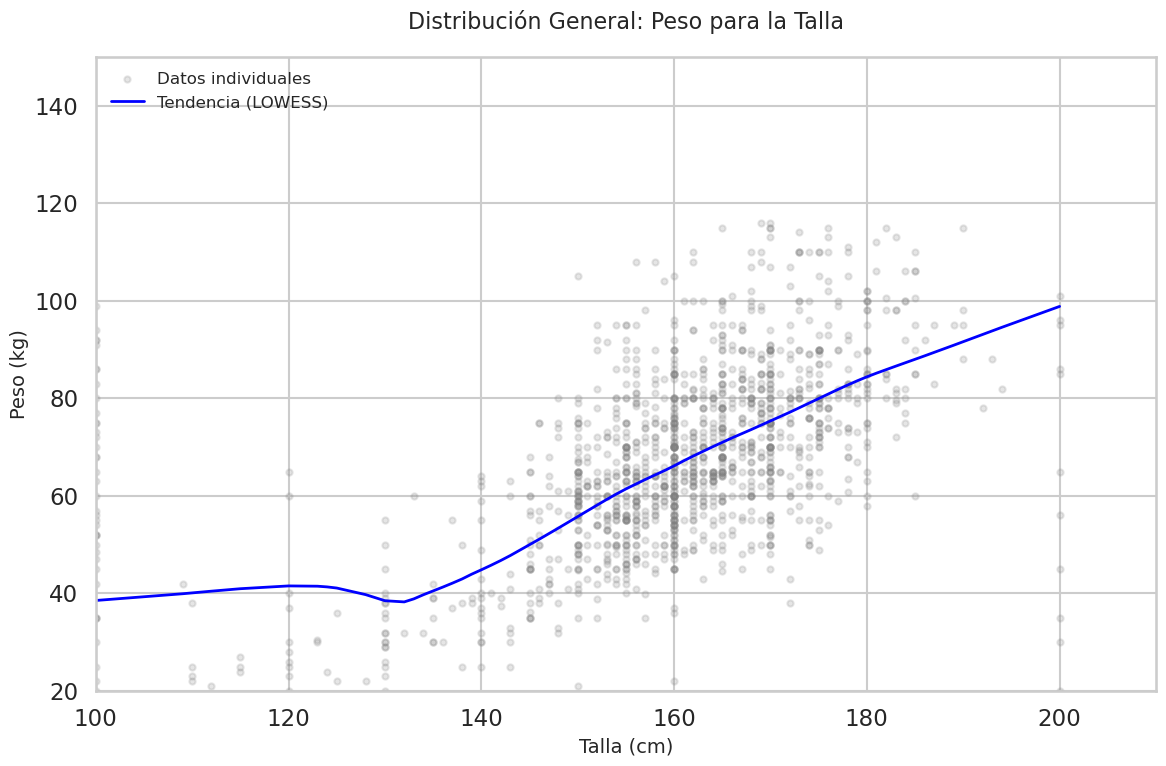

In [1336]:
# Configurar el estilo para obtener una apariencia limpia similar a la de las curvas de crecimiento de la OMS
sns.set_theme(style="whitegrid", context="talk")

# Filtrar los datos para tomar solamente aquellos registros con valores de talla y peso realistas
filtered_data = data[
    (data['height_cm'] >= 100) & (data['height_cm'] <= 210) &
    (data['weight_kg'] >= 20) & (data['weight_kg'] <= 150)
].copy()

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los datos individuales con transparencia
ax.scatter(
    filtered_data['height_cm'],
    filtered_data['weight_kg'],
    color='gray',
    alpha=0.2,
    s=20,
    label='Datos individuales'
)

# Agregar la línea de tendencia suavizada mediante LOWESS
sns.regplot(
    data=filtered_data,
    x='height_cm',
    y='weight_kg',
    scatter=False,
    lowess=True,
    color='blue',
    line_kws={'linewidth': 2},
    ax=ax,
    label='Tendencia (LOWESS)'
)

# Personalizar el gráfico: título, etiquetas y límites
ax.set_title('Distribución General: Peso para la Talla', fontsize=16, pad=20)
ax.set_xlabel('Talla (cm)', fontsize=14)
ax.set_ylabel('Peso (kg)', fontsize=14)
ax.set_xlim(100, 210)
ax.set_ylim(20, 150)

# Configurar ticks principales y secundarios
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.xaxis.set_minor_locator(plt.MultipleLocator(10))
ax.yaxis.set_major_locator(plt.MultipleLocator(20))
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))

ax.legend(loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

## g. Distribución de caídas y otros datos de riesgo

2025-02-28 16:48:06,190 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.countplot(
2025-02-28 16:48:06,194 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: title={'center': 'Distribución de Caídas en el Último Año'}, xlabel='Caídas en el Último Año', ylabel='Cantidad de Personas'>

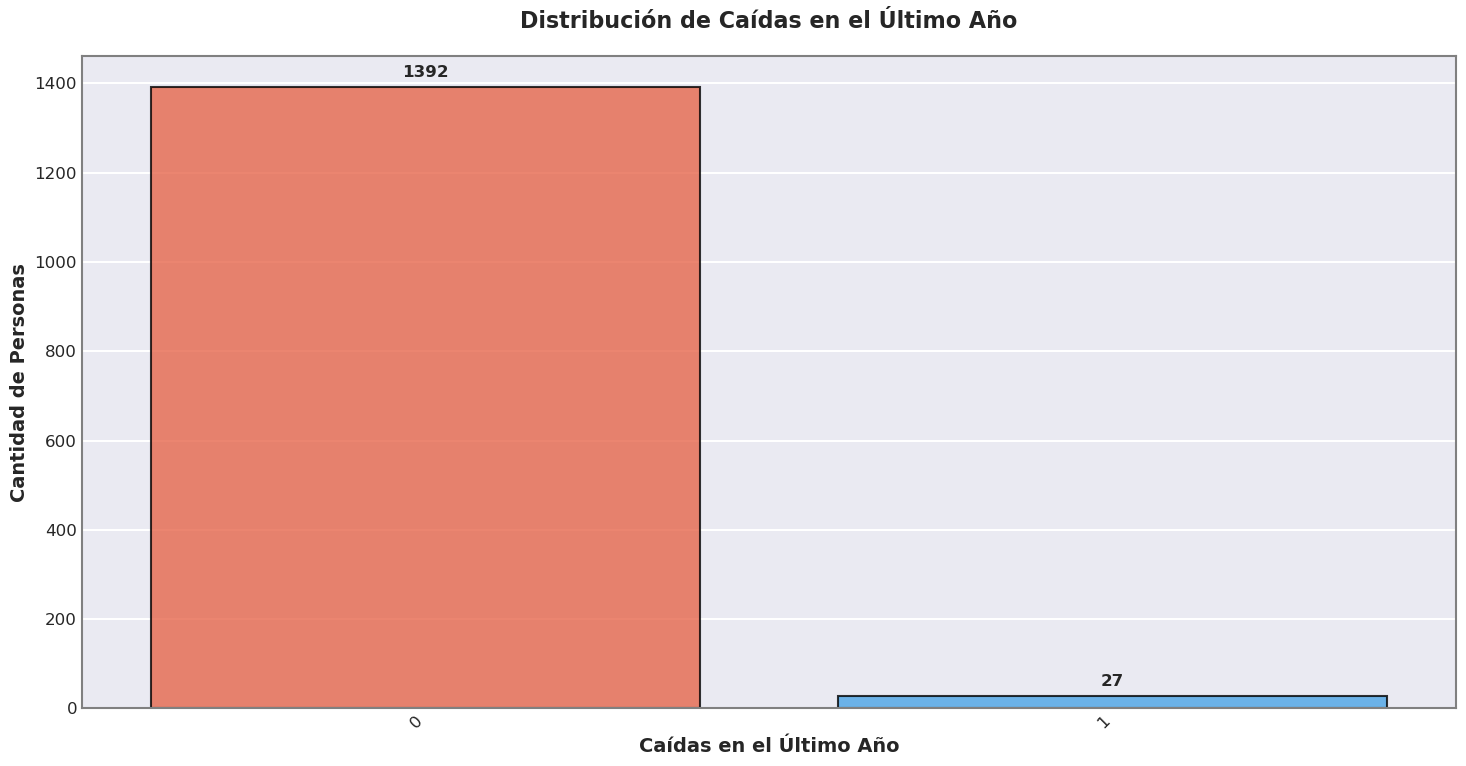

In [1337]:
# Caídas
plot_category_counts(
    data, 
    column='falls_last_year', 
    title="Distribución de Caídas en el Último Año", 
    xlabel="Caídas en el Último Año", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: 
The palette list has fewer values (3) than needed (10) and will cycle, which may produce an uninterpretable plot.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de Caídas por Grupo Etario'}, xlabel='Grupo Etario', ylabel='Cantidad de Caídas el Último Año'>

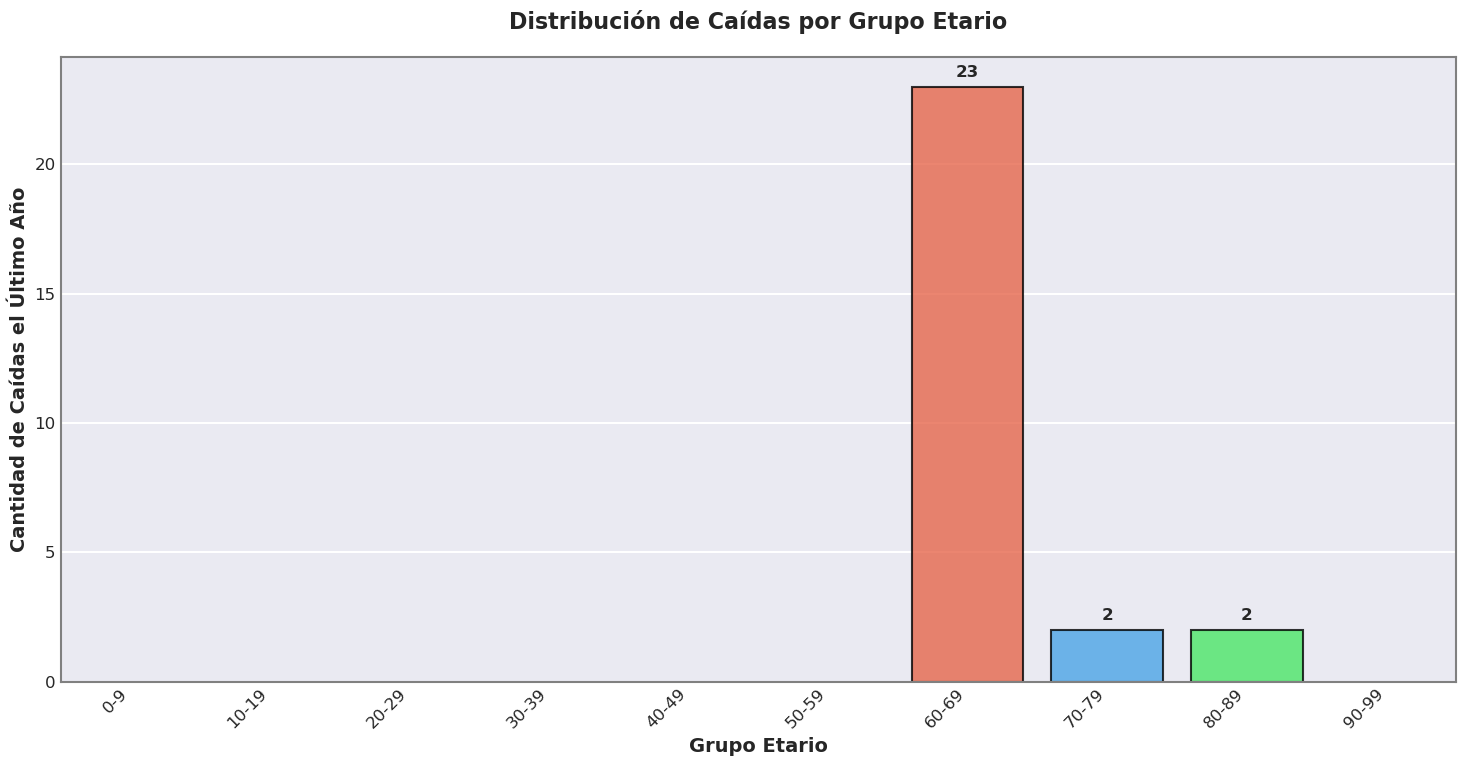

In [1338]:
# Distribución de caídas por grupo etario
# Filtrar registros con caídas (al menos una caída en el último año)
data_fallers = data[data['falls_last_year'] > 0].copy()

# Distribución de caídas por grupo etario
plot_category_counts(
    data_fallers, 
    column='age_group', 
    title="Distribución de Caídas por Grupo Etario", 
    xlabel="Grupo Etario", 
    ylabel="Cantidad de Caídas el Último Año",
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)


# Riesgo de osteoporosis

In [1339]:
data.sarcopenia_risk_value.unique()

array([0, 2, 1, 3, 5, 4, 6])

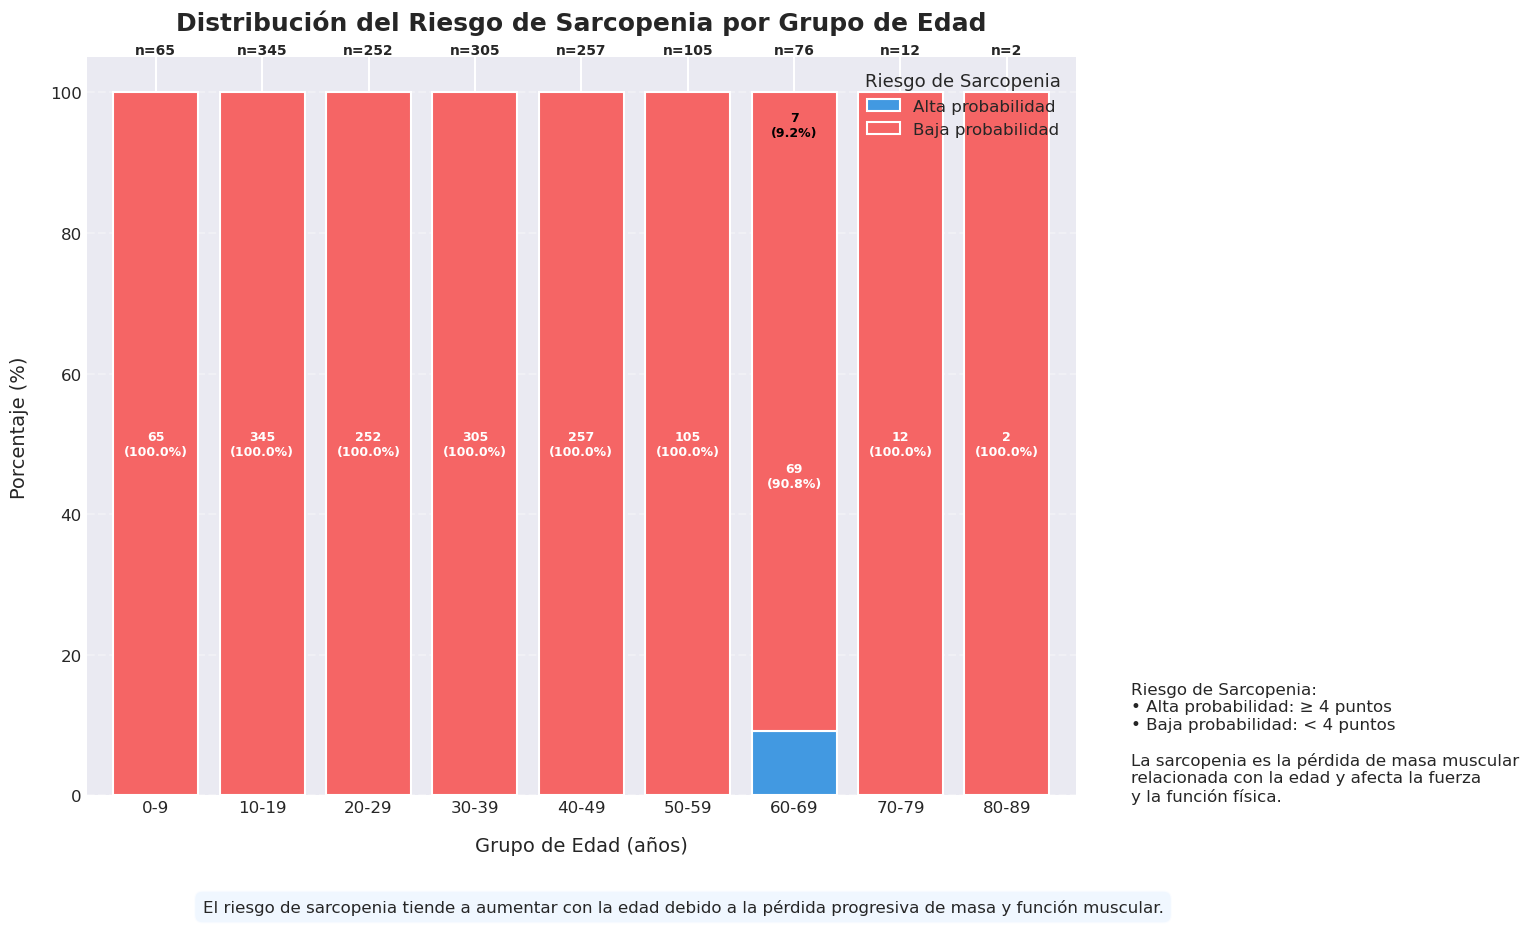

Estadísticas de riesgo de sarcopenia por grupo de edad:
--------------------------------------------------

Grupo de edad 0-9 (n=65):
  Baja probabilidad: 65 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo de edad 10-19 (n=345):
  Baja probabilidad: 345 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo de edad 20-29 (n=252):
  Baja probabilidad: 252 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo de edad 30-39 (n=305):
  Baja probabilidad: 305 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo de edad 40-49 (n=257):
  Baja probabilidad: 257 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo de edad 50-59 (n=105):
  Baja probabilidad: 105 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo de edad 60-69 (n=76):
  Baja probabilidad: 69 personas (90.8%)
  Alta probabilidad: 7 personas (9.2%)

Grupo de edad 70-79 (n=12):
  Baja probabilidad: 12 personas (100.0%)
  Alta probabilidad: 0 personas (0.0%)

Grupo

In [1340]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Definir los grupos de edad (de 10 en 10 años)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Crear la columna de grupo de edad
data['age_group'] = pd.cut(data['age_years'], bins=bins, labels=labels, right=False)

# Definir categorías de riesgo de sarcopenia
data['sarcopenia_risk_category'] = np.where(data['sarcopenia_risk_value'] >= 4, 'Alta probabilidad', 'Baja probabilidad')

# Crear un DataFrame con los conteos por grupo de edad y categoría de riesgo
sarcopenia_by_age = pd.crosstab(data['age_group'], data['sarcopenia_risk_category'], normalize='index') * 100
sarcopenia_counts = pd.crosstab(data['age_group'], data['sarcopenia_risk_category'])

# Calcular el total por grupo de edad para las anotaciones
age_group_totals = data['age_group'].value_counts().sort_index()

# Crear la figura
plt.figure(figsize=(14, 10))

# Crear el gráfico de barras apiladas
ax = sarcopenia_by_age.plot(
    kind='bar', 
    stacked=True,
    color=['#4299E1', '#F56565'],  # Azul para baja probabilidad, rojo para alta
    width=0.8,
    ax=plt.gca()
)

# Personalizar el gráfico
plt.title('Distribución del Riesgo de Sarcopenia por Grupo de Edad', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Grupo de Edad (años)', fontsize=14, labelpad=15)
plt.ylabel('Porcentaje (%)', fontsize=14, labelpad=15)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Riesgo de Sarcopenia', fontsize=12, title_fontsize=13)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Añadir etiquetas con el número de personas en cada categoría
for i, age_group in enumerate(sarcopenia_by_age.index):
    total = age_group_totals[age_group]
    
    # Añadir el total del grupo de edad en la parte superior
    plt.text(
        i, 
        105, 
        f'n={total}',
        ha='center',
        va='bottom',
        fontweight='bold',
        fontsize=10
    )
    
    # Añadir el número para baja probabilidad
    if 'Baja probabilidad' in sarcopenia_counts.columns:
        low_count = sarcopenia_counts.loc[age_group, 'Baja probabilidad']
        if low_count > 0:
            low_pct = sarcopenia_by_age.loc[age_group, 'Baja probabilidad']
            y_pos = low_pct / 2
            plt.text(
                i, 
                y_pos, 
                f'{low_count}\n({low_pct:.1f}%)',
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=9,
                color='white' if low_pct > 20 else 'black'
            )
    
    # Añadir el número para alta probabilidad
    if 'Alta probabilidad' in sarcopenia_counts.columns:
        high_count = sarcopenia_counts.loc[age_group, 'Alta probabilidad']
        if high_count > 0:
            low_pct = sarcopenia_by_age.loc[age_group, 'Baja probabilidad'] if 'Baja probabilidad' in sarcopenia_by_age.columns else 0
            high_pct = sarcopenia_by_age.loc[age_group, 'Alta probabilidad']
            y_pos = low_pct + (high_pct / 2)
            plt.text(
                i, 
                y_pos, 
                f'{high_count}\n({high_pct:.1f}%)',
                ha='center',
                va='center',
                fontweight='bold',
                fontsize=9,
                color='white' if high_pct > 20 else 'black'
            )

# Añadir una caja explicativa
explanation_text = (
    "Riesgo de Sarcopenia:\n"
    "• Alta probabilidad: ≥ 4 puntos\n"
    "• Baja probabilidad: < 4 puntos\n\n"
    "La sarcopenia es la pérdida de masa muscular\n"
    "relacionada con la edad y afecta la fuerza\n"
    "y la función física."
)

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.figtext(0.82, 0.25, explanation_text, fontsize=12, 
            bbox=props, verticalalignment='top')

# Añadir información sobre la tendencia por edad
plt.figtext(
    0.5, 0.02, 
    "El riesgo de sarcopenia tiende a aumentar con la edad debido a la pérdida progresiva de masa y función muscular.",
    ha='center', 
    fontsize=12, 
    bbox={'facecolor':'#EBF4FF', 'alpha':0.7, 'pad':10, 'boxstyle':'round,pad=0.5'}
)

plt.tight_layout(rect=[0, 0.05, 0.8, 0.95])

# Mostrar el gráfico
plt.show()

# Mostrar estadísticas adicionales
print("Estadísticas de riesgo de sarcopenia por grupo de edad:")
print("-" * 50)
for age_group in sarcopenia_by_age.index:
    total = age_group_totals[age_group]
    print(f"\nGrupo de edad {age_group} (n={total}):")
    
    if 'Baja probabilidad' in sarcopenia_by_age.columns:
        low_pct = sarcopenia_by_age.loc[age_group, 'Baja probabilidad']
        low_count = sarcopenia_counts.loc[age_group, 'Baja probabilidad']
        print(f"  Baja probabilidad: {low_count} personas ({low_pct:.1f}%)")
    
    if 'Alta probabilidad' in sarcopenia_by_age.columns:
        high_pct = sarcopenia_by_age.loc[age_group, 'Alta probabilidad']
        high_count = sarcopenia_counts.loc[age_group, 'Alta probabilidad']
        print(f"  Alta probabilidad: {high_count} personas ({high_pct:.1f}%)")

In [1341]:
data.ost_score_value.unique()


array([  9.,   5.,   3.,   8.,   0.,   6.,  -1.,   4.,   7.,  12.,  11.,
        -5.,   1.,  13.,  15.,  10.,  17.,  14.,   2.,  -2.,  -3.,  18.,
        16.,  19.,  -4., -12.])

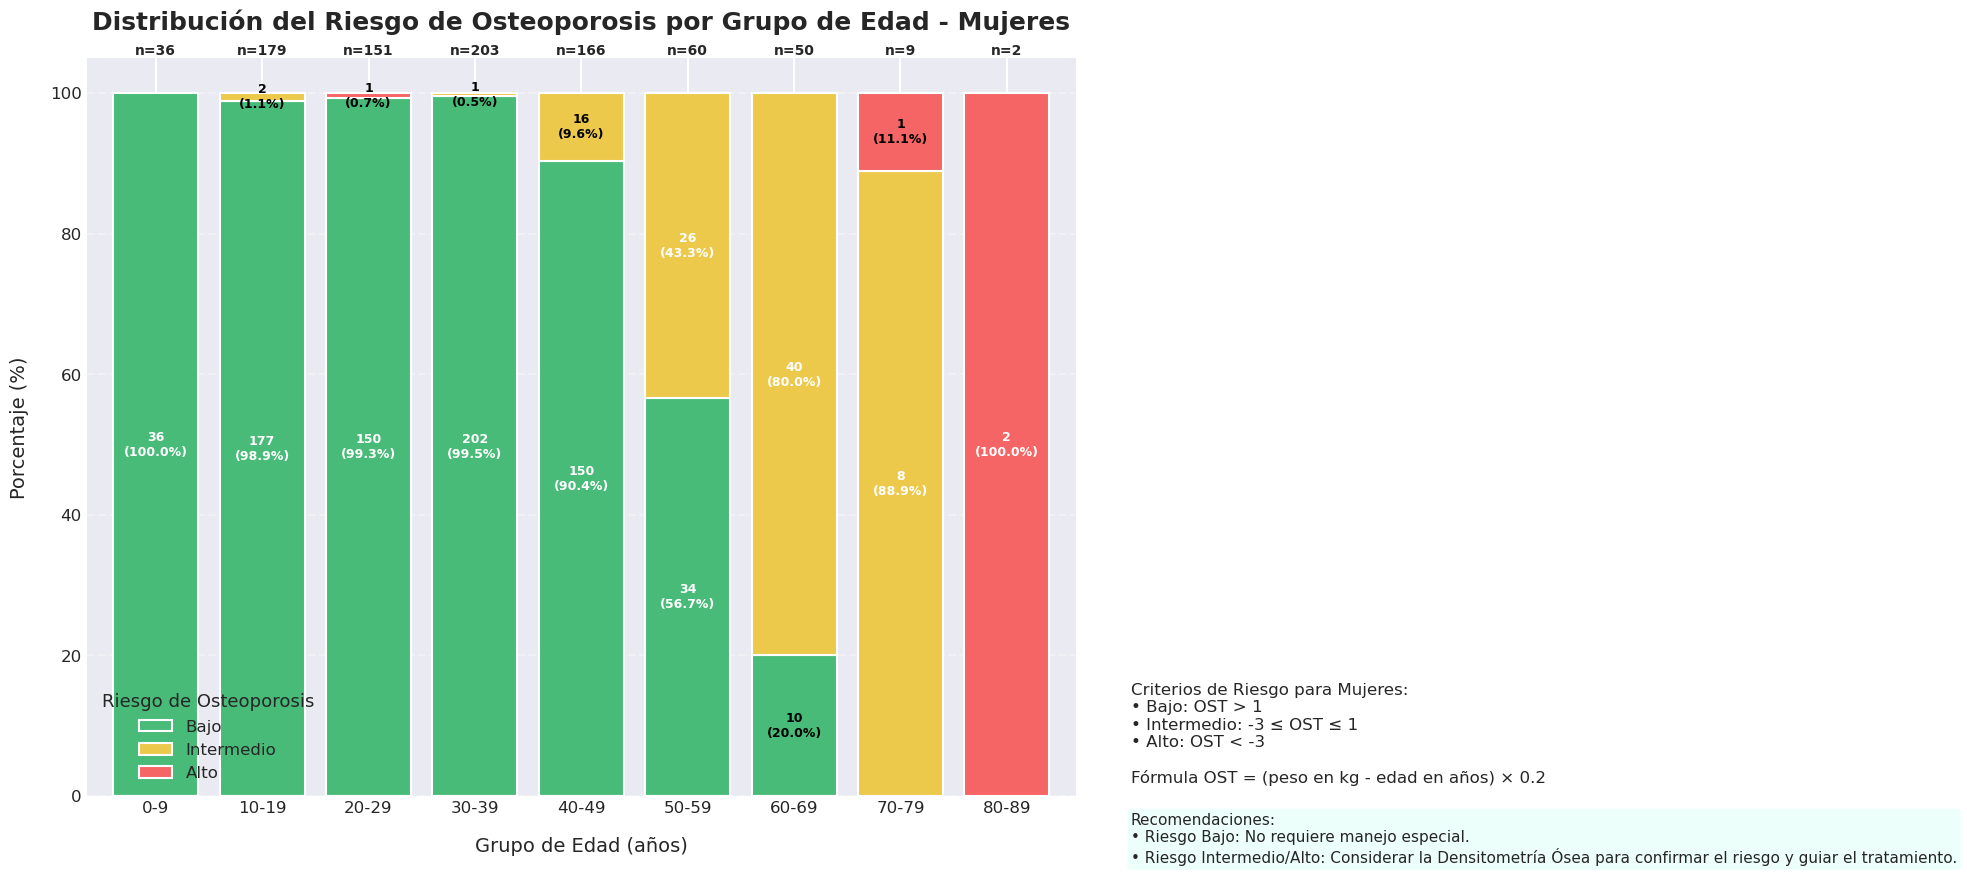

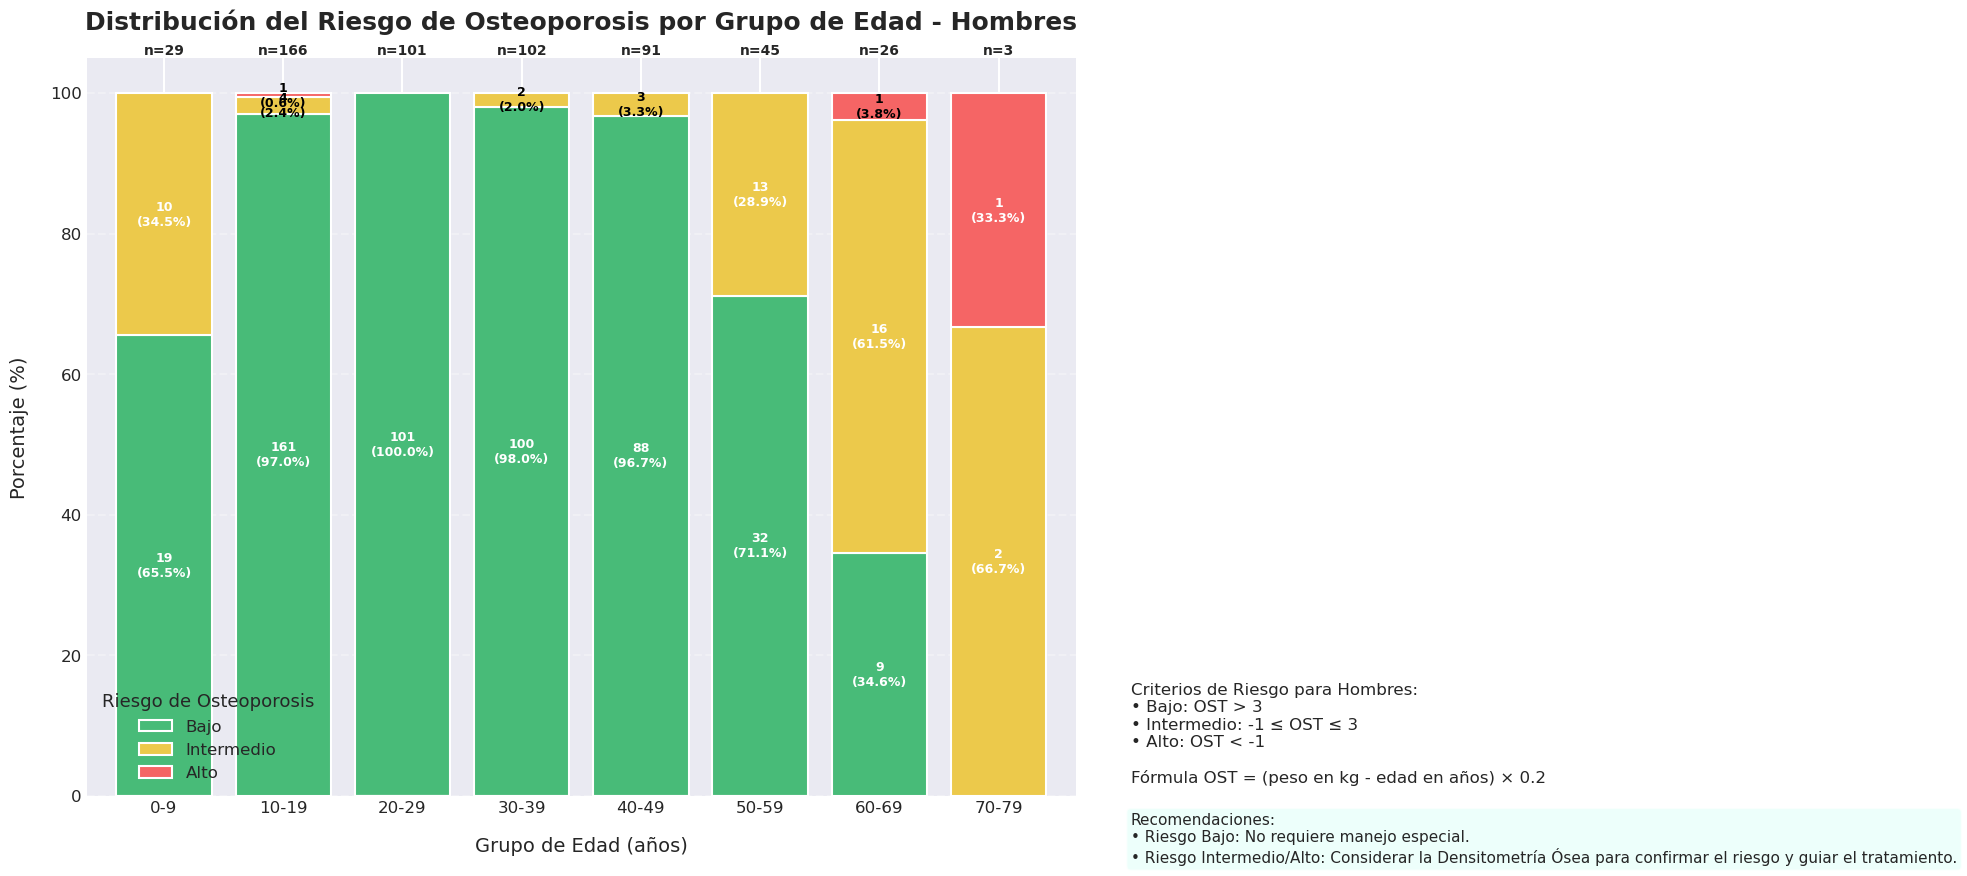


Estadísticas de riesgo de osteoporosis por grupo de edad y sexo:
------------------------------------------------------------

MUJERES:

Grupo de edad 0-9 (n=36):
  Bajo: 36 personas (100.0%)
  Intermedio: 0 personas (0.0%)
  Alto: 0 personas (0.0%)

Grupo de edad 10-19 (n=179):
  Bajo: 177 personas (98.9%)
  Intermedio: 2 personas (1.1%)
  Alto: 0 personas (0.0%)

Grupo de edad 20-29 (n=151):
  Bajo: 150 personas (99.3%)
  Intermedio: 0 personas (0.0%)
  Alto: 1 personas (0.7%)

Grupo de edad 30-39 (n=203):
  Bajo: 202 personas (99.5%)
  Intermedio: 1 personas (0.5%)
  Alto: 0 personas (0.0%)

Grupo de edad 40-49 (n=166):
  Bajo: 150 personas (90.4%)
  Intermedio: 16 personas (9.6%)
  Alto: 0 personas (0.0%)

Grupo de edad 50-59 (n=60):
  Bajo: 34 personas (56.7%)
  Intermedio: 26 personas (43.3%)
  Alto: 0 personas (0.0%)

Grupo de edad 60-69 (n=50):
  Bajo: 10 personas (20.0%)
  Intermedio: 40 personas (80.0%)
  Alto: 0 personas (0.0%)

Grupo de edad 70-79 (n=9):
  Bajo: 0 personas

/tmp/ipykernel_4485/4229723886.py:203: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Mujeres': female_data.groupby('age_group')['ost_risk_category'].apply(lambda x: (x == 'Alto').mean() * 100),
/tmp/ipykernel_4485/4229723886.py:204: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Hombres': male_data.groupby('age_group')['ost_risk_category'].apply(lambda x: (x == 'Alto').mean() * 100)


<Figure size 1400x800 with 0 Axes>

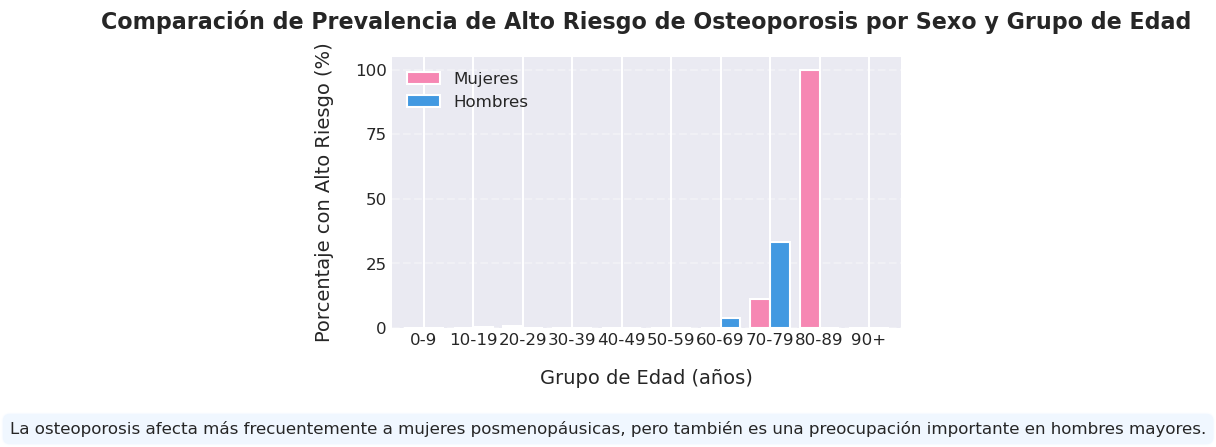

In [1342]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Definir los grupos de edad (de 10 en 10 años)
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

# Crear la columna de grupo de edad
data['age_group'] = pd.cut(data['age_years'], bins=bins, labels=labels, right=False)

# Definir función para categorizar el riesgo de osteoporosis según sexo
def categorize_ost_risk(row):
    if pd.isna(row['ost_score_value']):
        return np.nan
    
    if row['sex'] == 'FEMALE':
        if row['ost_score_value'] > 1:
            return 'Bajo'
        elif -3 <= row['ost_score_value'] <= 1:
            return 'Intermedio'
        else:  # < -3
            return 'Alto'
    elif row['sex'] == 'MALE':
        if row['ost_score_value'] > 3:
            return 'Bajo'
        elif -1 <= row['ost_score_value'] <= 3:
            return 'Intermedio'
        else:  # < -1
            return 'Alto'
    else:
        return np.nan

# Aplicar la categorización
data['ost_risk_category'] = data.apply(categorize_ost_risk, axis=1)

# Crear DataFrames separados para hombres y mujeres
female_data = data[data['sex'] == 'FEMALE'].copy()
male_data = data[data['sex'] == 'MALE'].copy()

# Función para crear el gráfico por sexo
def create_ost_risk_plot(data_subset, sex_label):
    # Crear un DataFrame con los conteos por grupo de edad y categoría de riesgo
    ost_by_age = pd.crosstab(
        data_subset['age_group'], 
        data_subset['ost_risk_category'],
        normalize='index'
    ) * 100
    
    # Asegurarse de que todas las categorías estén presentes
    for category in ['Bajo', 'Intermedio', 'Alto']:
        if category not in ost_by_age.columns:
            ost_by_age[category] = 0
    
    # Reordenar las columnas para que aparezcan en el orden correcto
    ost_by_age = ost_by_age[['Bajo', 'Intermedio', 'Alto']]
    
    ost_counts = pd.crosstab(data_subset['age_group'], data_subset['ost_risk_category'])
    for category in ['Bajo', 'Intermedio', 'Alto']:
        if category not in ost_counts.columns:
            ost_counts[category] = 0
    
    ost_counts = ost_counts[['Bajo', 'Intermedio', 'Alto']]
    
    # Calcular el total por grupo de edad para las anotaciones
    age_group_totals = data_subset['age_group'].value_counts().sort_index()
    
    # Crear la figura
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Crear el gráfico de barras apiladas
    ost_by_age.plot(
        kind='bar', 
        stacked=True,
        color=['#48BB78', '#ECC94B', '#F56565'],  # Verde para bajo, amarillo para intermedio, rojo para alto
        width=0.8,
        ax=ax
    )
    
    # Personalizar el gráfico
    plt.title(f'Distribución del Riesgo de Osteoporosis por Grupo de Edad - {sex_label}', 
              fontsize=18, fontweight='bold', pad=20)
    plt.xlabel('Grupo de Edad (años)', fontsize=14, labelpad=15)
    plt.ylabel('Porcentaje (%)', fontsize=14, labelpad=15)
    plt.xticks(rotation=0, fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(title='Riesgo de Osteoporosis', fontsize=12, title_fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Añadir etiquetas con el número de personas en cada categoría
    for i, age_group in enumerate(ost_by_age.index):
        if age_group in age_group_totals:
            total = age_group_totals[age_group]
            
            # Añadir el total del grupo de edad en la parte superior
            plt.text(
                i, 
                105, 
                f'n={total}',
                ha='center',
                va='bottom',
                fontweight='bold',
                fontsize=10
            )
            
            # Variables para llevar el seguimiento de la posición vertical
            cumulative_pct = 0
            
            # Añadir etiquetas para cada categoría de riesgo
            for category in ['Bajo', 'Intermedio', 'Alto']:
                if category in ost_counts.columns and age_group in ost_counts.index:
                    count = ost_counts.loc[age_group, category]
                    if count > 0:
                        pct = ost_by_age.loc[age_group, category]
                        y_pos = cumulative_pct + (pct / 2)
                        plt.text(
                            i, 
                            y_pos, 
                            f'{count}\n({pct:.1f}%)',
                            ha='center',
                            va='center',
                            fontweight='bold',
                            fontsize=9,
                            color='white' if pct > 20 else 'black'
                        )
                        cumulative_pct += pct
    
    # Añadir una caja explicativa con los criterios específicos por sexo
    if sex_label == 'Mujeres':
        explanation_text = (
            "Criterios de Riesgo para Mujeres:\n"
            "• Bajo: OST > 1\n"
            "• Intermedio: -3 ≤ OST ≤ 1\n"
            "• Alto: OST < -3\n\n"
            "Fórmula OST = (peso en kg - edad en años) × 0.2"
        )
    else:  # Hombres
        explanation_text = (
            "Criterios de Riesgo para Hombres:\n"
            "• Bajo: OST > 3\n"
            "• Intermedio: -1 ≤ OST ≤ 3\n"
            "• Alto: OST < -1\n\n"
            "Fórmula OST = (peso en kg - edad en años) × 0.2"
        )
    
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    plt.figtext(0.82, 0.25, explanation_text, fontsize=12, 
                bbox=props, verticalalignment='top')
    
    # Añadir recomendaciones de manejo
    management_text = (
        "Recomendaciones:\n"
        "• Riesgo Bajo: No requiere manejo especial.\n"
        "• Riesgo Intermedio/Alto: Considerar la Densitometría Ósea para confirmar el riesgo y guiar el tratamiento."
    )
    
    props = dict(boxstyle='round', facecolor='#E6FFFA', alpha=0.7)
    plt.figtext(0.82, 0.12, management_text, fontsize=11, 
                bbox=props, verticalalignment='top')
    
    plt.tight_layout(rect=[0, 0.05, 0.8, 0.95])
    
    return fig, ost_by_age, ost_counts, age_group_totals

# Crear y mostrar los gráficos para mujeres y hombres
fig_female, female_ost_by_age, female_ost_counts, female_age_totals = create_ost_risk_plot(female_data, 'Mujeres')
plt.show()

fig_male, male_ost_by_age, male_ost_counts, male_age_totals = create_ost_risk_plot(male_data, 'Hombres')
plt.show()

# Mostrar estadísticas adicionales
print("\nEstadísticas de riesgo de osteoporosis por grupo de edad y sexo:")
print("-" * 60)

print("\nMUJERES:")
for age_group in female_ost_by_age.index:
    if age_group in female_age_totals:
        total = female_age_totals[age_group]
        print(f"\nGrupo de edad {age_group} (n={total}):")
        
        for category in ['Bajo', 'Intermedio', 'Alto']:
            if category in female_ost_by_age.columns and age_group in female_ost_by_age.index:
                pct = female_ost_by_age.loc[age_group, category]
                count = female_ost_counts.loc[age_group, category] if age_group in female_ost_counts.index else 0
                print(f"  {category}: {count} personas ({pct:.1f}%)")

print("\nHOMBRES:")
for age_group in male_ost_by_age.index:
    if age_group in male_age_totals:
        total = male_age_totals[age_group]
        print(f"\nGrupo de edad {age_group} (n={total}):")
        
        for category in ['Bajo', 'Intermedio', 'Alto']:
            if category in male_ost_by_age.columns and age_group in male_ost_by_age.index:
                pct = male_ost_by_age.loc[age_group, category]
                count = male_ost_counts.loc[age_group, category] if age_group in male_ost_counts.index else 0
                print(f"  {category}: {count} personas ({pct:.1f}%)")

# Crear un gráfico adicional que compare la prevalencia de alto riesgo entre hombres y mujeres
high_risk_comparison = pd.DataFrame({
    'Mujeres': female_data.groupby('age_group')['ost_risk_category'].apply(lambda x: (x == 'Alto').mean() * 100),
    'Hombres': male_data.groupby('age_group')['ost_risk_category'].apply(lambda x: (x == 'Alto').mean() * 100)
})

# Rellenar NaN con 0
high_risk_comparison = high_risk_comparison.fillna(0)

plt.figure(figsize=(14, 8))
high_risk_comparison.plot(kind='bar', color=['#F687B3', '#4299E1'], width=0.8)
plt.title('Comparación de Prevalencia de Alto Riesgo de Osteoporosis por Sexo y Grupo de Edad', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Grupo de Edad (años)', fontsize=14, labelpad=15)
plt.ylabel('Porcentaje con Alto Riesgo (%)', fontsize=14, labelpad=15)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Añadir una nota sobre la interpretación
plt.figtext(
    0.5, 0.01, 
    "La osteoporosis afecta más frecuentemente a mujeres posmenopáusicas, pero también es una preocupación importante en hombres mayores.",
    ha='center', 
    fontsize=12, 
    bbox={'facecolor':'#EBF4FF', 'alpha':0.7, 'pad':10, 'boxstyle':'round,pad=0.5'}
)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

## Presión Arterial

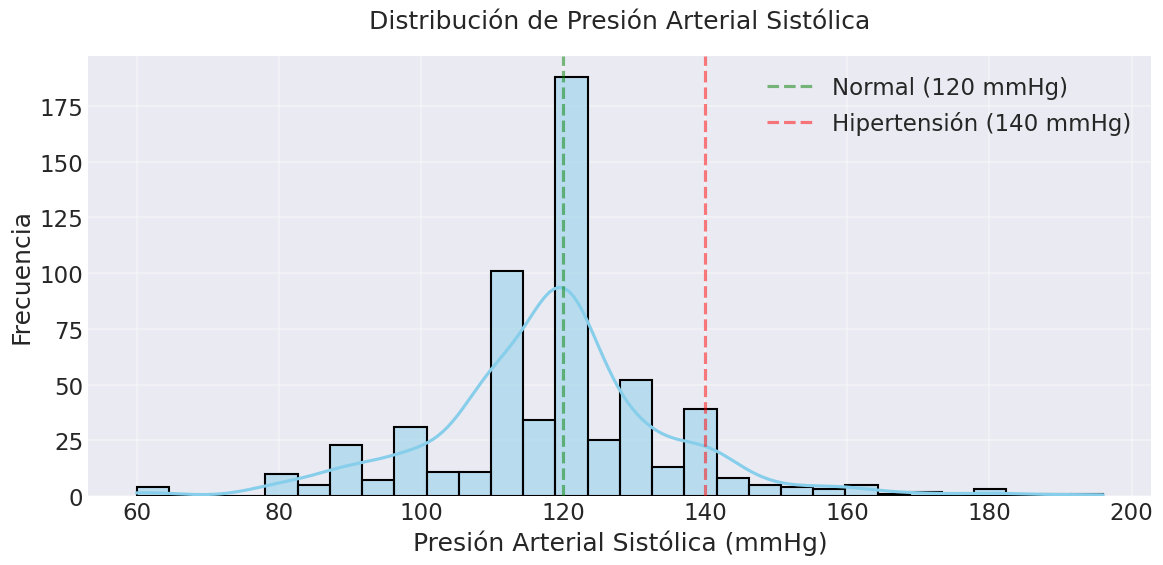


Estadísticas de Presión Arterial Sistólica:
count    587.0
mean     119.0
std       17.0
min       60.0
25%      110.0
50%      120.0
75%      125.0
max      196.0
Name: systolic_blood_pressure_mm_hg, dtype: float64


In [1343]:
# Filtrar registros donde la presión arterial sistólica no sea nula ni la cadena "NULL"
data_systolic = data[
    (data['systolic_blood_pressure_mm_hg'].notna()) &
    (data['systolic_blood_pressure_mm_hg'] != "NULL")
].copy()

# Convertir a numérico y filtrar valores razonables de presión sistólica (60-200 mmHg)
data_systolic['systolic_blood_pressure_mm_hg'] = pd.to_numeric(
    data_systolic['systolic_blood_pressure_mm_hg'], 
    errors='coerce'
)
data_systolic = data_systolic[
    (data_systolic['systolic_blood_pressure_mm_hg'] >= 60) &
    (data_systolic['systolic_blood_pressure_mm_hg'] <= 300)
]

# Crear el histograma con más bins y mejor estilo
plt.figure(figsize=(12, 6))
sns.histplot(
    data=data_systolic,
    x='systolic_blood_pressure_mm_hg',
    bins=30,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

# Personalizar el gráfico
plt.title('Distribución de Presión Arterial Sistólica', pad=20)
plt.xlabel('Presión Arterial Sistólica (mmHg)')
plt.ylabel('Frecuencia')

# Agregar líneas de referencia para valores normales (120/80)
plt.axvline(x=120, color='green', linestyle='--', alpha=0.5, label='Normal (120 mmHg)')
plt.axvline(x=140, color='red', linestyle='--', alpha=0.5, label='Hipertensión (140 mmHg)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Mostrar estadísticas descriptivas
print("\nEstadísticas de Presión Arterial Sistólica:")
print(data_systolic['systolic_blood_pressure_mm_hg'].describe().round(0))

/tmp/ipykernel_4485/3021432347.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_4485/3021432347.py:52: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


<Axes: title={'center': 'Encuesta ¿Se conoce con Hipertensión?'}, xlabel='Personas que se conocen con Hipertensión', ylabel='Cantidad de Personas'>

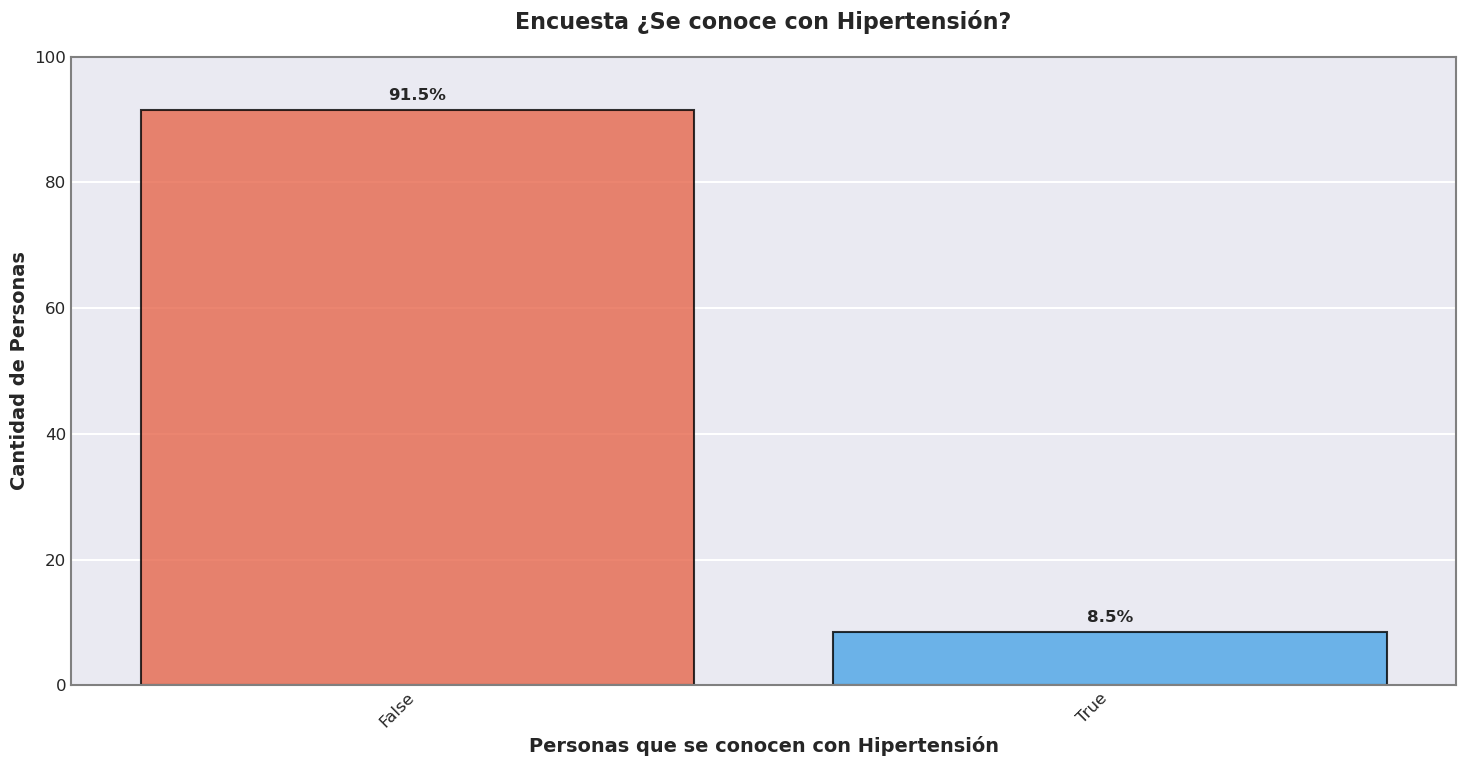

In [1344]:
# Distribución de personas con Hipertensión
plot_category_percentages(
    data, 
    column='has_hypertension', 
    title="Encuesta ¿Se conoce con Hipertensión?", 
    xlabel="Personas que se conocen con Hipertensión", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

In [1345]:
data.has_hypertension.value_counts()

has_hypertension
False    1299
True      120
Name: count, dtype: int64

Porcentaje diagnosticado: 8.456659619450317%
Prevalencia estimada: 35%
Porcentaje subdiagnosticado (dentro de la prevalencia): 0.8%


/tmp/ipykernel_4485/2412830000.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=categories, y=values, palette="viridis")


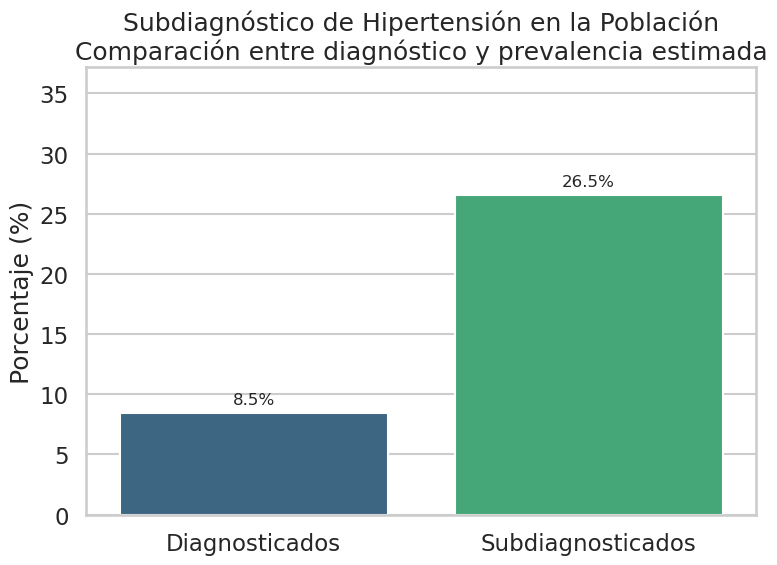

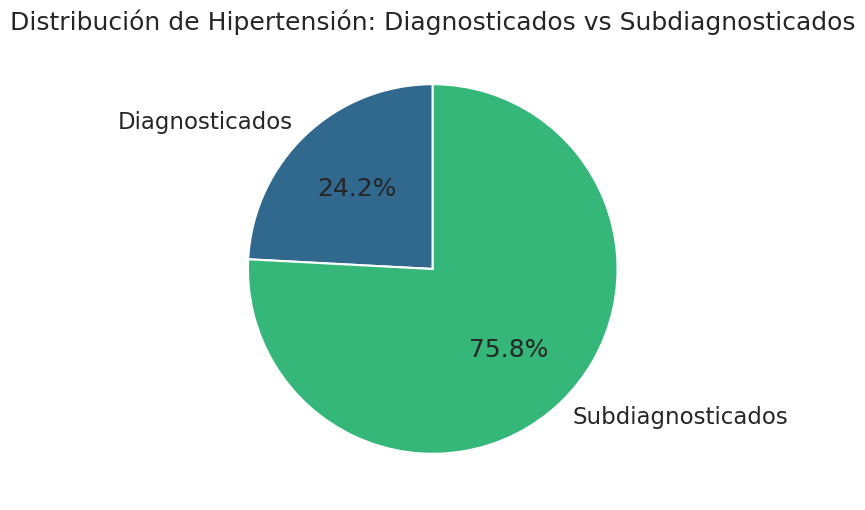

In [1346]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración inicial del estilo
sns.set_theme(style="whitegrid", context="talk")

# Valores obtenidos (en %)
diagnosed_percentage = data['has_hypertension'].value_counts(normalize=True).get(True, 0) * 100
estimated_prevalence = 35      # Prevalencia estimada de diabetes en la población
undiagnosed_percentage = estimated_prevalence - diagnosed_percentage

# Cálculo de la proporción de subdiagnosticados dentro de la prevalencia estimada
subdiagnosed_fraction = (undiagnosed_percentage / estimated_prevalence)

# Mostrar la información en consola
print(f"Porcentaje diagnosticado: {diagnosed_percentage}%")
print(f"Prevalencia estimada: {estimated_prevalence}%")
print(f"Porcentaje subdiagnosticado (dentro de la prevalencia): {subdiagnosed_fraction:.1f}%")

# Representación gráfica: Gráfico de barras
categories = ['Diagnosticados', 'Subdiagnosticados']
values = [diagnosed_percentage, undiagnosed_percentage]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=categories, y=values, palette="viridis")

# Anotamos cada barra con su porcentaje
for index, value in enumerate(values):
    ax.text(index, value + 0.5, f"{value:.1f}%", ha="center", va="bottom", fontsize=12)

plt.title("Subdiagnóstico de Hipertensión en la Población\nComparación entre diagnóstico y prevalencia estimada")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, max(values) * 1.4)
plt.tight_layout()
plt.show()

# Representación gráfica alternativa: Gráfico de pastel
labels = ['Diagnosticados', 'Subdiagnosticados']
sizes = [diagnosed_percentage, undiagnosed_percentage]
colors = sns.color_palette("viridis", 2)

plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Distribución de Hipertensión: Diagnosticados vs Subdiagnosticados")
plt.show()

/tmp/ipykernel_4485/928796975.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=counts, palette="viridis", ax=axes[0])


Total de personas encuestadas: 1419
Personas diagnosticadas de hipertension: 120 (8.5%)
Prevalencia estimada de hipertension: 35% --> Aproximadamente 497 personas
Posibles casos subdiagnosticados: 377 (26.5%)


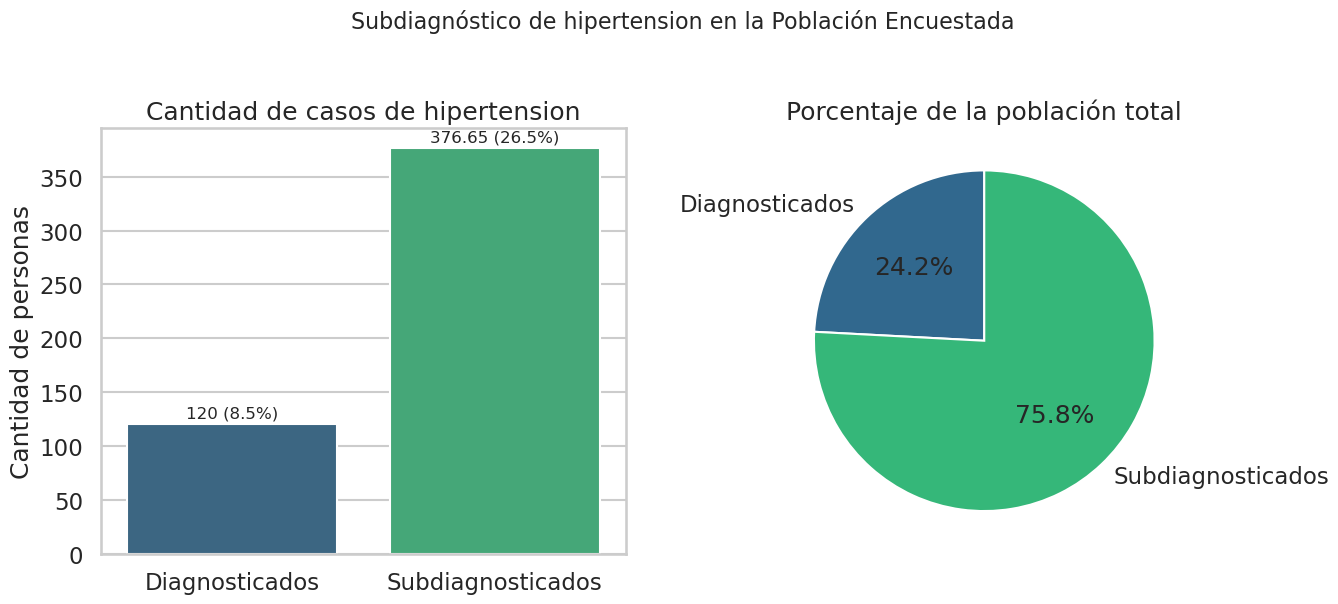

In [1347]:
# Calcular la cantidad total de personas encuestadas
total_population = len(data)

# Cantidad de personas que se conocen con hipertension
diagnosed_count = data[data['has_hypertension'] == True].shape[0]
diagnosed_pct = (diagnosed_count / total_population) * 100

# Prevalencia estimada de hipertension (10.5%)
estimated_prevalence = 35
estimated_count = total_population * estimated_prevalence / 100

# Calcular posibles casos subdiagnosticados
undiagnosed_count = estimated_count - diagnosed_count
undiagnosed_pct = (undiagnosed_count / total_population) * 100

# Mostrar en consola los cálculos
print(f"Total de personas encuestadas: {total_population}")
print(f"Personas diagnosticadas de hipertension: {diagnosed_count} ({diagnosed_pct:.1f}%)")
print(f"Prevalencia estimada de hipertension: {estimated_prevalence}% --> Aproximadamente {estimated_count:.0f} personas")
print(f"Posibles casos subdiagnosticados: {undiagnosed_count:.0f} ({undiagnosed_pct:.1f}%)")

# Crear las visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Gráfico de barras para visualizar la cantidad y el porcentaje
categories = ['Diagnosticados', 'Subdiagnosticados']
counts = [diagnosed_count, undiagnosed_count]
percentages = [diagnosed_pct, undiagnosed_pct]

sns.barplot(x=categories, y=counts, palette="viridis", ax=axes[0])
axes[0].set_title("Cantidad de casos de hipertension")
axes[0].set_ylabel("Cantidad de personas")
for i, v in enumerate(counts):
    axes[0].text(i, v + max(counts)*0.01, f"{v} ({percentages[i]:.1f}%)", 
                 ha="center", va="bottom", fontsize=12)

# 2. Gráfico de pastel para representar el porcentaje de la población total
labels = ['Diagnosticados', 'Subdiagnosticados']
sizes = [diagnosed_pct, undiagnosed_pct]
colors = sns.color_palette("viridis", n_colors=2)
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title("Porcentaje de la población total")

plt.suptitle("Subdiagnóstico de hipertension en la Población Encuestada", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_4485/3021432347.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_4485/3021432347.py:52: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.barplot(


<Axes: title={'center': 'Distribución de Personas con Diabetes'}, xlabel='Personas con Diabetes', ylabel='Cantidad de Personas'>

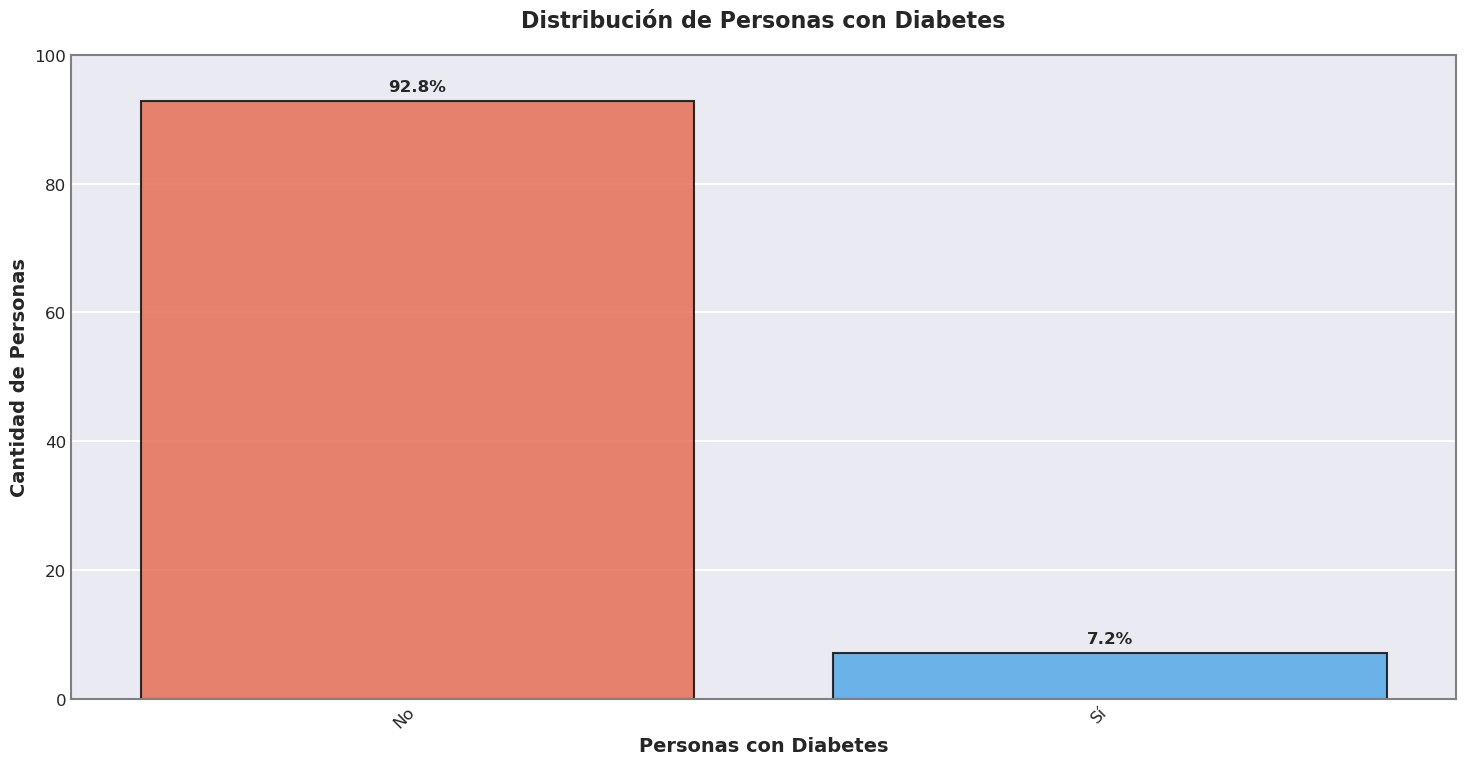

In [1348]:
# Distribución de personas con Diabetes
plot_category_percentages(
    data, 
    column='has_diabetes', 
    title="Distribución de Personas con Diabetes", 
    xlabel="Personas con Diabetes", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

Porcentaje diagnosticado: 7.188160676532769%
Prevalencia estimada: 10.5%
Porcentaje subdiagnosticado (dentro de la prevalencia): 31.5%


/tmp/ipykernel_4485/3933524624.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=categories, y=values, palette="viridis")


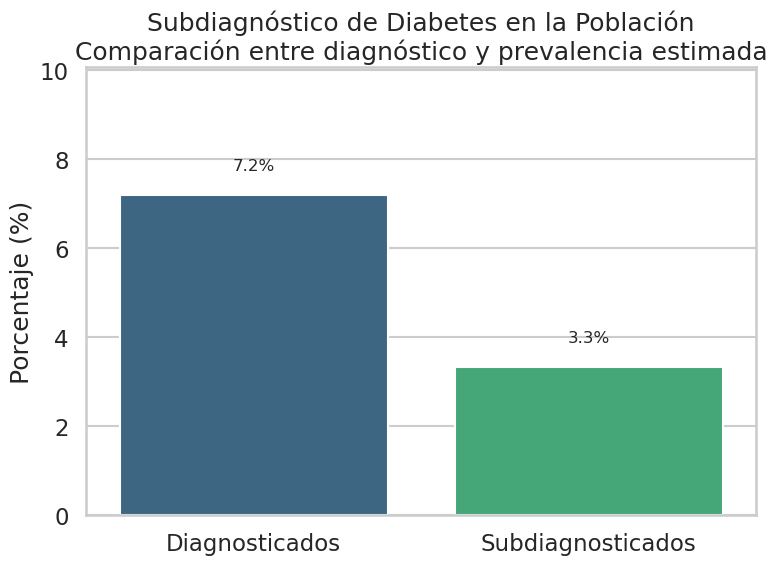

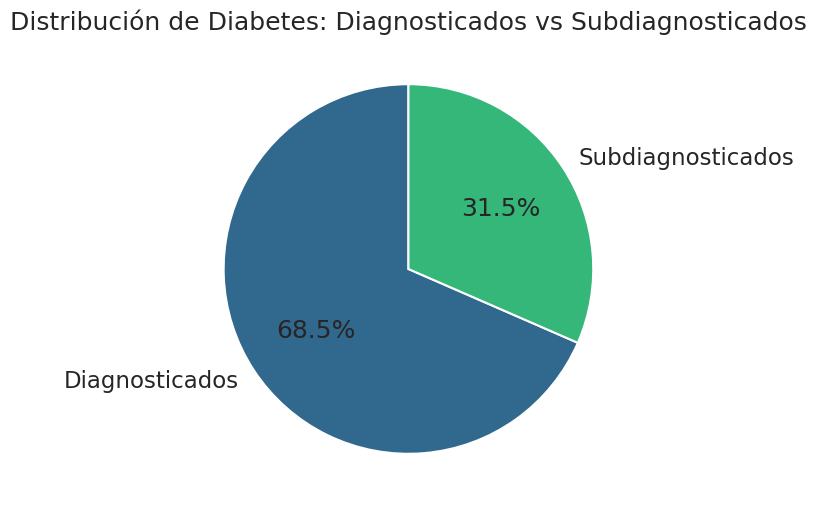

In [1349]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración inicial del estilo
sns.set_theme(style="whitegrid", context="talk")

# Valores obtenidos (en %)
diagnosed_percentage = data.has_diabetes.value_counts(normalize=True).get(True, 0) * 100
estimated_prevalence = 10.5      # Prevalencia estimada de diabetes en la población
undiagnosed_percentage = estimated_prevalence - diagnosed_percentage

# Cálculo de la proporción de subdiagnosticados dentro de la prevalencia estimada
subdiagnosed_fraction = (undiagnosed_percentage / estimated_prevalence) * 100

# Mostrar la información en consola
print(f"Porcentaje diagnosticado: {diagnosed_percentage}%")
print(f"Prevalencia estimada: {estimated_prevalence}%")
print(f"Porcentaje subdiagnosticado (dentro de la prevalencia): {subdiagnosed_fraction:.1f}%")

# Representación gráfica: Gráfico de barras
categories = ['Diagnosticados', 'Subdiagnosticados']
values = [diagnosed_percentage, undiagnosed_percentage]

plt.figure(figsize=(8,6))
ax = sns.barplot(x=categories, y=values, palette="viridis")

# Anotamos cada barra con su porcentaje
for index, value in enumerate(values):
    ax.text(index, value + 0.5, f"{value:.1f}%", ha="center", va="bottom", fontsize=12)

plt.title("Subdiagnóstico de Diabetes en la Población\nComparación entre diagnóstico y prevalencia estimada")
plt.ylabel("Porcentaje (%)")
plt.ylim(0, max(values) * 1.4)
plt.tight_layout()
plt.show()

# Representación gráfica alternativa: Gráfico de pastel
labels = ['Diagnosticados', 'Subdiagnosticados']
sizes = [diagnosed_percentage, undiagnosed_percentage]
colors = sns.color_palette("viridis", 2)

plt.figure(figsize=(8,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title("Distribución de Diabetes: Diagnosticados vs Subdiagnosticados")
plt.show()

/tmp/ipykernel_4485/508512400.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categories, y=counts, palette="viridis", ax=axes[0])


Total de personas encuestadas: 1419
Personas diagnosticadas de diabetes: 102 (7.2%)
Prevalencia estimada de diabetes: 10.5% --> Aproximadamente 149 personas
Posibles casos subdiagnosticados: 47 (3.3%)


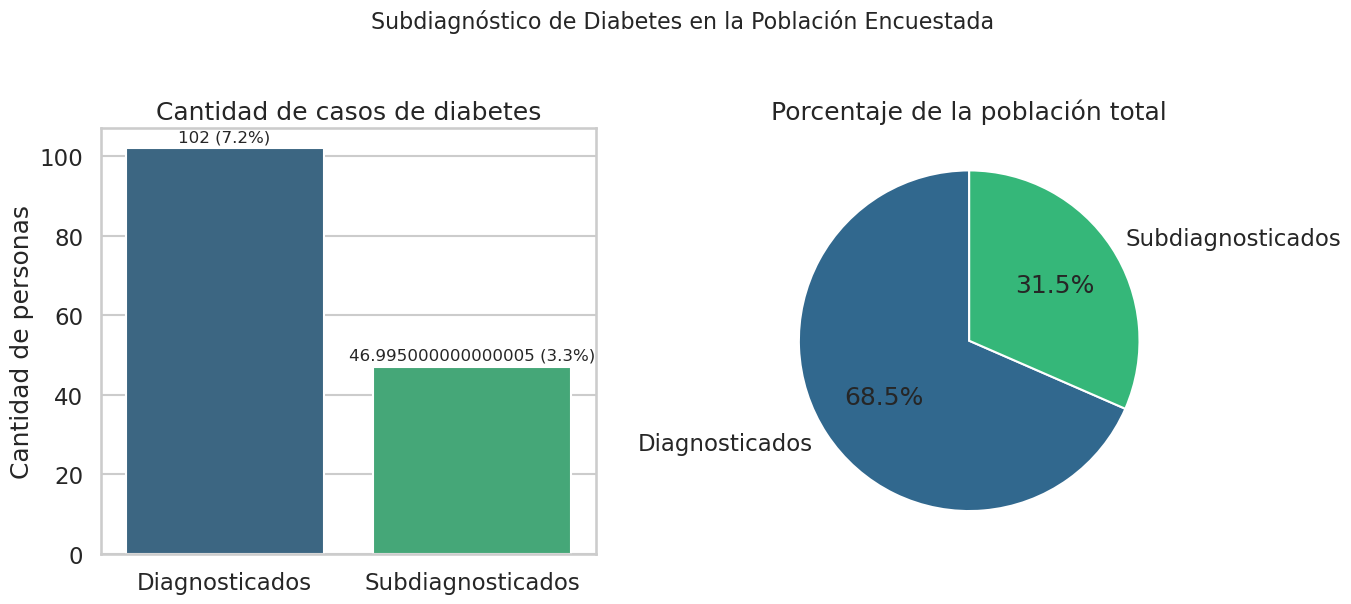

In [1350]:
# Calcular la cantidad total de personas encuestadas
total_population = len(data)

# Cantidad de personas que se conocen con diabetes
diagnosed_count = data[data['has_diabetes'] == True].shape[0]
diagnosed_pct = (diagnosed_count / total_population) * 100

# Prevalencia estimada de diabetes (10.5%)
estimated_prevalence = 10.5
estimated_count = total_population * estimated_prevalence / 100

# Calcular posibles casos subdiagnosticados
undiagnosed_count = estimated_count - diagnosed_count
undiagnosed_pct = (undiagnosed_count / total_population) * 100

# Mostrar en consola los cálculos
print(f"Total de personas encuestadas: {total_population}")
print(f"Personas diagnosticadas de diabetes: {diagnosed_count} ({diagnosed_pct:.1f}%)")
print(f"Prevalencia estimada de diabetes: {estimated_prevalence}% --> Aproximadamente {estimated_count:.0f} personas")
print(f"Posibles casos subdiagnosticados: {undiagnosed_count:.0f} ({undiagnosed_pct:.1f}%)")

# Crear las visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Gráfico de barras para visualizar la cantidad y el porcentaje
categories = ['Diagnosticados', 'Subdiagnosticados']
counts = [diagnosed_count, undiagnosed_count]
percentages = [diagnosed_pct, undiagnosed_pct]

sns.barplot(x=categories, y=counts, palette="viridis", ax=axes[0])
axes[0].set_title("Cantidad de casos de diabetes")
axes[0].set_ylabel("Cantidad de personas")
for i, v in enumerate(counts):
    axes[0].text(i, v + max(counts)*0.01, f"{v} ({percentages[i]:.1f}%)", 
                 ha="center", va="bottom", fontsize=12)

# 2. Gráfico de pastel para representar el porcentaje de la población total
labels = ['Diagnosticados', 'Subdiagnosticados']
sizes = [diagnosed_pct, undiagnosed_pct]
colors = sns.color_palette("viridis", n_colors=2)
axes[1].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
axes[1].set_title("Porcentaje de la población total")

plt.suptitle("Subdiagnóstico de Diabetes en la Población Encuestada", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [1361]:
# Cantidad de personas con alto riesgo de diabetes (diabetes_type2_probability_value > 50%   )
data_high_risk = data[data['diabetes_type2_probability_value'] > 0.5].copy()

# Conteo de personas con alto riesgo de diabetes
print(f"Cantidad de personas con alto riesgo de diabetes: {len(data_high_risk)}")
# Histograma de diabetes_type2_probability_value en pacientes no diabéticos (has_diabetes == False)
data_non_diabetics = data[data['has_diabetes'] == False].copy()


Cantidad de personas con alto riesgo de diabetes: 155


Text(0, 0.5, 'Frecuencia')

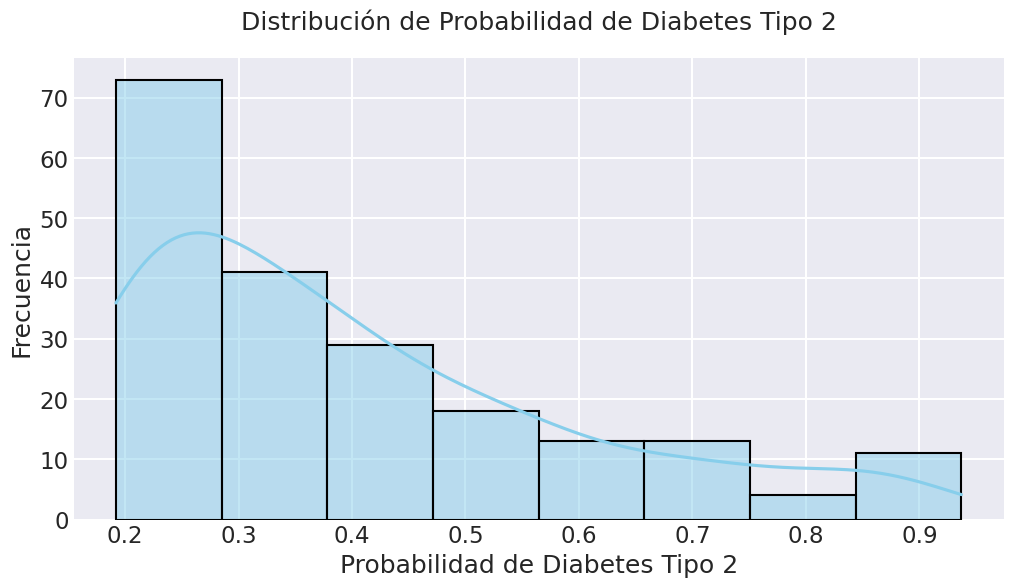

In [1357]:
# Histograma de diabetes_type2_probability_value en pacientes no diabéticos (has_diabetes == False) y omitiendo los valores nulos y ceros
data_non_diabetics = data_non_diabetics[data_non_diabetics['diabetes_type2_probability_value'].notna() & (data_non_diabetics['diabetes_type2_probability_value'] > 0)].copy()

# Crear el histograma
plt.figure(figsize=(12, 6))
sns.histplot(
    data=data_non_diabetics,
    x='diabetes_type2_probability_value',
    bins=8,
    kde=True,
    color='skyblue',
    edgecolor='black'
)

# Personalizar el gráfico
plt.title('Distribución de Probabilidad de Diabetes Tipo 2', pad=20)
plt.xlabel('Probabilidad de Diabetes Tipo 2')
plt.ylabel('Frecuencia')



/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de Personas con Enfermedad Cardiovascular'}, xlabel='Personas con Enfermedad Cardiovascular', ylabel='Cantidad de Personas'>

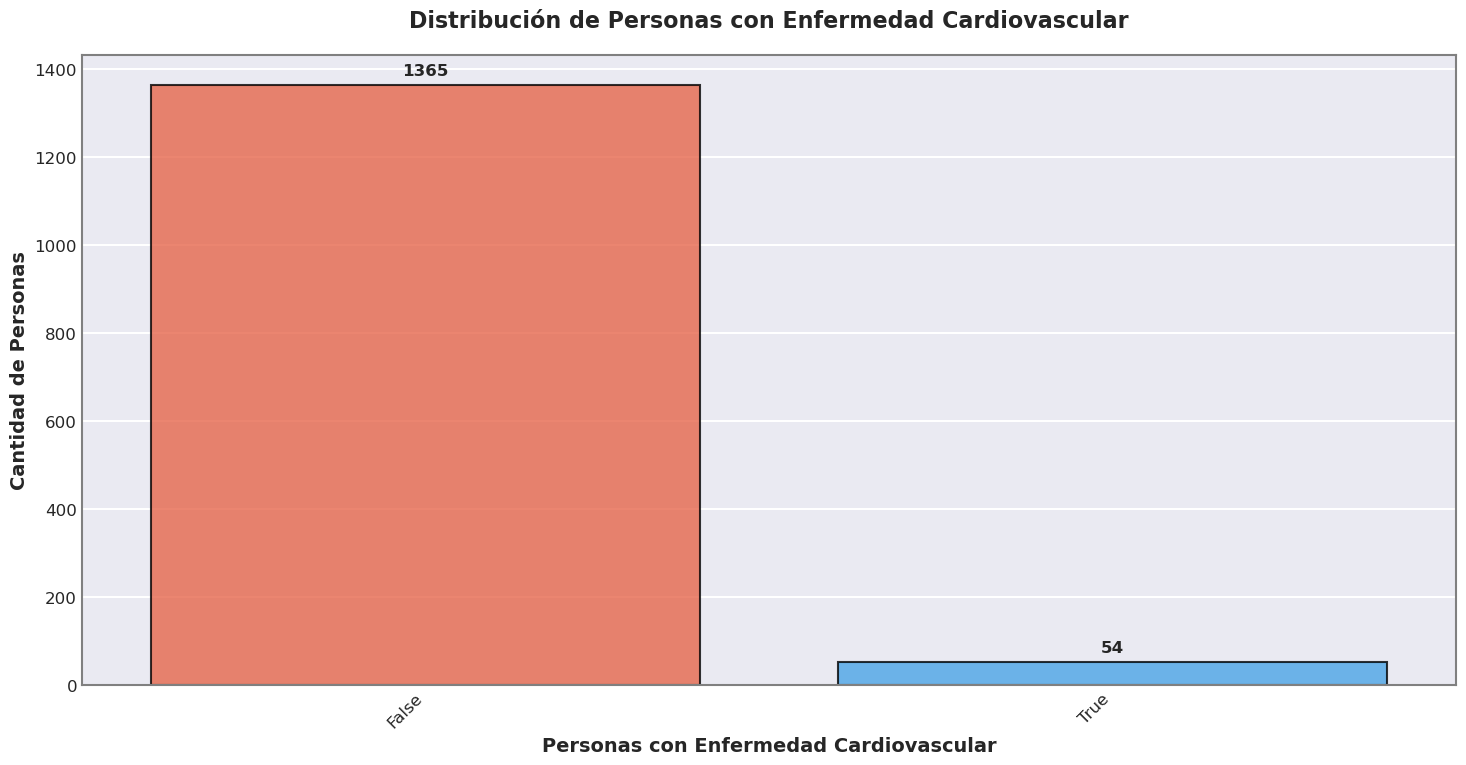

In [1358]:
# Distribución de personas con Enfermedad Cardiovascular
plot_category_counts(
    data, 
    column='has_cardiovascular_disease', 
    title="Distribución de Personas con Enfermedad Cardiovascular", 
    xlabel="Personas con Enfermedad Cardiovascular", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

### Riesgo CV

In [1364]:
def plot_category_percentages(data, column='smoking_status', title="Distribución de Estado de Tabaquismo (%)", 
                             xlabel="Estado de Tabaquismo", ylabel="Porcentaje (%)", 
                             figsize=(15,8), rotation=0, ha='center', use_hue=False, dodge=False, **kwargs):
    
    # Crear una copia para no modificar los datos originales
    df_temp = data.copy()
    
    # Eliminar valores nulos en la columna especificada
    df_temp = df_temp.dropna(subset=[column])
    
    # Traducir las categorías al español según la columna
    if column == 'smoking_status':
        traduccion = {
            'NON_SMOKER': 'No fumador',
            'CURRENT_SMOKER': 'Fumador actual',
            'FORMER_SMOKER': 'Ex fumador'
        }
        
        # Aplicar la traducción
        if column in df_temp.columns:
            df_temp[column] = df_temp[column].map(traduccion)
    
    # Traducir valores booleanos para columnas como has_hypertension
    elif column == 'has_hypertension':
        traduccion = {
            True: 'Sí',
            False: 'No'
        }
        
        # Aplicar la traducción
        if column in df_temp.columns:
            df_temp[column] = df_temp[column].map(traduccion)
    
    # Categorizar el riesgo cardiovascular
    elif column == 'cardiovascular_risk_value':
        # Filtrar valores extremos o anómalos (por ejemplo, mayores a 100 o negativos)
        df_temp = df_temp[(df_temp[column] >= 0) & (df_temp[column] <= 100)]
        
        # Crear una función para categorizar el riesgo
        def categorizar_riesgo(valor):
            if valor < 5:
                return 'Bajo (<5%)'
            elif 5 <= valor < 10:
                return 'Moderado (5% a <10%)'
            elif 10 <= valor < 20:
                return 'Alto (10% a <20%)'
            elif 20 <= valor < 30:
                return 'Muy alto (20% a <30%)'
            else:
                return 'Crítico (≥30%)'
        
        # Aplicar la categorización
        if column in df_temp.columns:
            df_temp['riesgo_categoria'] = df_temp[column].apply(categorizar_riesgo)
            column = 'riesgo_categoria'  # Cambiar la columna para el gráfico
    
    # Calcular los porcentajes
    total = len(df_temp)
    porcentajes = (df_temp[column].value_counts() / total * 100).reset_index()
    porcentajes.columns = [column, 'percentage']
    
    # Configurar el estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Crear la figura
    plt.figure(figsize=figsize)
    
    # Definir una paleta de colores específica para el riesgo cardiovascular si es esa columna
    if 'riesgo_categoria' in df_temp.columns and column == 'riesgo_categoria':
        # Ordenar las categorías para que aparezcan en orden lógico
        orden_categorias = [
            'Bajo (<5%)', 
            'Moderado (5% a <10%)', 
            'Alto (10% a <20%)', 
            'Muy alto (20% a <30%)', 
            'Crítico (≥30%)'
        ]
        porcentajes[column] = pd.Categorical(
            porcentajes[column], 
            categories=orden_categorias, 
            ordered=True
        )
        porcentajes = porcentajes.sort_values(column)
        
        # Paleta de colores para riesgo cardiovascular (verde a rojo)
        paleta = ['#2ECC71', '#F4D03F', '#E67E22', '#E74C3C', '#800000']
        
        # Crear el gráfico de barras con porcentajes y orden específico
        ax = sns.barplot(
            data=porcentajes, 
            x=column,
            y='percentage',
            palette=paleta,
            edgecolor='black',
            linewidth=1.5,
            alpha=0.8,
            **kwargs
        )
    else:
        # Definir una paleta de colores más llamativa para otros casos
        paleta = ['#FF5733', '#33A8FF', '#33FF57']
        
        # Crear el gráfico de barras con porcentajes
        ax = sns.barplot(
            data=porcentajes, 
            x=column,
            y='percentage',
            palette=paleta,
            edgecolor='black',
            linewidth=1.5,
            alpha=0.8,
            **kwargs  # Pasar cualquier otro parámetro adicional
        )
    
    # Añadir etiquetas con el porcentaje exacto encima de cada barra
    for p in ax.patches:
        ax.annotate(
            f'{p.get_height():.1f}%', 
            (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', 
            va='bottom',
            fontsize=12,
            fontweight='bold',
            xytext=(0, 5),
            textcoords='offset points'
        )
    
    # Personalizar el gráfico
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel(xlabel, fontsize=14, fontweight='bold')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold')
    plt.xticks(rotation=rotation, ha=ha, fontsize=12)
    plt.yticks(fontsize=12)
    
    # Establecer el límite del eje y para que vaya de 0 a 100%
    plt.ylim(0, min(100, porcentajes['percentage'].max() * 1.2))
    
    # Añadir un borde al gráfico
    for spine in ax.spines.values():
        spine.set_edgecolor('gray')
        spine.set_linewidth(1.5)
    
    # Ajustar los márgenes
    plt.tight_layout()
    
    return ax

/tmp/ipykernel_4485/3041446715.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


<Axes: title={'center': 'Distribución de Riesgo Cardiovascular'}, xlabel='Categoría de Riesgo', ylabel='Porcentaje (%)'>

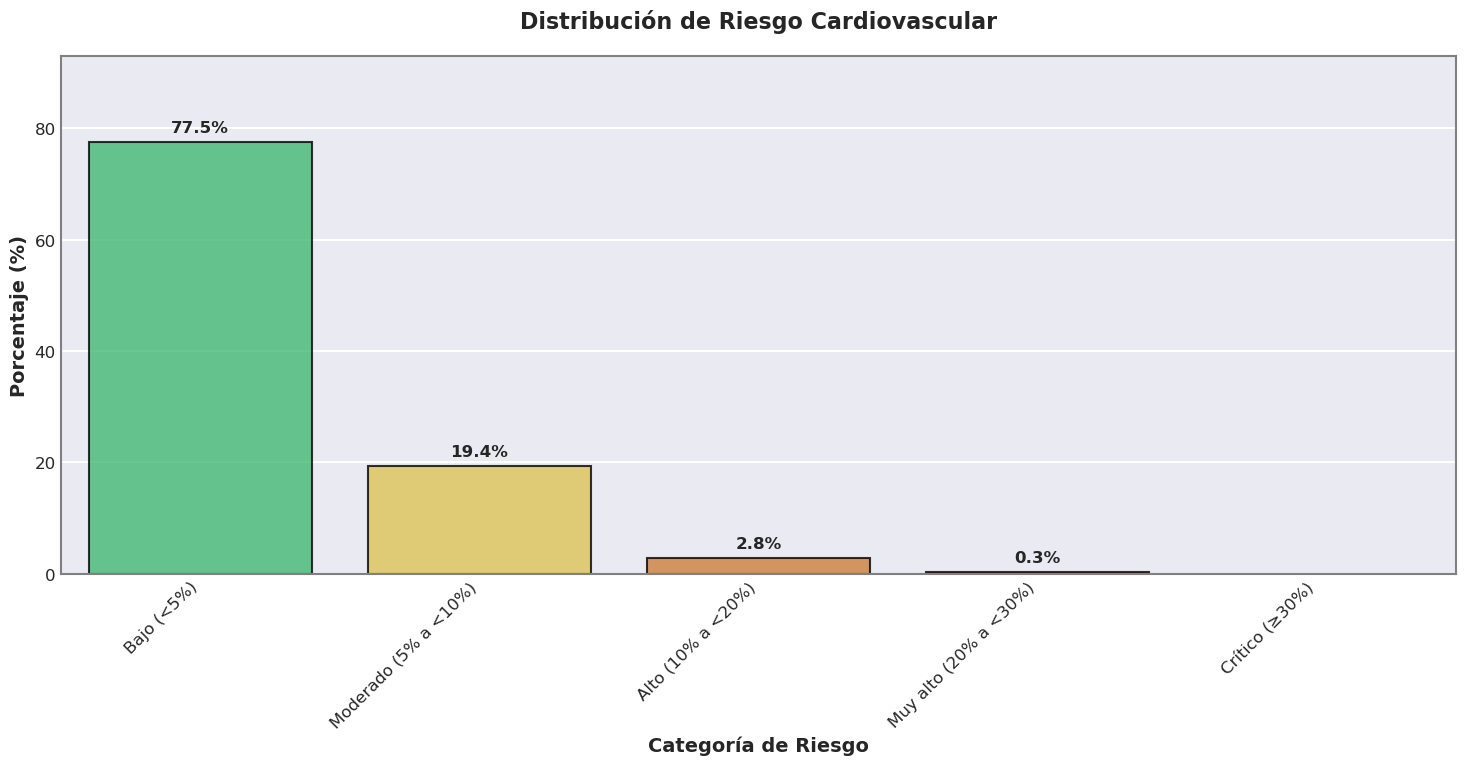

In [1365]:
# Distribución de personas con Enfermedad Cardiovascular
plot_category_percentages(
    data, 
    column='cardiovascular_risk_value', 
    title="Distribución de Riesgo Cardiovascular", 
    xlabel="Categoría de Riesgo", 
    ylabel="Porcentaje (%)", 
    figsize=(15,8), 
    rotation=45, 
    ha='right'
)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de Personas con Enfermedad Renal Crónica'}, xlabel='Personas con Enfermedad Renal Crónica', ylabel='Cantidad de Personas'>

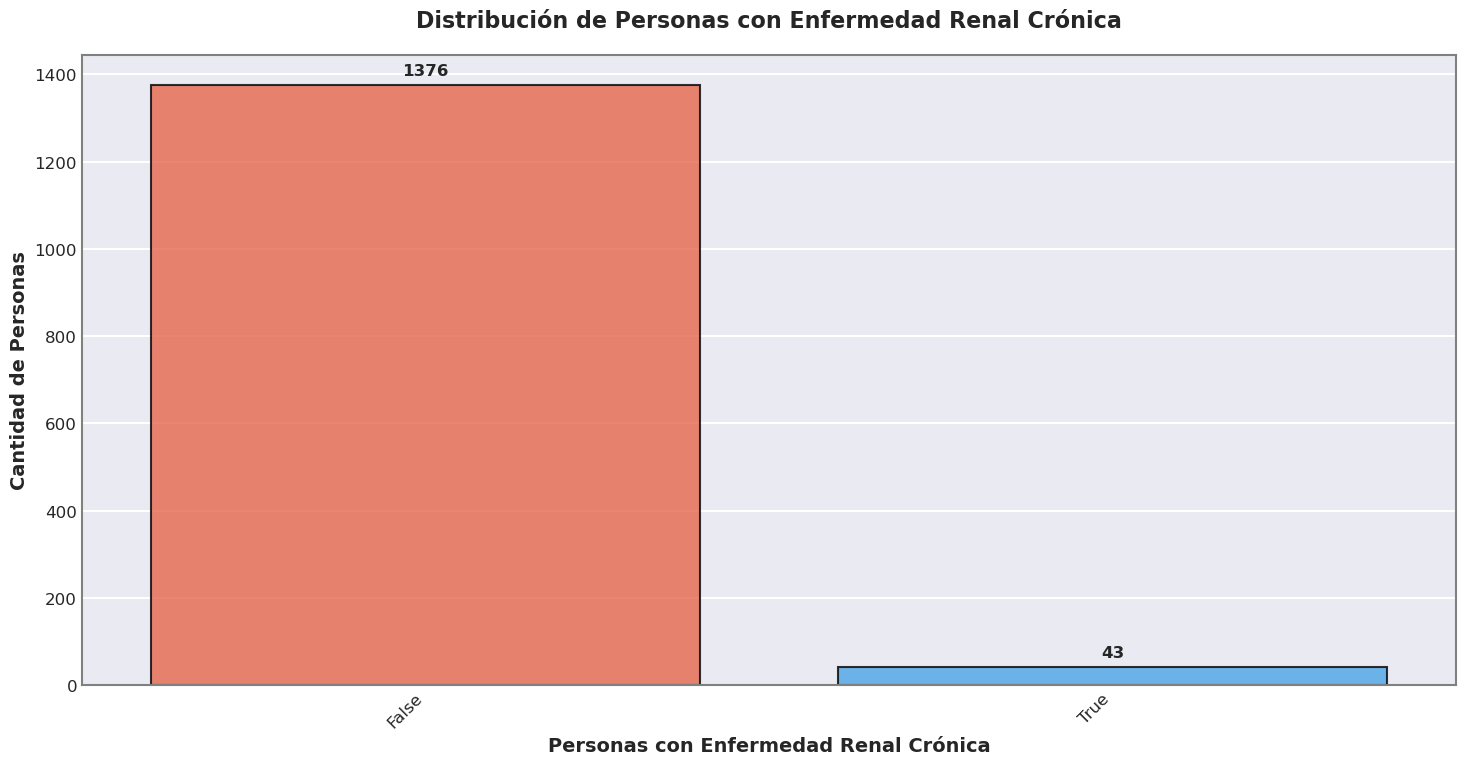

In [1359]:
# Distribución de personas con Enfermedad Renal Crónica
plot_category_counts(
    data, 
    column='has_chronic_kidney_disease', 
    title="Distribución de Personas con Enfermedad Renal Crónica", 
    xlabel="Personas con Enfermedad Renal Crónica", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

/tmp/ipykernel_4485/2579148211.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(
/tmp/ipykernel_4485/2579148211.py:30: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  ax = sns.countplot(


<Axes: title={'center': 'Distribución de Personas con Asma'}, xlabel='Personas con Asma', ylabel='Cantidad de Personas'>

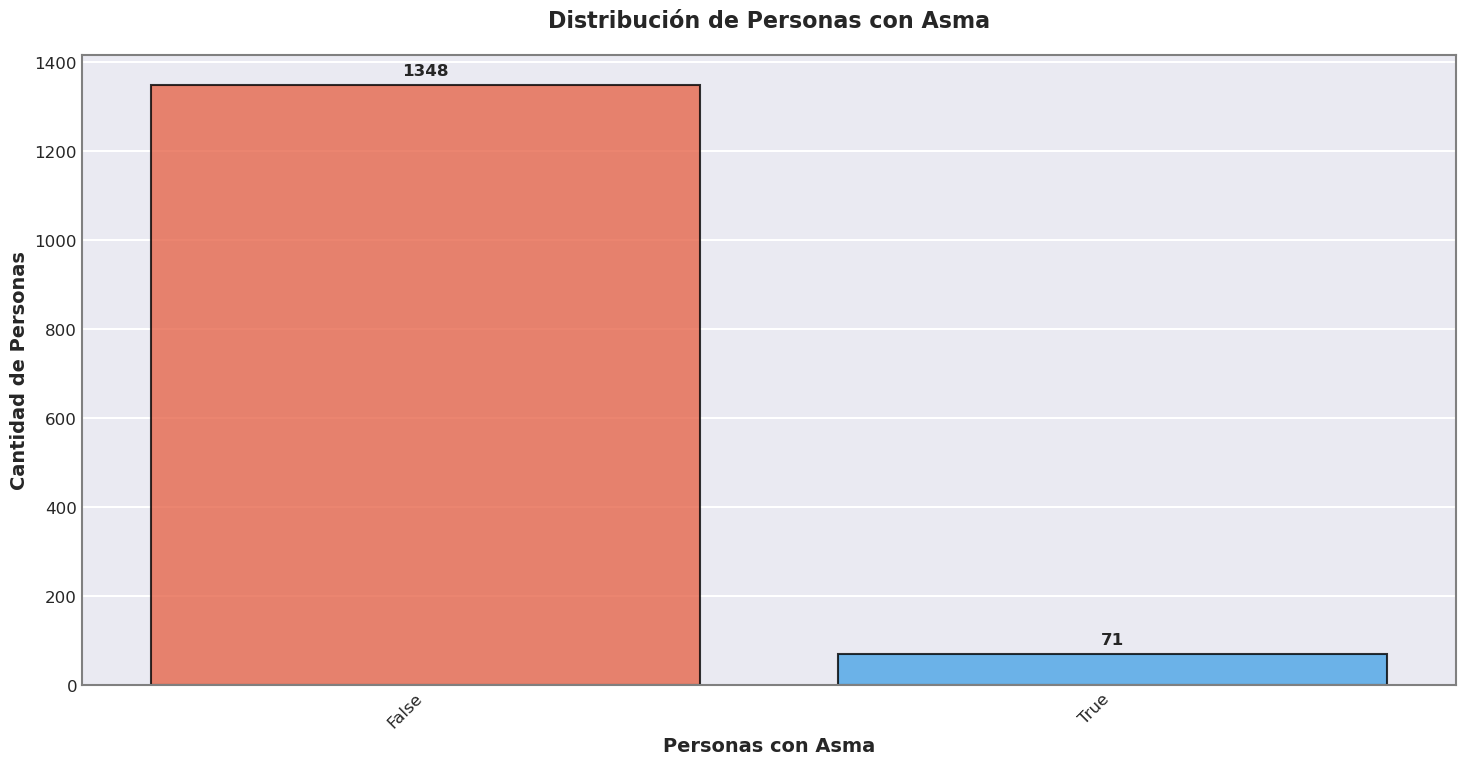

In [1360]:
# Distribución de personas con Asma
plot_category_counts(
    data, 
    column='has_asthma', 
    title="Distribución de Personas con Asma", 
    xlabel="Personas con Asma", 
    ylabel="Cantidad de Personas", 
    figsize=(15,8), 
    rotation=45, 
    ha='right', 
    use_hue=False
)

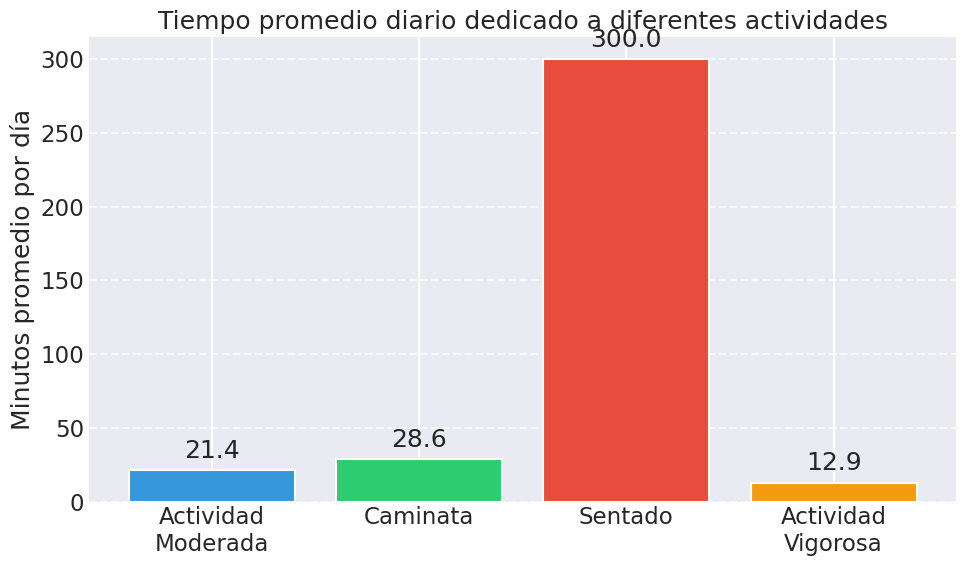

In [1368]:
import matplotlib.pyplot as plt
import numpy as np

# Supongamos que tenemos estos datos (deberías reemplazarlos con tus valores reales)
moderate_activity_days = 3  # ejemplo: 3 días a la semana
moderate_activity_minutes = 150  # ejemplo: 150 minutos en total

walking_days = 5  # ejemplo: 5 días a la semana
walking_minutes = 200  # ejemplo: 200 minutos en total

sitting_minutes = 2100  # ejemplo: 2100 minutos en total (7 días)

vigorous_activity_days = 2  # ejemplo: 2 días a la semana
vigorous_activity_minutes = 90  # ejemplo: 90 minutos en total

# Calcular promedios diarios
moderate_daily_avg = moderate_activity_minutes / 7  # promedio sobre toda la semana
walking_daily_avg = walking_minutes / 7  # promedio sobre toda la semana
sitting_daily_avg = sitting_minutes / 7  # promedio sobre toda la semana
vigorous_daily_avg = vigorous_activity_minutes / 7  # promedio sobre toda la semana

# Crear la gráfica
activities = ['Actividad\nModerada', 'Caminata', 'Sentado', 'Actividad\nVigorosa']
minutes = [moderate_daily_avg, walking_daily_avg, sitting_daily_avg, vigorous_daily_avg]

plt.figure(figsize=(10, 6))
bars = plt.bar(activities, minutes, color=['#3498db', '#2ecc71', '#e74c3c', '#f39c12'])

# Añadir etiquetas y título
plt.ylabel('Minutos promedio por día')
plt.title('Tiempo promedio diario dedicado a diferentes actividades')

# Añadir los valores sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height:.1f}',
             ha='center', va='bottom')

# Mejorar la presentación
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar la gráfica
plt.show()